In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/ANATOMIA PATOLOGICA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=109.0, y1=110.4
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 134
Page 1, Q1, A: Yellow percentage: 0.0%


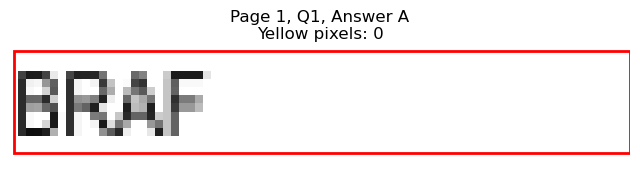

Page 1, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=129.1, y1=123.0
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 216
Page 1, Q1, B: Yellow percentage: 0.0%


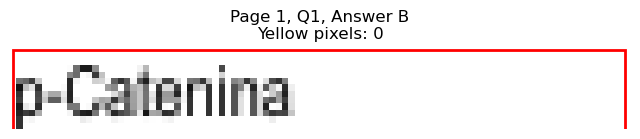

Page 1, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=107.1, y1=135.6
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 117
Page 1, Q1, C: Yellow percentage: 0.0%


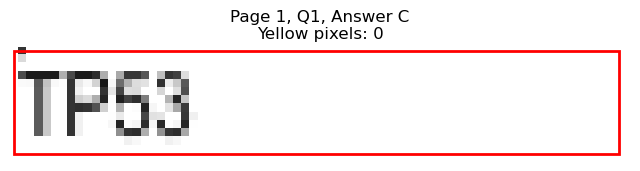

Page 1, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=355.1, y1=110.4
Page 1, Q1, D: Yellow pixels: 778
Page 1, Q1, D: Total non-white pixels: 1008
Page 1, Q1, D: Yellow percentage: 77.2%


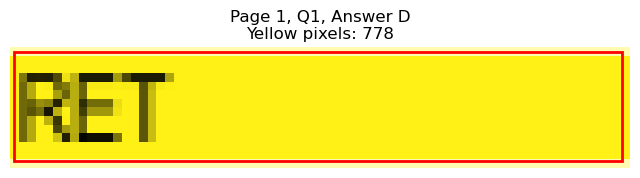

Page 1, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=355.3, y1=123.0
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 178
Page 1, Q1, E: Yellow percentage: 0.0%


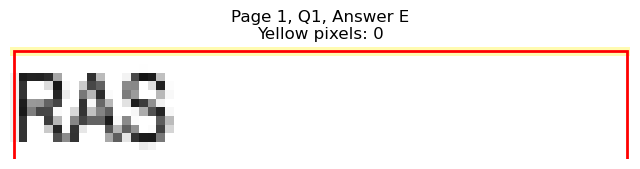


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=125.5, y1=198.7
Page 1, Q2, A: Yellow pixels: 3
Page 1, Q2, A: Total non-white pixels: 328
Page 1, Q2, A: Yellow percentage: 0.9%


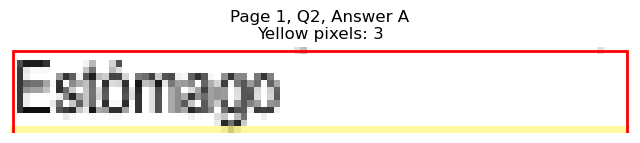

Page 1, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=157.7, y1=211.3
Page 1, Q2, B: Yellow pixels: 1226
Page 1, Q2, B: Total non-white pixels: 1764
Page 1, Q2, B: Yellow percentage: 69.5%


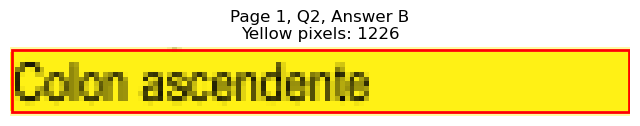

Page 1, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=122.1, y1=224.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 268
Page 1, Q2, C: Yellow percentage: 0.0%


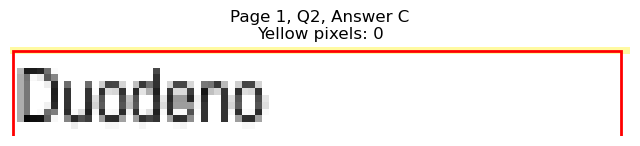

Page 1, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=370.3, y1=198.7
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 186
Page 1, Q2, D: Yellow percentage: 0.0%


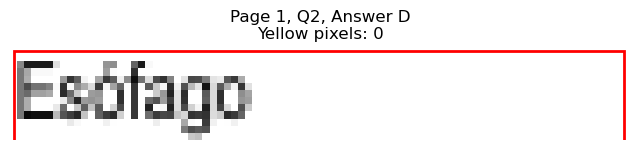

Page 1, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=360.2, y1=211.3
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 127
Page 1, Q2, E: Yellow percentage: 0.0%


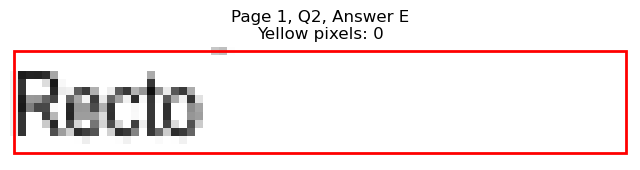


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=150.6, y1=274.4
Page 1, Q3, A: Yellow pixels: 1287
Page 1, Q3, A: Total non-white pixels: 1666
Page 1, Q3, A: Yellow percentage: 77.3%


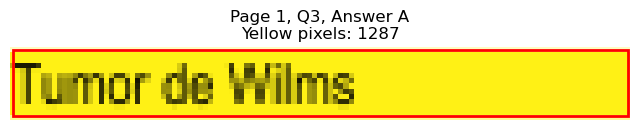

Page 1, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=146.2, y1=287.1
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 343
Page 1, Q3, B: Yellow percentage: 0.0%


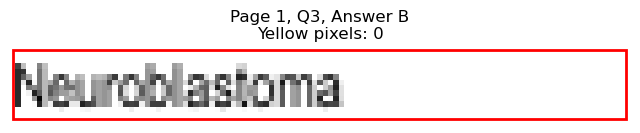

Page 1, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=152.7, y1=299.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 353
Page 1, Q3, C: Yellow percentage: 0.0%


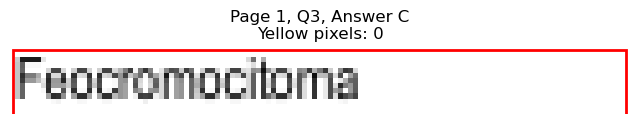

Page 1, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=399.8, y1=274.4
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 337
Page 1, Q3, D: Yellow percentage: 0.0%


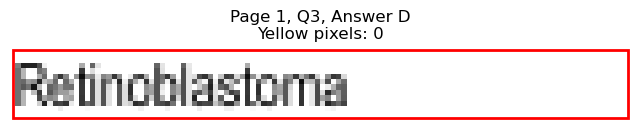

Page 1, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=412.4, y1=287.1
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 394
Page 1, Q3, E: Yellow percentage: 0.0%


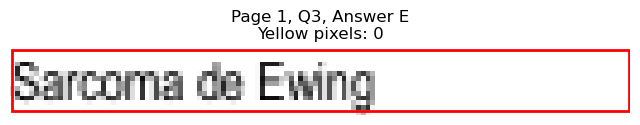


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=168.3, y1=350.1
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 428
Page 1, Q4, A: Yellow percentage: 0.0%


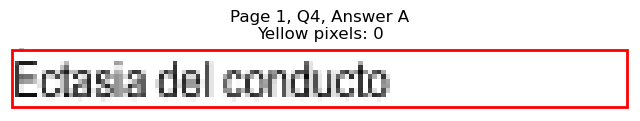

Page 1, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=143.2, y1=362.9
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 320
Page 1, Q4, B: Yellow percentage: 0.0%


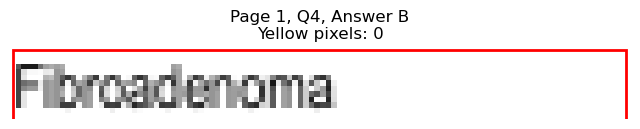

Page 1, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=229.4, y1=375.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 743
Page 1, Q4, C: Yellow percentage: 0.0%


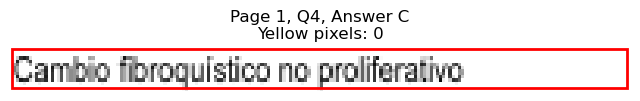

Page 1, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=417.9, y1=350.1
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 447
Page 1, Q4, D: Yellow percentage: 0.0%


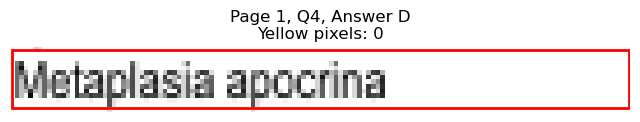

Page 1, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=427.4, y1=362.9
Page 1, Q4, E: Yellow pixels: 1505
Page 1, Q4, E: Total non-white pixels: 1872
Page 1, Q4, E: Yellow percentage: 80.4%


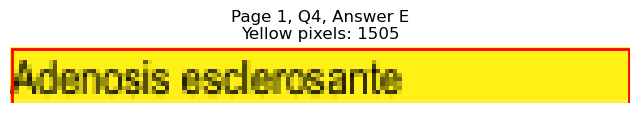


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=221.3, y1=438.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 715
Page 1, Q5, A: Yellow percentage: 0.0%


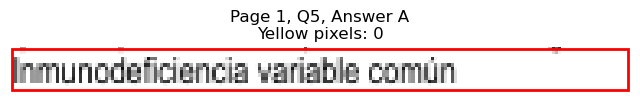

Page 1, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=177.7, y1=451.2
Page 1, Q5, B: Yellow pixels: 146
Page 1, Q5, B: Total non-white pixels: 638
Page 1, Q5, B: Yellow percentage: 22.9%


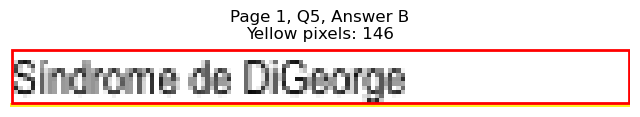

Page 1, Q5 - C: Detected box: x0=82.9, y0=451.1, x1=213.9, y1=463.8
Page 1, Q5, C: Yellow pixels: 1800
Page 1, Q5, C: Total non-white pixels: 2366
Page 1, Q5, C: Yellow percentage: 76.1%


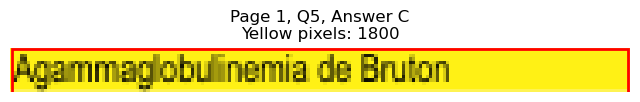

Page 1, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=429.4, y1=438.6
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 494
Page 1, Q5, D: Yellow percentage: 0.0%


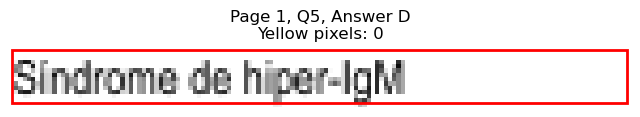

Page 1, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=481.2, y1=451.2
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 722
Page 1, Q5, E: Yellow percentage: 0.0%


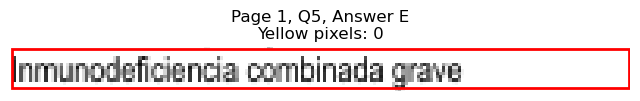


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=514.3, x1=145.1, y1=526.9
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 438
Page 1, Q6, A: Yellow percentage: 0.0%


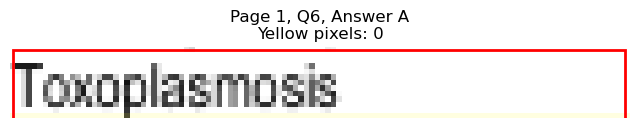

Page 1, Q6 - B: Detected box: x0=82.5, y0=526.9, x1=158.2, y1=539.5
Page 1, Q6, B: Yellow pixels: 1360
Page 1, Q6, B: Total non-white pixels: 1778
Page 1, Q6, B: Yellow percentage: 76.5%


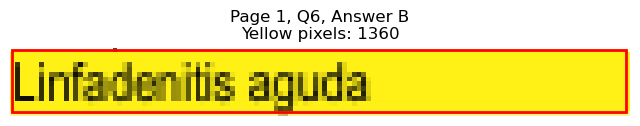

Page 1, Q6 - C: Detected box: x0=82.9, y0=539.5, x1=201.9, y1=552.1
Page 1, Q6, C: Yellow pixels: 168
Page 1, Q6, C: Total non-white pixels: 799
Page 1, Q6, C: Yellow percentage: 21.0%


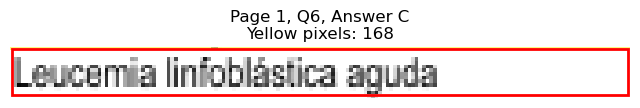

Page 1, Q6 - D: Detected box: x0=334.6, y0=514.3, x1=469.7, y1=526.9
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 674
Page 1, Q6, D: Yellow percentage: 0.0%


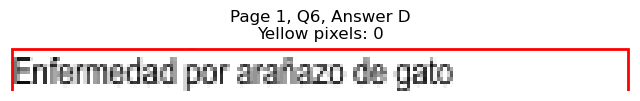

Page 1, Q6 - E: Detected box: x0=334.1, y0=526.9, x1=402.3, y1=539.5
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 352
Page 1, Q6, E: Yellow percentage: 0.0%


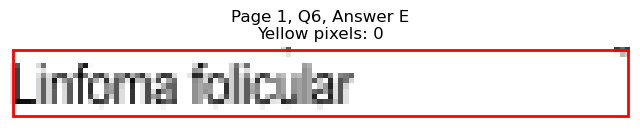


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=145.7, y1=590.0
Page 1, Q7, A: Yellow pixels: 114
Page 1, Q7, A: Total non-white pixels: 552
Page 1, Q7, A: Yellow percentage: 20.7%


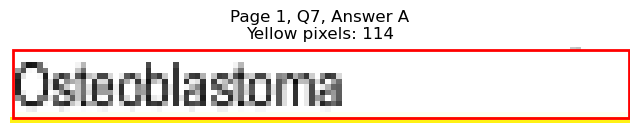

Page 1, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=151.2, y1=602.6
Page 1, Q7, B: Yellow pixels: 1265
Page 1, Q7, B: Total non-white pixels: 1680
Page 1, Q7, B: Yellow percentage: 75.3%


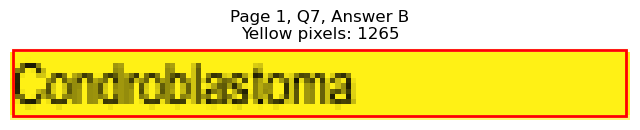

Page 1, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=158.7, y1=615.2
Page 1, Q7, C: Yellow pixels: 127
Page 1, Q7, C: Total non-white pixels: 520
Page 1, Q7, C: Yellow percentage: 24.4%


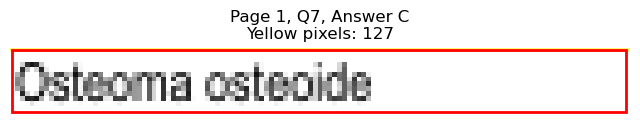

Page 1, Q7 - D: Detected box: x0=334.6, y0=577.4, x1=388.3, y1=590.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 257
Page 1, Q7, D: Yellow percentage: 0.0%


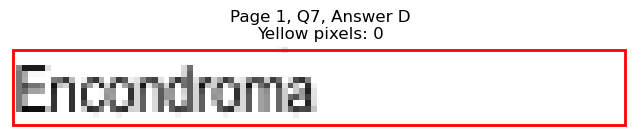

Page 1, Q7 - E: Detected box: x0=334.1, y0=590.0, x1=402.9, y1=602.6
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 370
Page 1, Q7, E: Yellow percentage: 0.0%


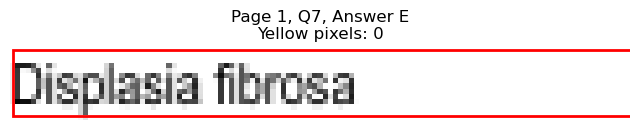


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=678.3, x1=224.0, y1=691.0
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 710
Page 1, Q8, A: Yellow percentage: 0.0%


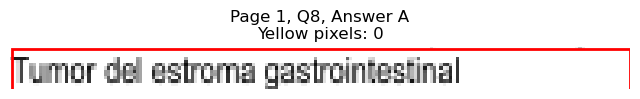

Page 1, Q8 - B: Detected box: x0=82.5, y0=691.1, x1=125.5, y1=703.7
Page 1, Q8, B: Yellow pixels: 3
Page 1, Q8, B: Total non-white pixels: 343
Page 1, Q8, B: Yellow percentage: 0.9%


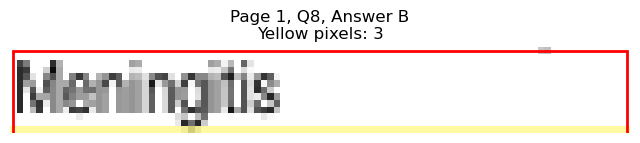

Page 1, Q8 - C: Detected box: x0=82.9, y0=703.7, x1=178.7, y1=716.3
Page 1, Q8, C: Yellow pixels: 1387
Page 1, Q8, C: Total non-white pixels: 2058
Page 1, Q8, C: Yellow percentage: 67.4%


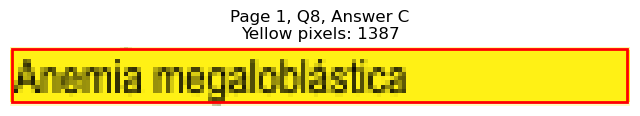

Page 1, Q8 - D: Detected box: x0=334.6, y0=678.3, x1=412.4, y1=691.0
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 411
Page 1, Q8, D: Yellow percentage: 0.0%


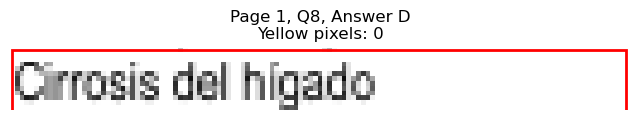

Page 1, Q8 - E: Detected box: x0=334.1, y0=691.1, x1=414.9, y1=703.7
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 429
Page 1, Q8, E: Yellow percentage: 0.0%


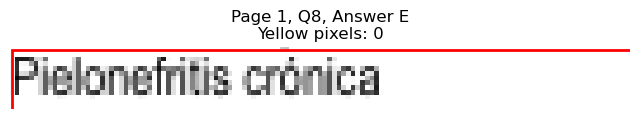


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=265.5, y1=148.2
Page 2, Q1, A: Yellow pixels: 1788
Page 2, Q1, A: Total non-white pixels: 2702
Page 2, Q1, A: Yellow percentage: 66.2%


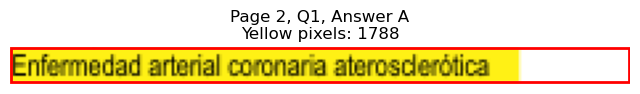

Page 2, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=191.8, y1=160.9
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 696
Page 2, Q1, B: Yellow percentage: 0.0%


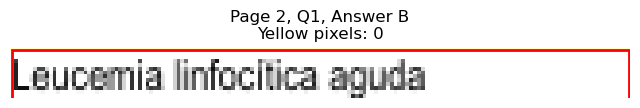

Page 2, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=165.7, y1=173.5
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 425
Page 2, Q1, C: Yellow percentage: 0.0%


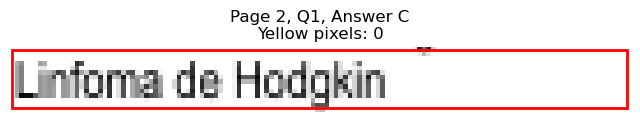

Page 2, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=402.8, y1=148.2
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 336
Page 2, Q1, D: Yellow percentage: 0.0%


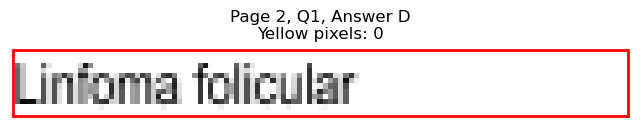

Page 2, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=434.0, y1=160.9
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 533
Page 2, Q1, E: Yellow percentage: 0.0%


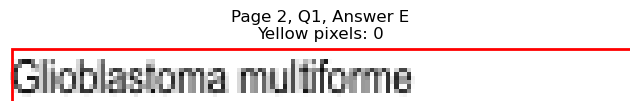


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=245.4, y1=224.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 856
Page 2, Q2, A: Yellow percentage: 0.0%


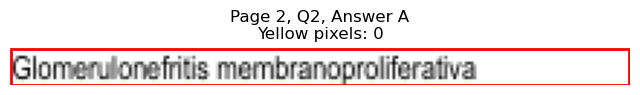

Page 2, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=201.9, y1=236.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 606
Page 2, Q2, B: Yellow percentage: 0.0%


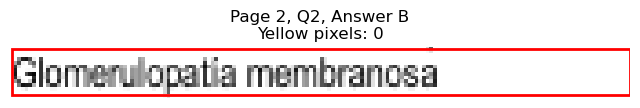

Page 2, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=219.9, y1=249.2
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 693
Page 2, Q2, C: Yellow percentage: 0.0%


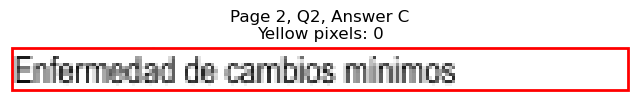

Page 2, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=502.7, y1=224.0
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 1070
Page 2, Q2, D: Yellow percentage: 0.0%


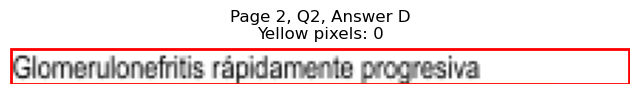

Page 2, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=499.2, y1=236.6
Page 2, Q2, E: Yellow pixels: 1850
Page 2, Q2, E: Total non-white pixels: 2688
Page 2, Q2, E: Yellow percentage: 68.8%


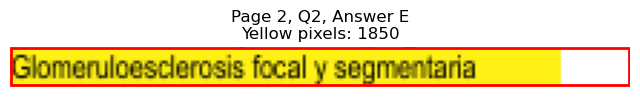


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=226.8, y1=324.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 771
Page 2, Q3, A: Yellow percentage: 0.0%


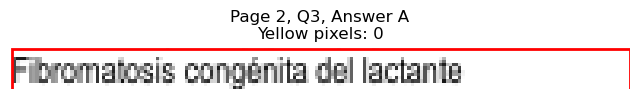

Page 2, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=178.2, y1=337.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 515
Page 2, Q3, B: Yellow percentage: 0.0%


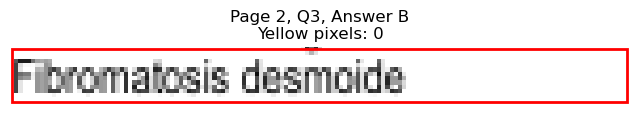

Page 2, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=247.0, y1=350.1
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 849
Page 2, Q3, C: Yellow percentage: 0.0%


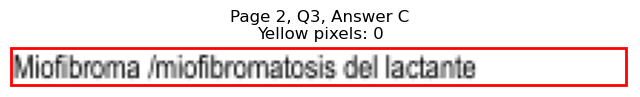

Page 2, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=452.5, y1=324.9
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 771
Page 2, Q3, D: Yellow percentage: 0.0%


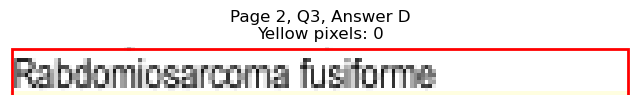

Page 2, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=440.5, y1=337.5
Page 2, Q3, E: Yellow pixels: 1638
Page 2, Q3, E: Total non-white pixels: 2198
Page 2, Q3, E: Yellow percentage: 74.5%


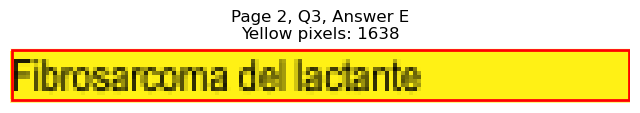


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=200.8, y1=400.7
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 572
Page 2, Q4, A: Yellow percentage: 0.0%


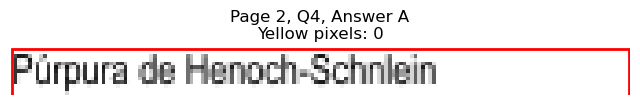

Page 2, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=161.7, y1=413.3
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 388
Page 2, Q4, B: Yellow percentage: 0.0%


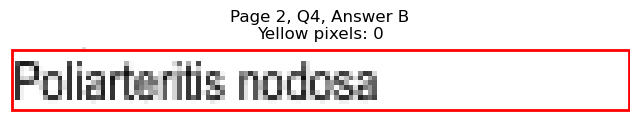

Page 2, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=173.2, y1=426.0
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 460
Page 2, Q4, C: Yellow percentage: 0.0%


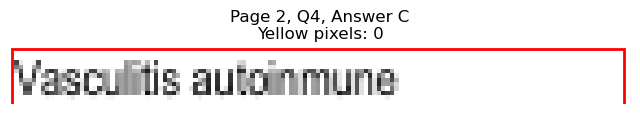

Page 2, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=404.3, y1=400.7
Page 2, Q4, D: Yellow pixels: 3
Page 2, Q4, D: Total non-white pixels: 508
Page 2, Q4, D: Yellow percentage: 0.6%


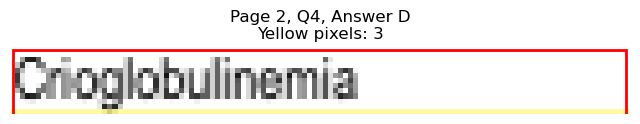

Page 2, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=470.1, y1=413.3
Page 2, Q4, E: Yellow pixels: 1711
Page 2, Q4, E: Total non-white pixels: 2618
Page 2, Q4, E: Yellow percentage: 65.4%


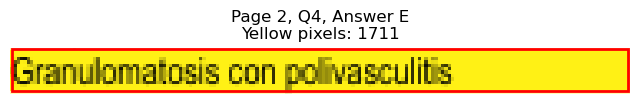


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=149.2, y1=489.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 347
Page 2, Q5, A: Yellow percentage: 0.0%


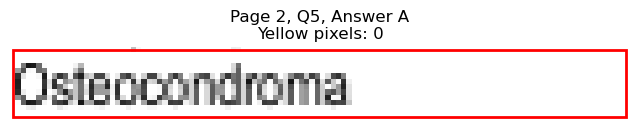

Page 2, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=149.2, y1=501.7
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 336
Page 2, Q5, B: Yellow percentage: 0.0%


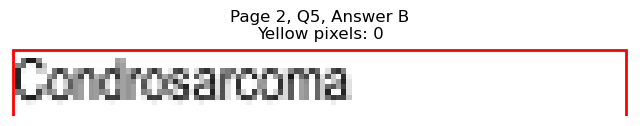

Page 2, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=191.3, y1=514.3
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 546
Page 2, Q5, C: Yellow percentage: 0.0%


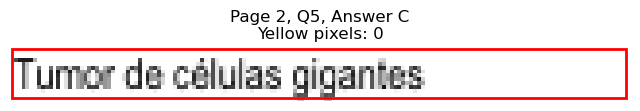

Page 2, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=395.8, y1=489.0
Page 2, Q5, D: Yellow pixels: 1220
Page 2, Q5, D: Total non-white pixels: 1568
Page 2, Q5, D: Yellow percentage: 77.8%


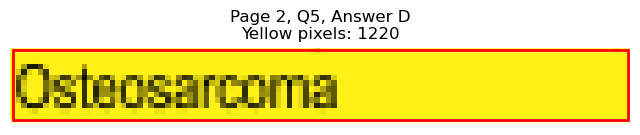

Page 2, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=412.4, y1=501.7
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 523
Page 2, Q5, E: Yellow percentage: 0.0%


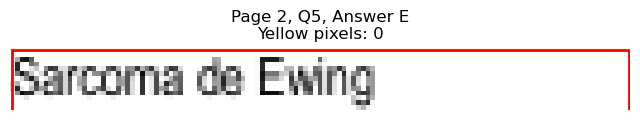


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=552.2, x1=167.2, y1=564.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 559
Page 2, Q6, A: Yellow percentage: 0.0%


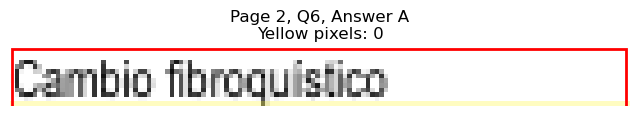

Page 2, Q6 - B: Detected box: x0=82.5, y0=564.8, x1=156.1, y1=577.4
Page 2, Q6, B: Yellow pixels: 1222
Page 2, Q6, B: Total non-white pixels: 1750
Page 2, Q6, B: Yellow percentage: 69.8%


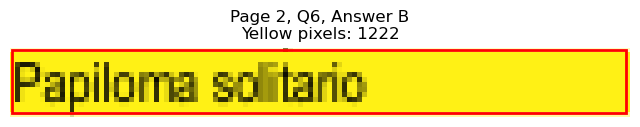

Page 2, Q6 - C: Detected box: x0=82.9, y0=577.4, x1=194.8, y1=590.0
Page 2, Q6, C: Yellow pixels: 1
Page 2, Q6, C: Total non-white pixels: 742
Page 2, Q6, C: Yellow percentage: 0.1%


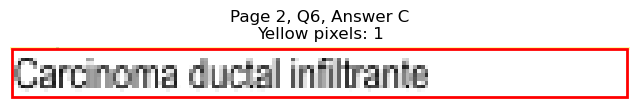

Page 2, Q6 - D: Detected box: x0=334.6, y0=552.2, x1=455.5, y1=564.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 628
Page 2, Q6, D: Yellow percentage: 0.0%


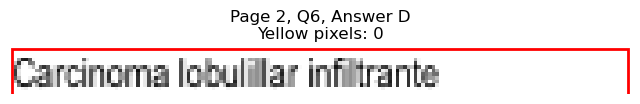

Page 2, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=394.9, y1=577.4
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 300
Page 2, Q6, E: Yellow percentage: 0.0%


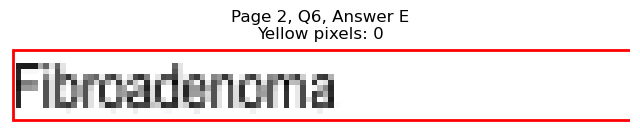


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=627.9, x1=178.7, y1=640.6
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 473
Page 2, Q7, A: Yellow percentage: 0.0%


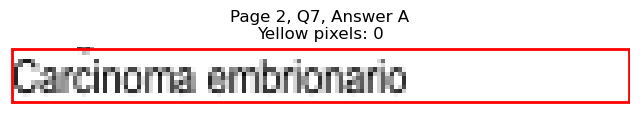

Page 2, Q7 - B: Detected box: x0=82.5, y0=640.5, x1=148.1, y1=653.2
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 329
Page 2, Q7, B: Yellow percentage: 0.0%


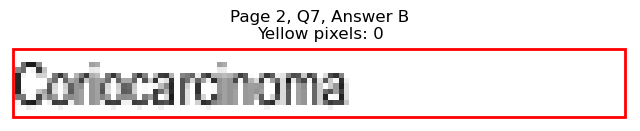

Page 2, Q7 - C: Detected box: x0=82.9, y0=653.1, x1=124.1, y1=665.8
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 195
Page 2, Q7, C: Yellow percentage: 0.0%


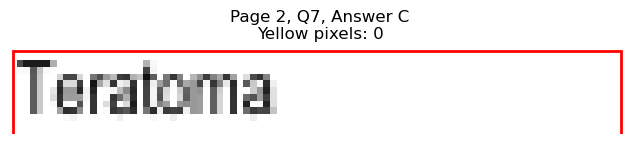

Page 2, Q7 - D: Detected box: x0=334.6, y0=135.5, x1=369.3, y1=148.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 336
Page 2, Q7, D: Yellow percentage: 0.0%


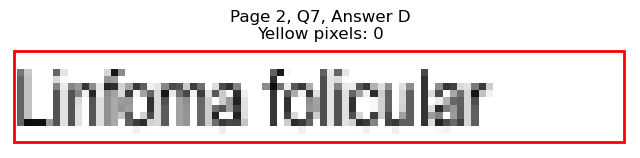

Page 2, Q7 - E: Detected box: x0=334.1, y0=640.5, x1=379.7, y1=653.2
Page 2, Q7, E: Yellow pixels: 96
Page 2, Q7, E: Total non-white pixels: 327
Page 2, Q7, E: Yellow percentage: 29.4%


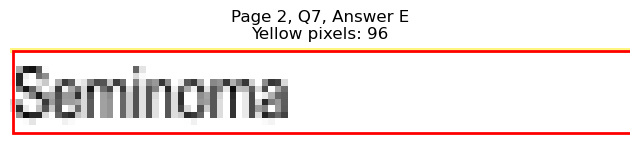


Page 2, Q7 - Selected Answer: E (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=162.7, y1=703.7
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 535
Page 2, Q8, A: Yellow percentage: 0.0%


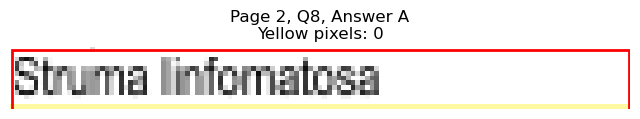

Page 2, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=180.7, y1=716.3
Page 2, Q8, B: Yellow pixels: 1412
Page 2, Q8, B: Total non-white pixels: 2086
Page 2, Q8, B: Yellow percentage: 67.7%


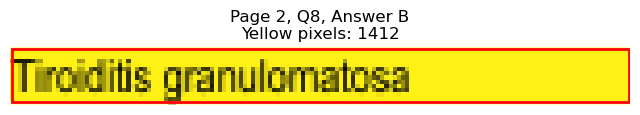

Page 2, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=146.7, y1=728.9
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 434
Page 2, Q8, C: Yellow percentage: 0.0%


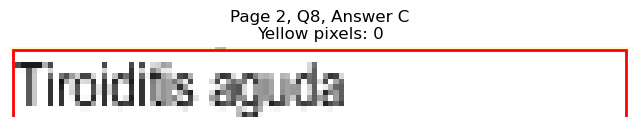

Page 2, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=428.9, y1=703.7
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 479
Page 2, Q8, D: Yellow percentage: 0.0%


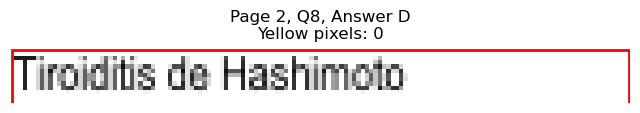

Page 2, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=419.9, y1=716.3
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 432
Page 2, Q8, E: Yellow percentage: 0.0%


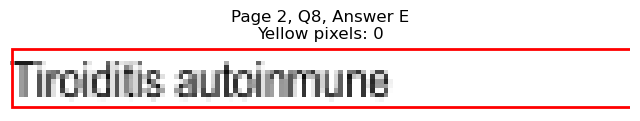


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=163.2, y1=110.4
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 450
Page 3, Q1, A: Yellow percentage: 0.0%


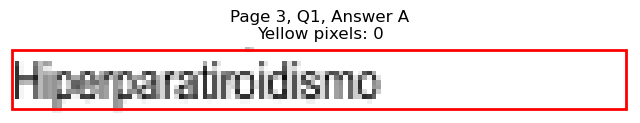

Page 3, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=184.8, y1=123.0
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 543
Page 3, Q1, B: Yellow percentage: 0.0%


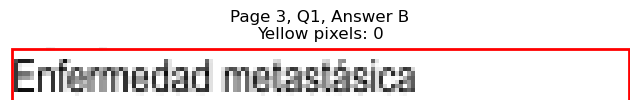

Page 3, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=119.5, y1=135.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 182
Page 3, Q1, C: Yellow percentage: 0.0%


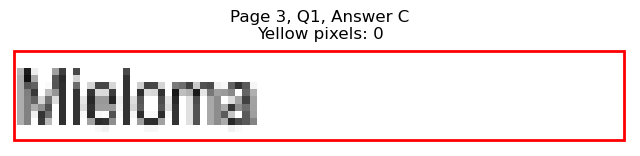

Page 3, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=383.8, y1=110.4
Page 3, Q1, D: Yellow pixels: 100
Page 3, Q1, D: Total non-white pixels: 356
Page 3, Q1, D: Yellow percentage: 28.1%


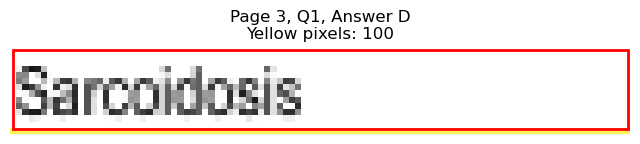

Page 3, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=362.2, y1=123.0
Page 3, Q1, E: Yellow pixels: 922
Page 3, Q1, E: Total non-white pixels: 1027
Page 3, Q1, E: Yellow percentage: 89.8%


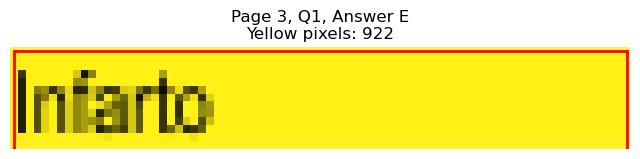


Page 3, Q1 - Selected Answer: E (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=150.1, y1=173.5
Page 3, Q2, A: Yellow pixels: 1291
Page 3, Q2, A: Total non-white pixels: 1666
Page 3, Q2, A: Yellow percentage: 77.5%


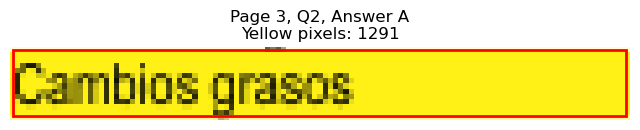

Page 3, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=208.8, y1=186.1
Page 3, Q2, B: Yellow pixels: 176
Page 3, Q2, B: Total non-white pixels: 787
Page 3, Q2, B: Yellow percentage: 22.4%


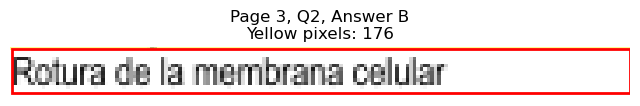

Page 3, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=125.1, y1=198.7
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 233
Page 3, Q2, C: Yellow percentage: 0.0%


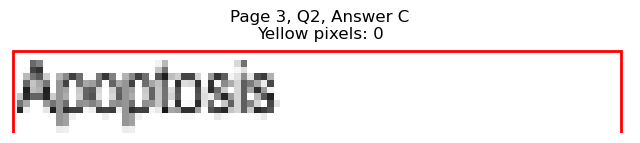

Page 3, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=473.1, y1=173.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 663
Page 3, Q2, D: Yellow percentage: 0.0%


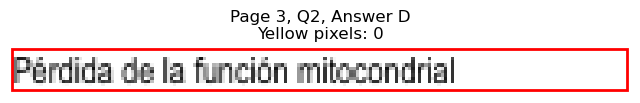

Page 3, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=380.2, y1=186.1
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 234
Page 3, Q2, E: Yellow percentage: 0.0%


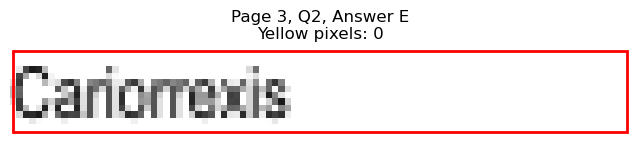


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=142.1, y1=287.1
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 322
Page 3, Q3, A: Yellow percentage: 0.0%


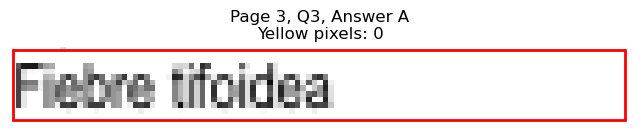

Page 3, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=129.1, y1=299.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 253
Page 3, Q3, B: Yellow percentage: 0.0%


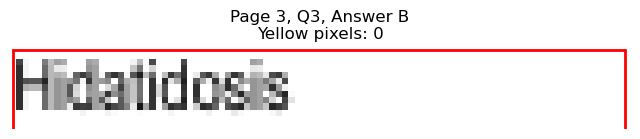

Page 3, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=121.1, y1=312.3
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 183
Page 3, Q3, C: Yellow percentage: 0.0%


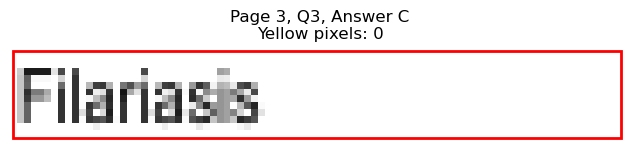

Page 3, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=363.7, y1=287.1
Page 3, Q3, D: Yellow pixels: 920
Page 3, Q3, D: Total non-white pixels: 1120
Page 3, Q3, D: Yellow percentage: 82.1%


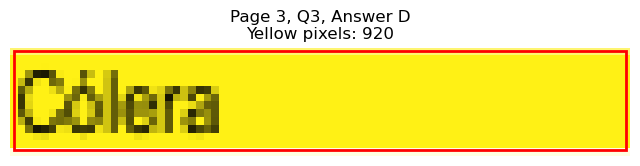

Page 3, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=378.3, y1=299.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 333
Page 3, Q3, E: Yellow percentage: 0.0%


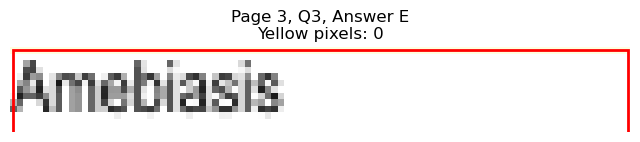


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=125.7, y1=388.1
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 197
Page 3, Q4, A: Yellow percentage: 0.0%


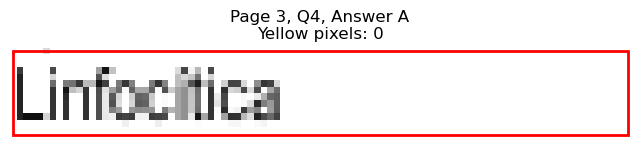

Page 3, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=120.6, y1=400.7
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 194
Page 3, Q4, B: Yellow percentage: 0.0%


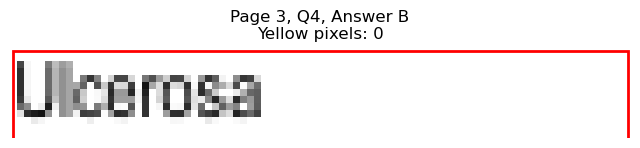

Page 3, Q4 - C: Detected box: x0=82.9, y0=400.6, x1=126.6, y1=413.3
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 226
Page 3, Q4, C: Yellow percentage: 0.0%


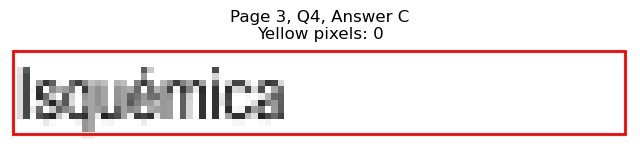

Page 3, Q4 - D: Detected box: x0=334.6, y0=375.4, x1=385.3, y1=388.1
Page 3, Q4, D: Yellow pixels: 1117
Page 3, Q4, D: Total non-white pixels: 1428
Page 3, Q4, D: Yellow percentage: 78.2%


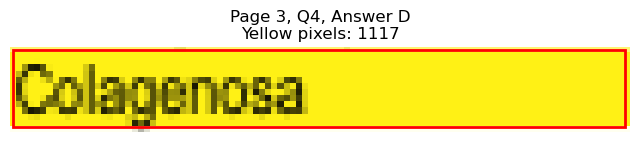

Page 3, Q4 - E: Detected box: x0=334.1, y0=388.0, x1=389.8, y1=400.7
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 375
Page 3, Q4, E: Yellow percentage: 0.0%


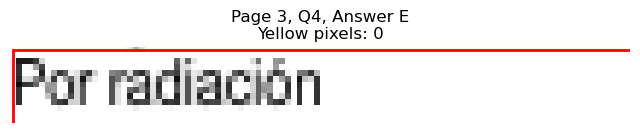


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=121.6, y1=451.2
Page 3, Q5, A: Yellow pixels: 90
Page 3, Q5, A: Total non-white pixels: 293
Page 3, Q5, A: Yellow percentage: 30.7%


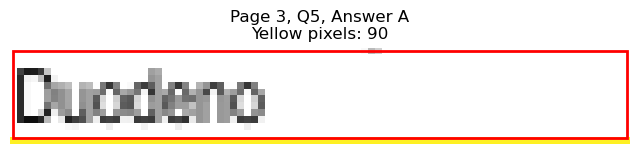

Page 3, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=125.5, y1=463.8
Page 3, Q5, B: Yellow pixels: 1042
Page 3, Q5, B: Total non-white pixels: 1222
Page 3, Q5, B: Yellow percentage: 85.3%


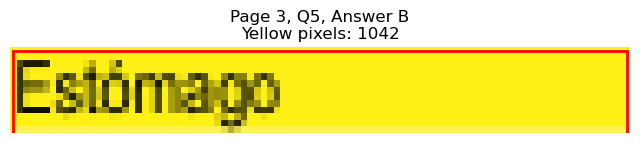

Page 3, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=118.6, y1=476.4
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 205
Page 3, Q5, C: Yellow percentage: 0.0%


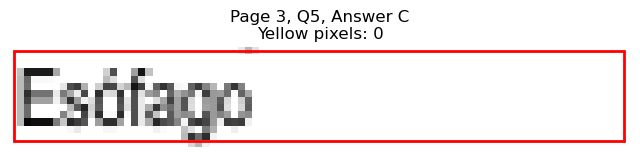

Page 3, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=356.7, y1=451.2
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 118
Page 3, Q5, D: Yellow percentage: 0.0%


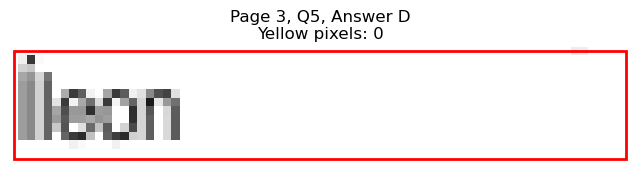

Page 3, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=360.2, y1=463.8
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 122
Page 3, Q5, E: Yellow percentage: 0.0%


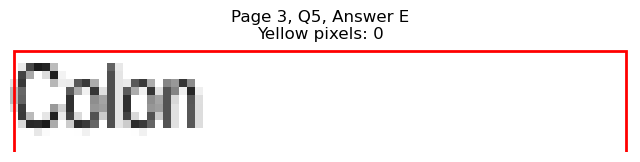


Page 3, Q5 - Selected Answer: B (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=102.5, y1=514.3
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 90
Page 3, Q6, A: Yellow percentage: 0.0%


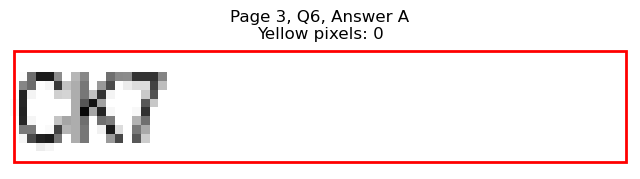

Page 3, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=107.5, y1=526.9
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 125
Page 3, Q6, B: Yellow percentage: 0.0%


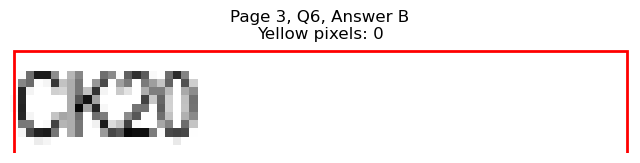

Page 3, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=117.0, y1=539.5
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 148
Page 3, Q6, C: Yellow percentage: 0.0%


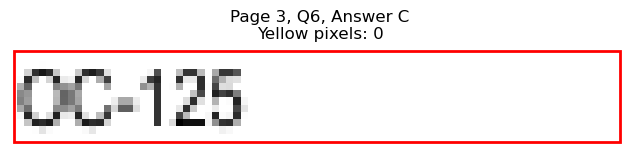

Page 3, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=359.2, y1=514.3
Page 3, Q6, D: Yellow pixels: 76
Page 3, Q6, D: Total non-white pixels: 172
Page 3, Q6, D: Yellow percentage: 44.2%


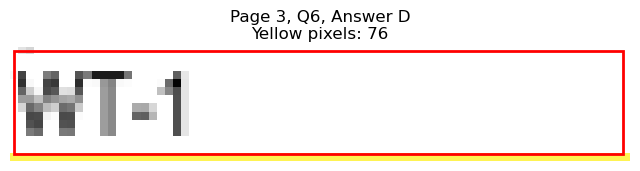

Page 3, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=379.7, y1=526.9
Page 3, Q6, E: Yellow pixels: 1064
Page 3, Q6, E: Total non-white pixels: 1248
Page 3, Q6, E: Yellow percentage: 85.3%


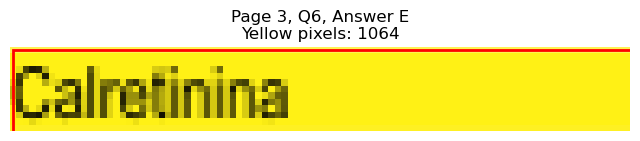


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=207.9, y1=615.2
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 665
Page 3, Q7, A: Yellow percentage: 0.0%


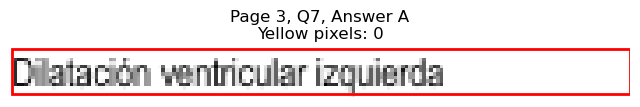

Page 3, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=236.9, y1=627.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 777
Page 3, Q7, B: Yellow percentage: 0.0%


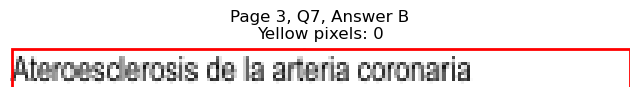

Page 3, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=210.4, y1=640.6
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 658
Page 3, Q7, C: Yellow percentage: 0.0%


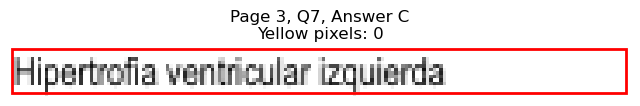

Page 3, Q7 - D: Detected box: x0=377.8, y0=602.6, x1=434.4, y1=615.2
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 502
Page 3, Q7, D: Yellow percentage: 0.0%


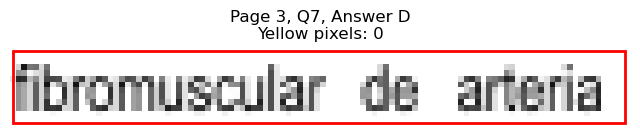

Page 3, Q7 - E: Detected box: x0=334.1, y0=627.9, x1=457.5, y1=640.6
Page 3, Q7, E: Yellow pixels: 1759
Page 3, Q7, E: Total non-white pixels: 2436
Page 3, Q7, E: Yellow percentage: 72.2%


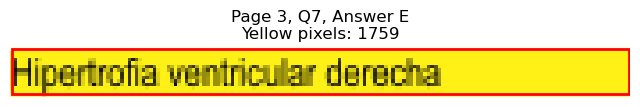


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=309.6, y1=703.7
Page 3, Q8, A: Yellow pixels: 2753
Page 3, Q8, A: Total non-white pixels: 3614
Page 3, Q8, A: Yellow percentage: 76.2%


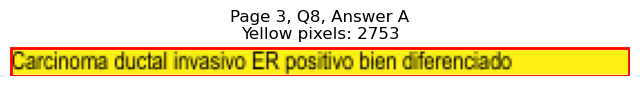

Page 3, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=419.0, y1=716.3
Page 3, Q8, B: Yellow pixels: 387
Page 3, Q8, B: Total non-white pixels: 2061
Page 3, Q8, B: Yellow percentage: 18.8%


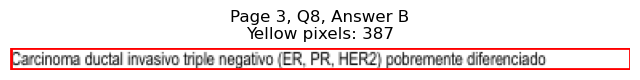

Page 3, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=416.0, y1=728.9
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 1668
Page 3, Q8, C: Yellow percentage: 0.0%


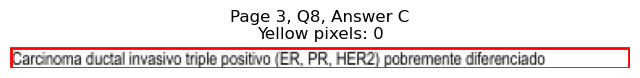

Page 3, Q8 - D: Detected box: x0=82.9, y0=728.9, x1=390.9, y1=741.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 1582
Page 3, Q8, D: Yellow percentage: 0.0%


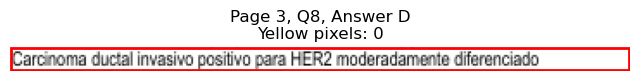

Page 3, Q8 - E: Detected box: x0=82.5, y0=741.4, x1=316.1, y1=754.1
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 1211
Page 3, Q8, E: Yellow percentage: 0.0%


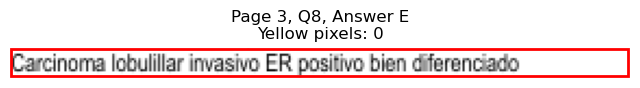


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 7 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=148.2, x1=149.2, y1=160.9
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 337
Page 4, Q1, A: Yellow percentage: 0.0%


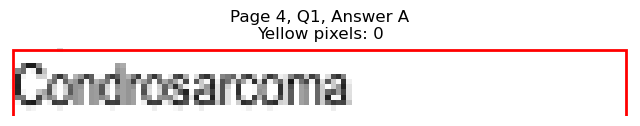

Page 4, Q1 - B: Detected box: x0=82.5, y0=160.8, x1=149.2, y1=173.5
Page 4, Q1, B: Yellow pixels: 118
Page 4, Q1, B: Total non-white pixels: 461
Page 4, Q1, B: Yellow percentage: 25.6%


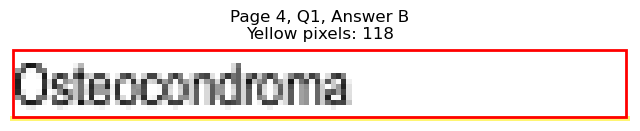

Page 4, Q1 - C: Detected box: x0=82.9, y0=173.4, x1=224.4, y1=186.1
Page 4, Q1, C: Yellow pixels: 1960
Page 4, Q1, C: Total non-white pixels: 2701
Page 4, Q1, C: Yellow percentage: 72.6%


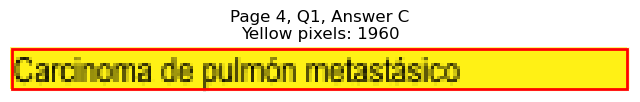

Page 4, Q1 - D: Detected box: x0=334.6, y0=148.2, x1=412.9, y1=160.9
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 381
Page 4, Q1, D: Yellow percentage: 0.0%


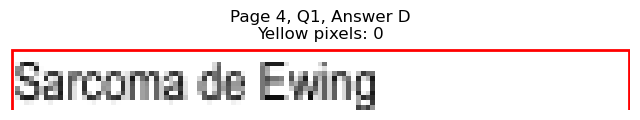

Page 4, Q1 - E: Detected box: x0=334.1, y0=160.8, x1=389.8, y1=173.5
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 305
Page 4, Q1, E: Yellow percentage: 0.0%


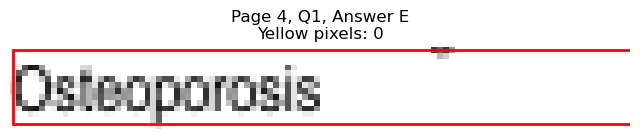


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=313.2, y1=236.6
Page 4, Q2, A: Yellow pixels: 2754
Page 4, Q2, A: Total non-white pixels: 3948
Page 4, Q2, A: Yellow percentage: 69.8%


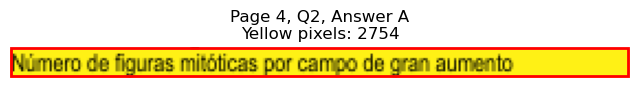

Page 4, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=158.2, y1=249.2
Page 4, Q2, B: Yellow pixels: 126
Page 4, Q2, B: Total non-white pixels: 484
Page 4, Q2, B: Yellow percentage: 26.0%


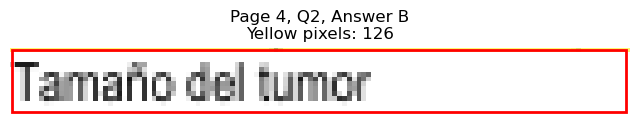

Page 4, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=246.5, y1=261.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 805
Page 4, Q2, C: Yellow percentage: 0.0%


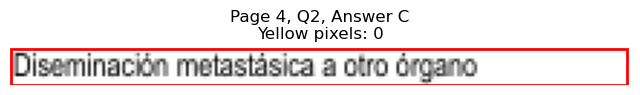

Page 4, Q2 - D: Detected box: x0=82.9, y0=261.7, x1=268.6, y1=274.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 902
Page 4, Q2, D: Yellow percentage: 0.0%


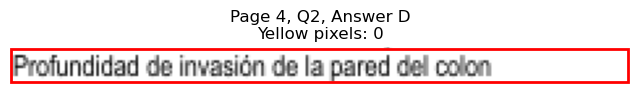

Page 4, Q2 - E: Detected box: x0=82.5, y0=274.5, x1=241.0, y1=287.1
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 836
Page 4, Q2, E: Yellow percentage: 0.0%


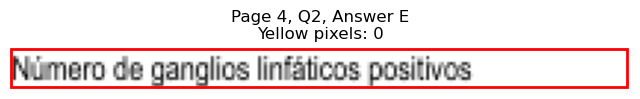


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=350.2, x1=144.4, y1=362.9
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 272
Page 4, Q3, A: Yellow percentage: 0.0%


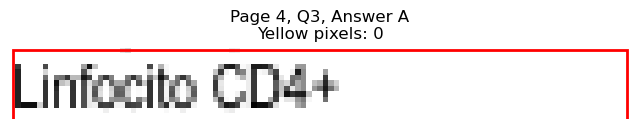

Page 4, Q3 - B: Detected box: x0=82.5, y0=362.8, x1=127.1, y1=375.5
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 192
Page 4, Q3, B: Yellow percentage: 0.0%


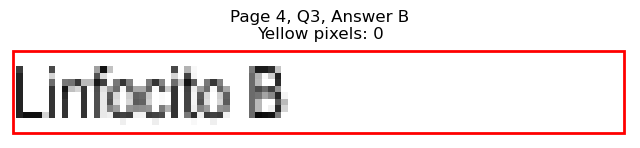

Page 4, Q3 - C: Detected box: x0=82.9, y0=375.4, x1=128.1, y1=388.1
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 239
Page 4, Q3, C: Yellow percentage: 0.0%


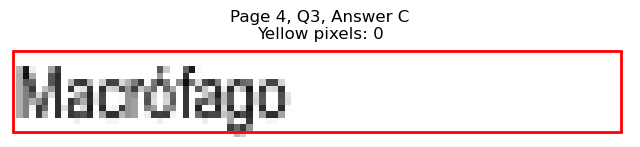

Page 4, Q3 - D: Detected box: x0=334.6, y0=350.2, x1=435.9, y1=362.9
Page 4, Q3, D: Yellow pixels: 1614
Page 4, Q3, D: Total non-white pixels: 1976
Page 4, Q3, D: Yellow percentage: 81.7%


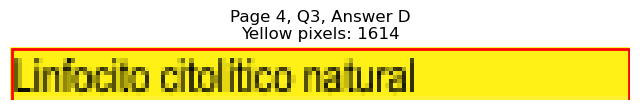

Page 4, Q3 - E: Detected box: x0=334.1, y0=362.8, x1=404.3, y1=375.5
Page 4, Q3, E: Yellow pixels: 121
Page 4, Q3, E: Total non-white pixels: 488
Page 4, Q3, E: Yellow percentage: 24.8%


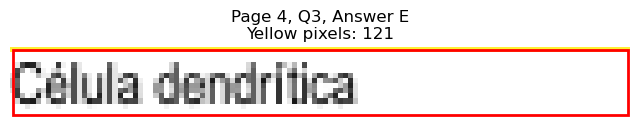


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=451.1, x1=221.9, y1=463.8
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 764
Page 4, Q4, A: Yellow percentage: 0.0%


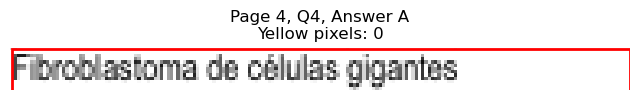

Page 4, Q4 - B: Detected box: x0=82.5, y0=463.7, x1=153.1, y1=476.4
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 393
Page 4, Q4, B: Yellow percentage: 0.0%


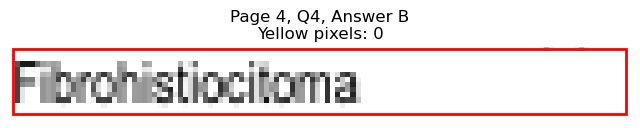

Page 4, Q4 - C: Detected box: x0=82.9, y0=476.3, x1=202.8, y1=489.0
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 607
Page 4, Q4, C: Yellow percentage: 0.0%


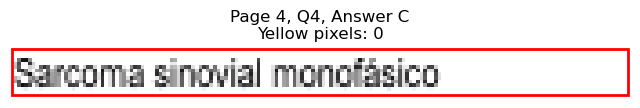

Page 4, Q4 - D: Detected box: x0=334.6, y0=451.1, x1=423.9, y1=463.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 596
Page 4, Q4, D: Yellow percentage: 0.0%


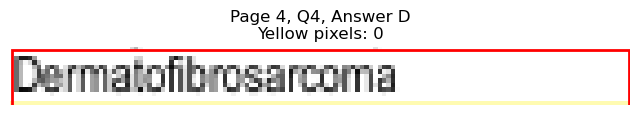

Page 4, Q4 - E: Detected box: x0=334.1, y0=463.7, x1=469.5, y1=476.4
Page 4, Q4, E: Yellow pixels: 1655
Page 4, Q4, E: Total non-white pixels: 2604
Page 4, Q4, E: Yellow percentage: 63.6%


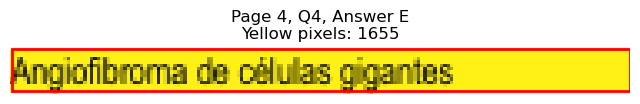


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=514.3, x1=192.7, y1=526.9
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 575
Page 4, Q5, A: Yellow percentage: 0.0%


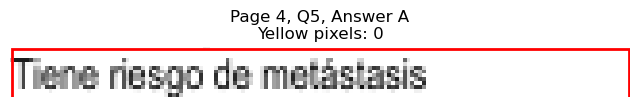

Page 4, Q5 - B: Detected box: x0=82.5, y0=526.9, x1=243.5, y1=539.5
Page 4, Q5, B: Yellow pixels: 192
Page 4, Q5, B: Total non-white pixels: 1013
Page 4, Q5, B: Yellow percentage: 19.0%


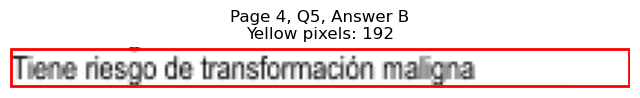

Page 4, Q5 - C: Detected box: x0=82.9, y0=539.5, x1=189.3, y1=552.1
Page 4, Q5, C: Yellow pixels: 1651
Page 4, Q5, C: Total non-white pixels: 2212
Page 4, Q5, C: Yellow percentage: 74.6%


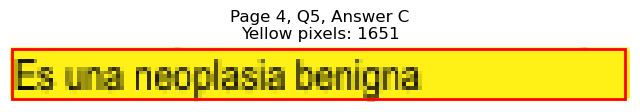

Page 4, Q5 - D: Detected box: x0=334.6, y0=514.3, x1=420.9, y1=526.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 428
Page 4, Q5, D: Yellow percentage: 0.0%


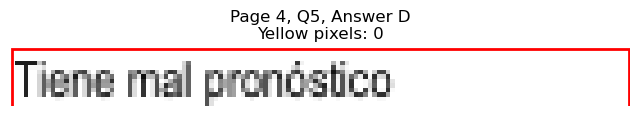

Page 4, Q5 - E: Detected box: x0=334.1, y0=526.9, x1=449.0, y1=539.5
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 587
Page 4, Q5, E: Yellow percentage: 0.0%


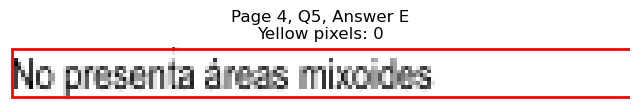


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=95.1, y1=590.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 29
Page 4, Q6, A: Yellow percentage: 0.0%


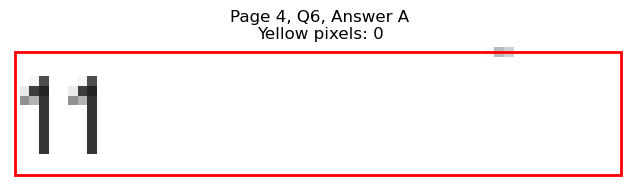

Page 4, Q6 - B: Detected box: x0=70.8, y0=590.0, x1=79.3, y1=602.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 79
Page 4, Q6, B: Yellow percentage: 0.0%


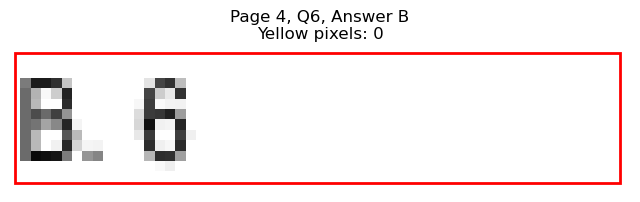

Page 4, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=95.5, y1=615.2
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 59
Page 4, Q6, C: Yellow percentage: 0.0%


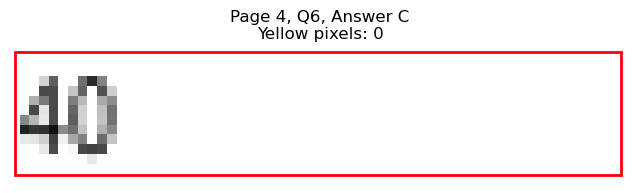

Page 4, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=347.2, y1=590.0
Page 4, Q6, D: Yellow pixels: 64
Page 4, Q6, D: Total non-white pixels: 185
Page 4, Q6, D: Yellow percentage: 34.6%


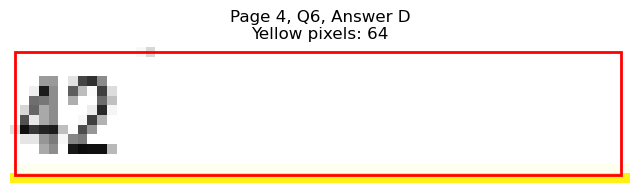

Page 4, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=346.7, y1=602.6
Page 4, Q6, E: Yellow pixels: 780
Page 4, Q6, E: Total non-white pixels: 882
Page 4, Q6, E: Yellow percentage: 88.4%


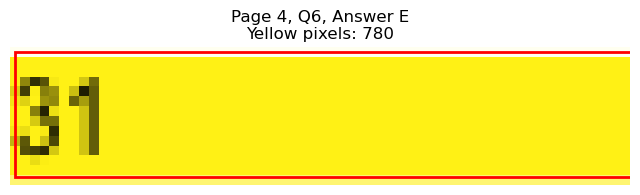


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=665.7, x1=247.0, y1=678.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 813
Page 4, Q7, A: Yellow percentage: 0.0%


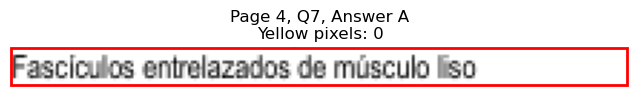

Page 4, Q7 - B: Detected box: x0=82.5, y0=678.3, x1=251.4, y1=691.0
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 878
Page 4, Q7, B: Yellow percentage: 0.0%


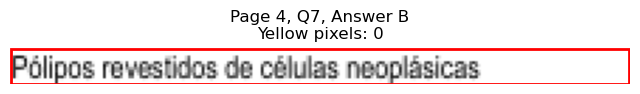

Page 4, Q7 - C: Detected box: x0=82.9, y0=691.1, x1=194.3, y1=703.7
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 572
Page 4, Q7, C: Yellow percentage: 0.0%


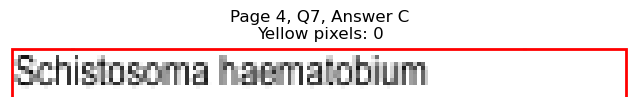

Page 4, Q7 - D: Detected box: x0=334.6, y0=665.7, x1=434.5, y1=678.4
Page 4, Q7, D: Yellow pixels: 151
Page 4, Q7, D: Total non-white pixels: 701
Page 4, Q7, D: Yellow percentage: 21.5%


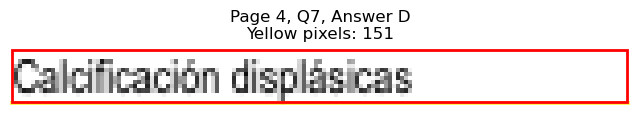

Page 4, Q7 - E: Detected box: x0=334.1, y0=678.3, x1=476.0, y1=691.0
Page 4, Q7, E: Yellow pixels: 1896
Page 4, Q7, E: Total non-white pixels: 2496
Page 4, Q7, E: Yellow percentage: 76.0%


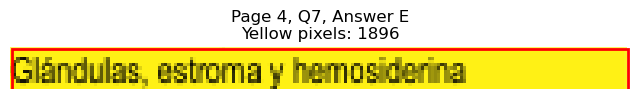


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=227.0, y1=148.2
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 730
Page 5, Q1, A: Yellow percentage: 0.0%


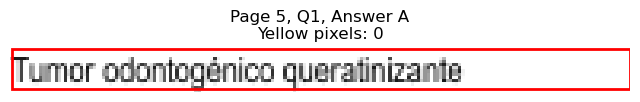

Page 5, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=152.2, y1=160.9
Page 5, Q1, B: Yellow pixels: 1291
Page 5, Q1, B: Total non-white pixels: 1573
Page 5, Q1, B: Yellow percentage: 82.1%


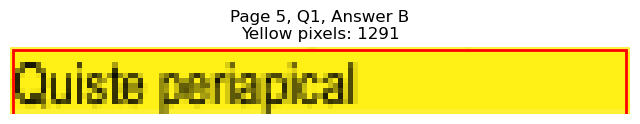

Page 5, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=243.0, y1=173.5
Page 5, Q1, C: Yellow pixels: 189
Page 5, Q1, C: Total non-white pixels: 1026
Page 5, Q1, C: Yellow percentage: 18.4%


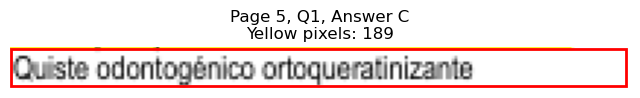

Page 5, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=437.5, y1=148.2
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 544
Page 5, Q1, D: Yellow percentage: 0.0%


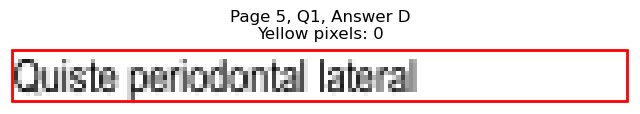

Page 5, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=470.1, y1=160.9
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 690
Page 5, Q1, E: Yellow percentage: 0.0%


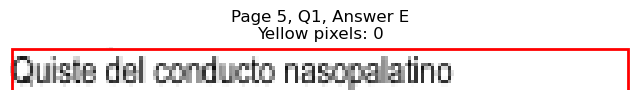


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=97.5, y1=224.0
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 143
Page 5, Q2, A: Yellow percentage: 0.0%


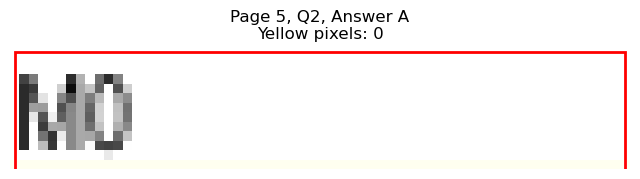

Page 5, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=97.5, y1=236.6
Page 5, Q2, B: Yellow pixels: 799
Page 5, Q2, B: Total non-white pixels: 924
Page 5, Q2, B: Yellow percentage: 86.5%


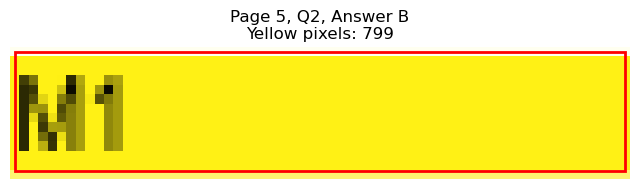

Page 5, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=97.9, y1=249.2
Page 5, Q2, C: Yellow pixels: 66
Page 5, Q2, C: Total non-white pixels: 138
Page 5, Q2, C: Yellow percentage: 47.8%


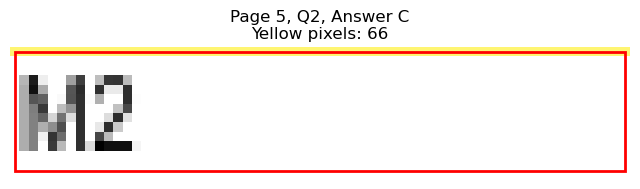

Page 5, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=349.6, y1=224.0
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 79
Page 5, Q2, D: Yellow percentage: 0.0%


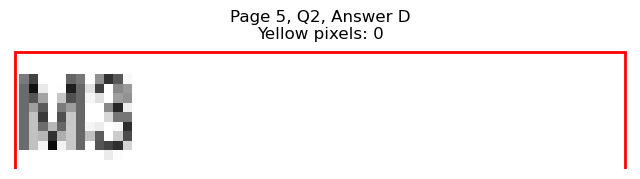

Page 5, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=349.1, y1=236.6
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 82
Page 5, Q2, E: Yellow percentage: 0.0%


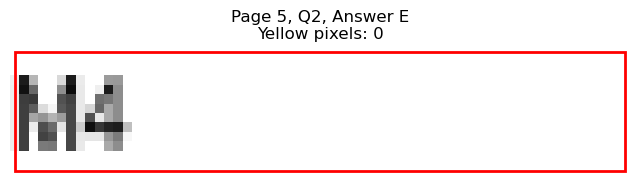


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=115.6, y1=287.1
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 163
Page 5, Q3, A: Yellow percentage: 0.0%


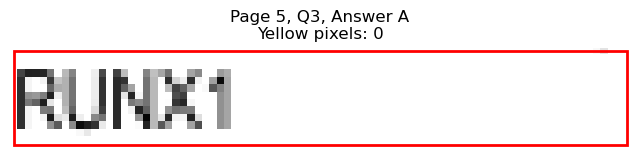

Page 5, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=106.6, y1=299.7
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 122
Page 5, Q3, B: Yellow percentage: 0.0%


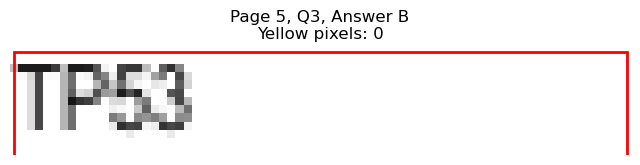

Page 5, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=114.5, y1=312.3
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 162
Page 5, Q3, C: Yellow percentage: 0.0%


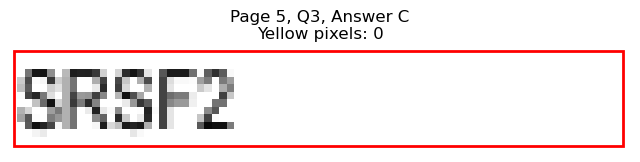

Page 5, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=362.2, y1=287.1
Page 5, Q3, D: Yellow pixels: 79
Page 5, Q3, D: Total non-white pixels: 224
Page 5, Q3, D: Yellow percentage: 35.3%


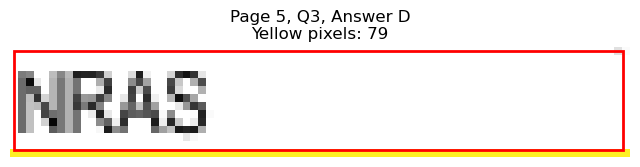

Page 5, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=364.3, y1=299.7
Page 5, Q3, E: Yellow pixels: 944
Page 5, Q3, E: Total non-white pixels: 1053
Page 5, Q3, E: Yellow percentage: 89.6%


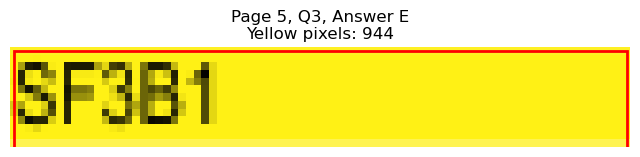


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=251.4, y1=350.1
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 885
Page 5, Q4, A: Yellow percentage: 0.0%


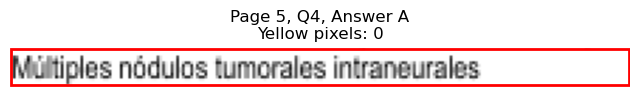

Page 5, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=149.7, y1=362.9
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 325
Page 5, Q4, B: Yellow percentage: 0.0%


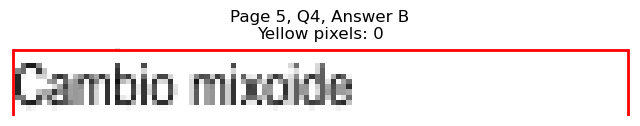

Page 5, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=136.1, y1=375.5
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 237
Page 5, Q4, C: Yellow percentage: 0.0%


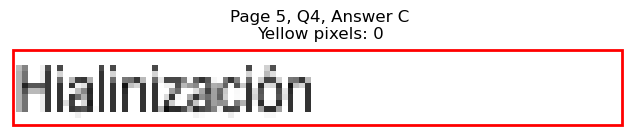

Page 5, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=474.1, y1=350.1
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 734
Page 5, Q4, D: Yellow percentage: 0.0%


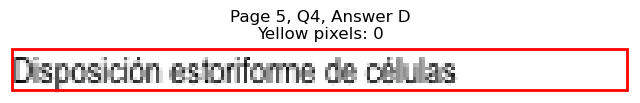

Page 5, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=457.0, y1=362.9
Page 5, Q4, E: Yellow pixels: 1777
Page 5, Q4, E: Total non-white pixels: 2262
Page 5, Q4, E: Yellow percentage: 78.6%


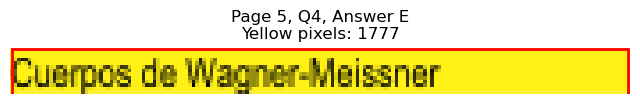


Page 5, Q4 - Selected Answer: E (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=143.2, y1=451.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 323
Page 5, Q5, A: Yellow percentage: 0.0%


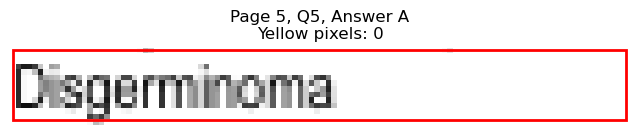

Page 5, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=164.2, y1=463.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 406
Page 5, Q5, B: Yellow percentage: 0.0%


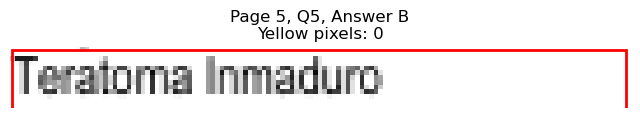

Page 5, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=174.3, y1=476.4
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 454
Page 5, Q5, C: Yellow percentage: 0.0%


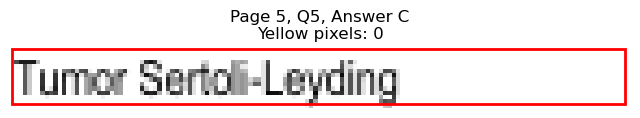

Page 5, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=401.3, y1=451.2
Page 5, Q5, D: Yellow pixels: 118
Page 5, Q5, D: Total non-white pixels: 419
Page 5, Q5, D: Yellow percentage: 28.2%


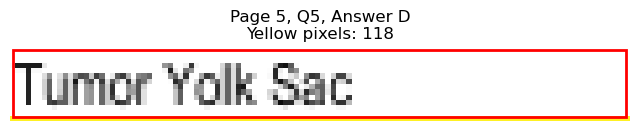

Page 5, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=390.8, y1=463.8
Page 5, Q5, E: Yellow pixels: 1188
Page 5, Q5, E: Total non-white pixels: 1391
Page 5, Q5, E: Yellow percentage: 85.4%


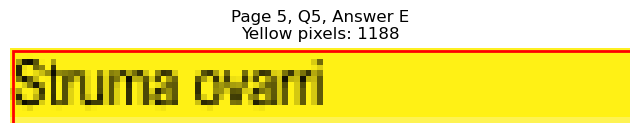


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=115.1, y1=514.3
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 128
Page 5, Q6, A: Yellow percentage: 0.0%


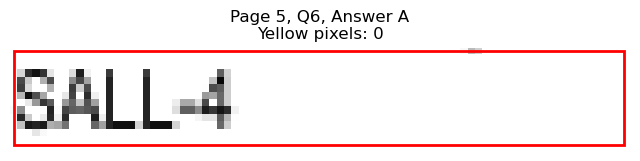

Page 5, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=113.1, y1=526.9
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 117
Page 5, Q6, B: Yellow percentage: 0.0%


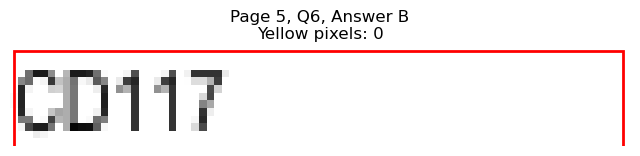

Page 5, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=108.5, y1=539.5
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 132
Page 5, Q6, C: Yellow percentage: 0.0%


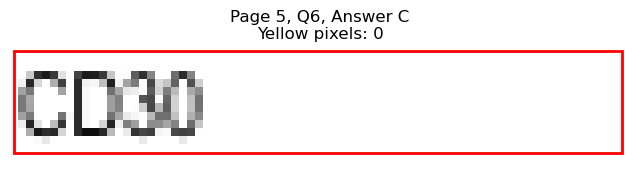

Page 5, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=356.7, y1=514.3
Page 5, Q6, D: Yellow pixels: 73
Page 5, Q6, D: Total non-white pixels: 183
Page 5, Q6, D: Yellow percentage: 39.9%


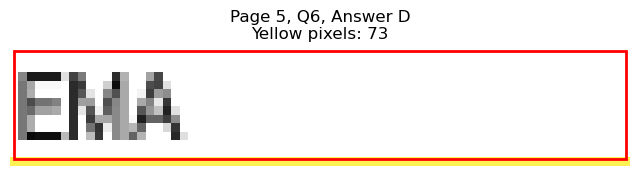

Page 5, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=354.2, y1=526.9
Page 5, Q6, E: Yellow pixels: 852
Page 5, Q6, E: Total non-white pixels: 923
Page 5, Q6, E: Yellow percentage: 92.3%


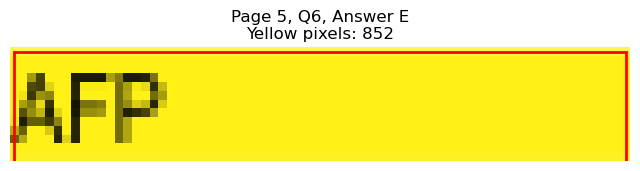


Page 5, Q6 - Selected Answer: E (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=256.6, y1=590.0
Page 5, Q7, A: Yellow pixels: 225
Page 5, Q7, A: Total non-white pixels: 1337
Page 5, Q7, A: Yellow percentage: 16.8%


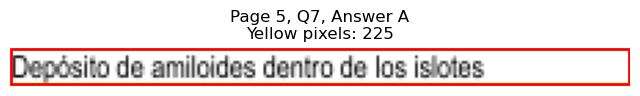

Page 5, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=285.2, y1=602.6
Page 5, Q7, B: Yellow pixels: 2522
Page 5, Q7, B: Total non-white pixels: 3556
Page 5, Q7, B: Yellow percentage: 70.9%


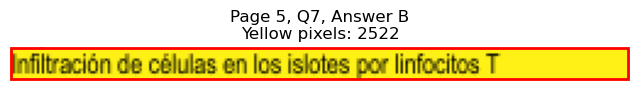

Page 5, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=242.9, y1=615.2
Page 5, Q7, C: Yellow pixels: 211
Page 5, Q7, C: Total non-white pixels: 1014
Page 5, Q7, C: Yellow percentage: 20.8%


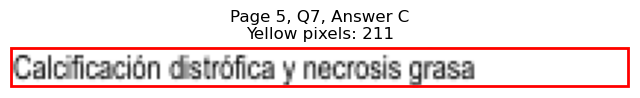

Page 5, Q7 - D: Detected box: x0=82.9, y0=615.2, x1=184.2, y1=627.8
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 503
Page 5, Q7, D: Yellow percentage: 0.0%


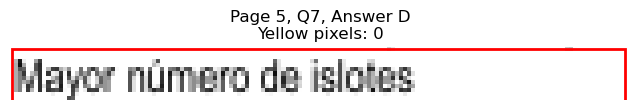

Page 5, Q7 - E: Detected box: x0=82.5, y0=627.9, x1=176.2, y1=640.6
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 455
Page 5, Q7, E: Yellow percentage: 0.0%


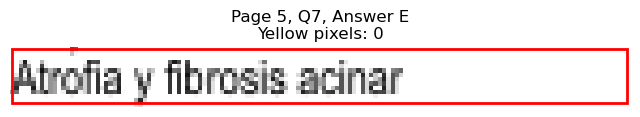


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=112.0, y1=716.3
Page 5, Q8, A: Yellow pixels: 850
Page 5, Q8, A: Total non-white pixels: 1120
Page 5, Q8, A: Yellow percentage: 75.9%


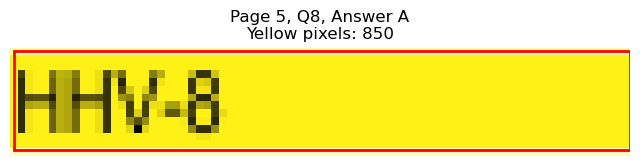

Page 5, Q8 - B: Detected box: x0=82.5, y0=716.3, x1=103.6, y1=728.9
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 173
Page 5, Q8, B: Yellow percentage: 0.0%


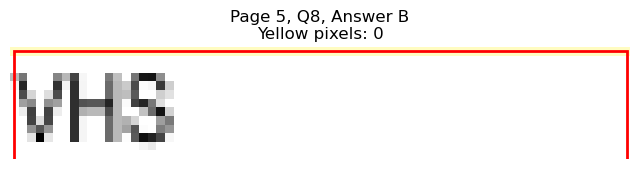

Page 5, Q8 - C: Detected box: x0=82.9, y0=728.9, x1=112.0, y1=741.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 139
Page 5, Q8, C: Yellow percentage: 0.0%


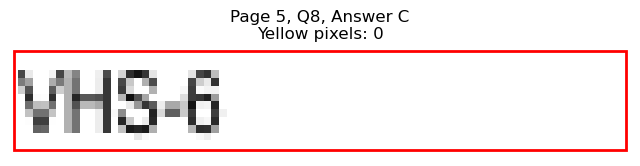

Page 5, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=352.1, y1=716.3
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 83
Page 5, Q8, D: Yellow percentage: 0.0%


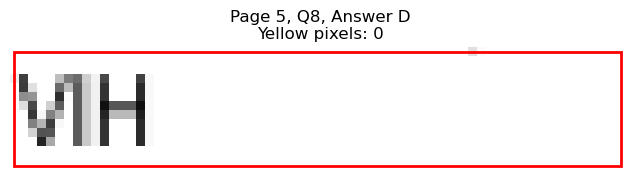

Page 5, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=354.2, y1=728.9
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 109
Page 5, Q8, E: Yellow percentage: 0.0%


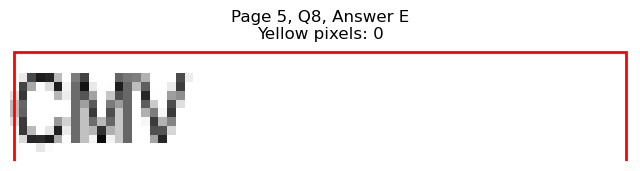


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=179.3, y1=123.0
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 495
Page 6, Q1, A: Yellow percentage: 0.0%


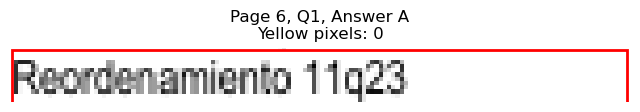

Page 6, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=116.1, y1=135.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 153
Page 6, Q1, B: Yellow percentage: 0.0%


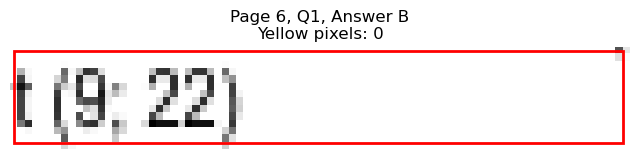

Page 6, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=116.5, y1=148.2
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 144
Page 6, Q1, C: Yellow percentage: 0.0%


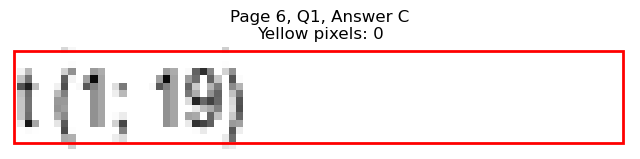

Page 6, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=392.3, y1=123.0
Page 6, Q1, D: Yellow pixels: 1138
Page 6, Q1, D: Total non-white pixels: 1417
Page 6, Q1, D: Yellow percentage: 80.3%


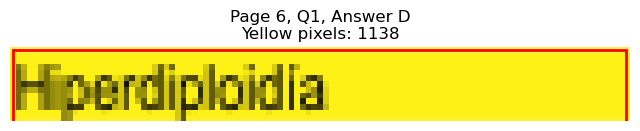

Page 6, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=388.9, y1=135.6
Page 6, Q1, E: Yellow pixels: 101
Page 6, Q1, E: Total non-white pixels: 423
Page 6, Q1, E: Yellow percentage: 23.9%


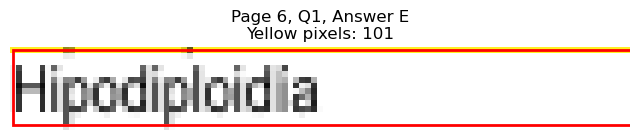


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=233.4, y1=186.1
Page 6, Q2, A: Yellow pixels: 1899
Page 6, Q2, A: Total non-white pixels: 2701
Page 6, Q2, A: Yellow percentage: 70.3%


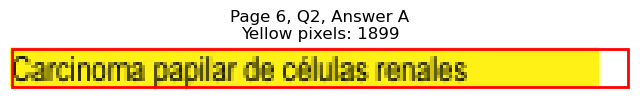

Page 6, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=220.8, y1=198.7
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 870
Page 6, Q2, B: Yellow percentage: 0.0%


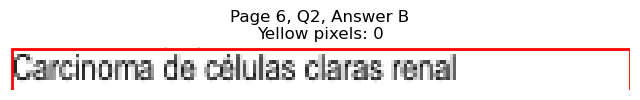

Page 6, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=174.3, y1=211.3
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 432
Page 6, Q2, C: Yellow percentage: 0.0%


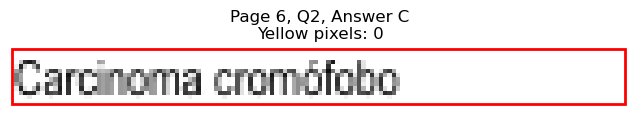

Page 6, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=466.0, y1=186.1
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 657
Page 6, Q2, D: Yellow percentage: 0.0%


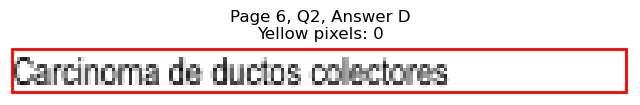

Page 6, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=437.9, y1=198.7
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 502
Page 6, Q2, E: Yellow percentage: 0.0%


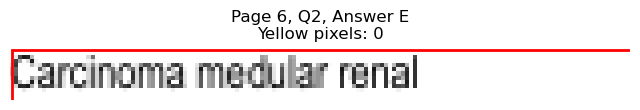


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=253.0, y1=274.4
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 850
Page 6, Q3, A: Yellow percentage: 0.0%


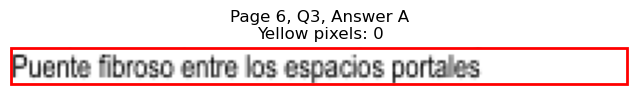

Page 6, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=181.2, y1=287.1
Page 6, Q3, B: Yellow pixels: 150
Page 6, Q3, B: Total non-white pixels: 669
Page 6, Q3, B: Yellow percentage: 22.4%


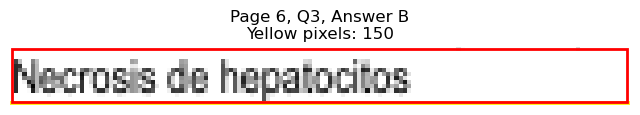

Page 6, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=164.2, y1=299.7
Page 6, Q3, C: Yellow pixels: 1386
Page 6, Q3, C: Total non-white pixels: 1729
Page 6, Q3, C: Yellow percentage: 80.2%


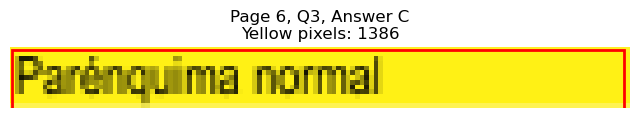

Page 6, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=411.3, y1=274.4
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 356
Page 6, Q3, D: Yellow percentage: 0.0%


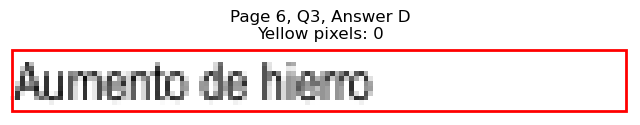

Page 6, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=475.1, y1=287.1
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 694
Page 6, Q3, E: Yellow percentage: 0.0%


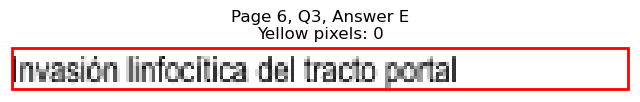


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=100.0, y1=375.5
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 79
Page 6, Q4, A: Yellow percentage: 0.0%


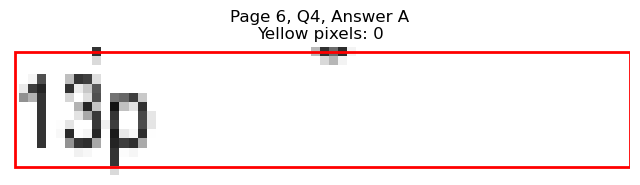

Page 6, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=100.0, y1=388.1
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 71
Page 6, Q4, B: Yellow percentage: 0.0%


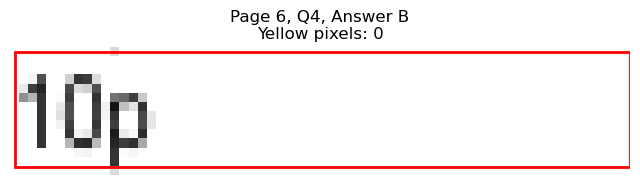

Page 6, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=100.5, y1=400.7
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 71
Page 6, Q4, C: Yellow percentage: 0.0%


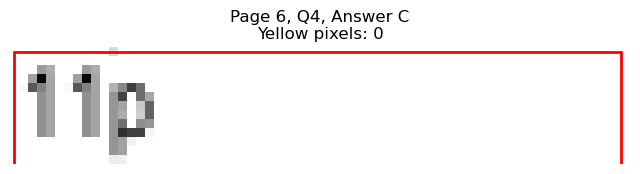

Page 6, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=352.1, y1=375.5
Page 6, Q4, D: Yellow pixels: 69
Page 6, Q4, D: Total non-white pixels: 147
Page 6, Q4, D: Yellow percentage: 46.9%


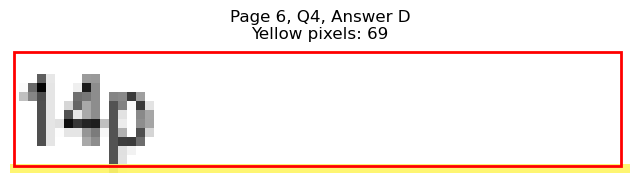

Page 6, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=351.7, y1=388.1
Page 6, Q4, E: Yellow pixels: 821
Page 6, Q4, E: Total non-white pixels: 952
Page 6, Q4, E: Yellow percentage: 86.2%


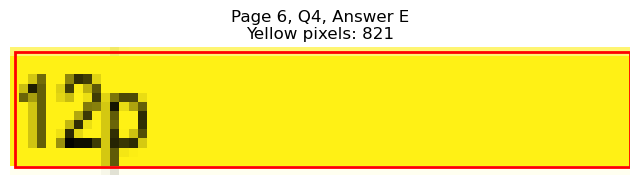


Page 6, Q4 - Selected Answer: E (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=351.9, y1=451.2
Page 6, Q5, A: Yellow pixels: 3152
Page 6, Q5, A: Total non-white pixels: 4480
Page 6, Q5, A: Yellow percentage: 70.4%


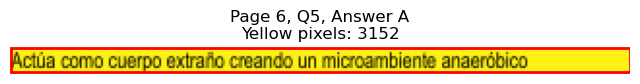

Page 6, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=345.8, y1=463.8
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 1586
Page 6, Q5, B: Yellow percentage: 0.0%


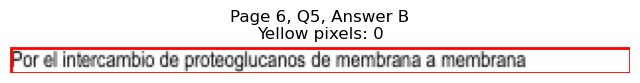

Page 6, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=333.3, y1=476.4
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 1257
Page 6, Q5, C: Yellow percentage: 0.0%


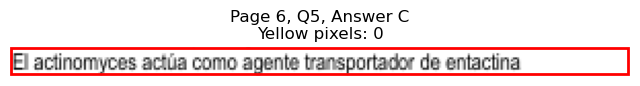

Page 6, Q5 - D: Detected box: x0=82.9, y0=476.3, x1=317.2, y1=489.0
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 1149
Page 6, Q5, D: Yellow percentage: 0.0%


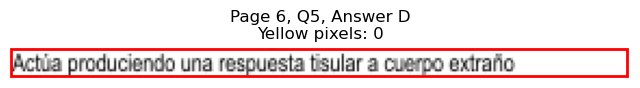

Page 6, Q5 - E: Detected box: x0=82.5, y0=489.1, x1=366.3, y1=501.7
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 1415
Page 6, Q5, E: Yellow percentage: 0.0%


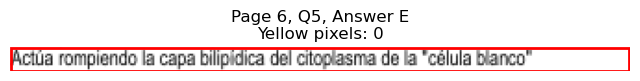


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=240.5, y1=539.5
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 822
Page 6, Q6, A: Yellow percentage: 0.0%


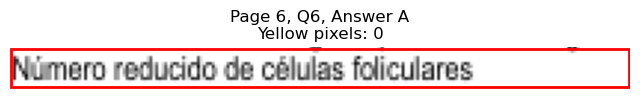

Page 6, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=255.5, y1=552.1
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 873
Page 6, Q6, B: Yellow percentage: 0.0%


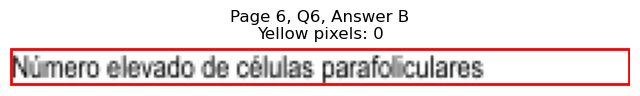

Page 6, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=258.5, y1=564.8
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 865
Page 6, Q6, C: Yellow percentage: 0.0%


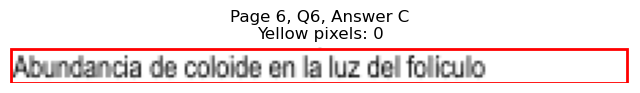

Page 6, Q6 - D: Detected box: x0=334.6, y0=526.9, x1=497.6, y1=539.5
Page 6, Q6, D: Yellow pixels: 1878
Page 6, Q6, D: Total non-white pixels: 2688
Page 6, Q6, D: Yellow percentage: 69.9%


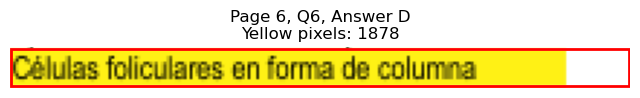

Page 6, Q6 - E: Detected box: x0=334.1, y0=539.5, x1=518.3, y1=552.1
Page 6, Q6, E: Yellow pixels: 192
Page 6, Q6, E: Total non-white pixels: 1150
Page 6, Q6, E: Yellow percentage: 16.7%


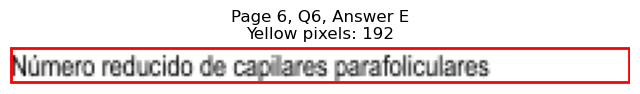


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=590.0, x1=154.8, y1=602.6
Page 6, Q7, A: Yellow pixels: 123
Page 6, Q7, A: Total non-white pixels: 478
Page 6, Q7, A: Yellow percentage: 25.7%


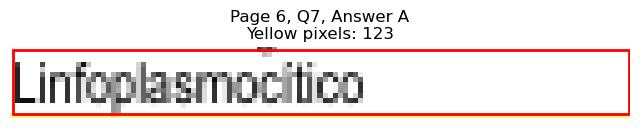

Page 6, Q7 - B: Detected box: x0=82.5, y0=602.6, x1=240.8, y1=615.2
Page 6, Q7, B: Yellow pixels: 1879
Page 6, Q7, B: Total non-white pixels: 2702
Page 6, Q7, B: Yellow percentage: 69.5%


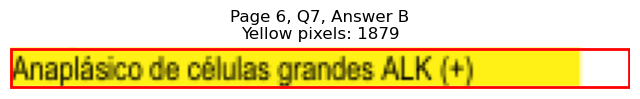

Page 6, Q7 - C: Detected box: x0=82.9, y0=615.2, x1=165.7, y1=627.8
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 540
Page 6, Q7, C: Yellow percentage: 0.0%


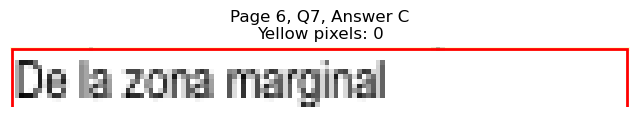

Page 6, Q7 - D: Detected box: x0=334.6, y0=590.0, x1=374.2, y1=602.6
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 196
Page 6, Q7, D: Yellow percentage: 0.0%


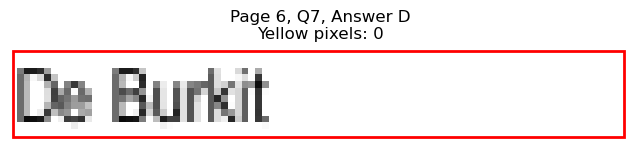

Page 6, Q7 - E: Detected box: x0=334.1, y0=602.6, x1=420.9, y1=615.2
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 436
Page 6, Q7, E: Yellow percentage: 0.0%


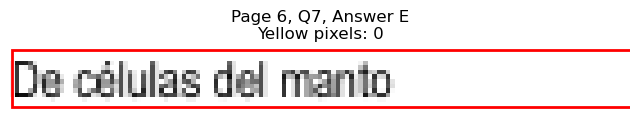


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=159.3, y1=703.7
Page 6, Q8, A: Yellow pixels: 1330
Page 6, Q8, A: Total non-white pixels: 1664
Page 6, Q8, A: Yellow percentage: 79.9%


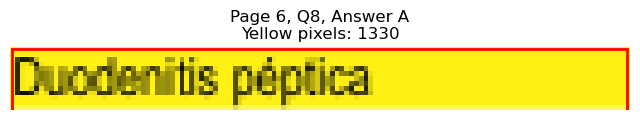

Page 6, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=123.1, y1=716.3
Page 6, Q8, B: Yellow pixels: 92
Page 6, Q8, B: Total non-white pixels: 309
Page 6, Q8, B: Yellow percentage: 29.8%


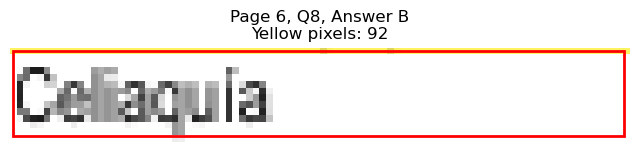

Page 6, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=174.3, y1=728.9
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 454
Page 6, Q8, C: Yellow percentage: 0.0%


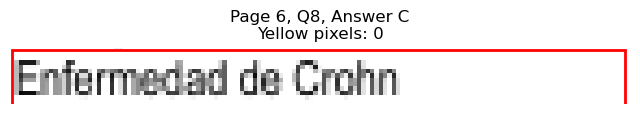

Page 6, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=397.3, y1=703.7
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 333
Page 6, Q8, D: Yellow percentage: 0.0%


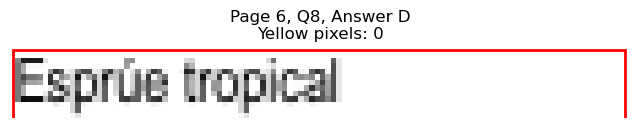

Page 6, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=478.1, y1=716.3
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 779
Page 6, Q8, E: Yellow percentage: 0.0%


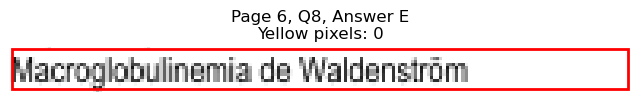


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 8 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=115.6, y1=135.6
Page 7, Q1, A: Yellow pixels: 84
Page 7, Q1, A: Total non-white pixels: 263
Page 7, Q1, A: Yellow percentage: 31.9%


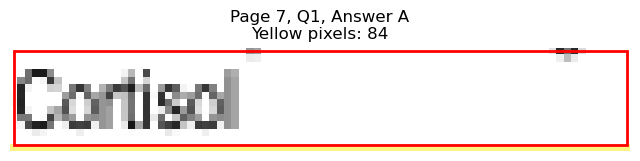

Page 7, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=136.1, y1=148.2
Page 7, Q1, B: Yellow pixels: 1173
Page 7, Q1, B: Total non-white pixels: 1470
Page 7, Q1, B: Yellow percentage: 79.8%


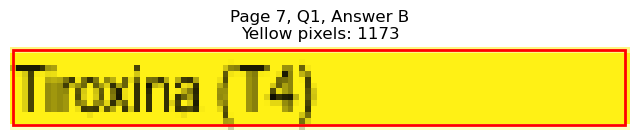

Page 7, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=142.1, y1=160.9
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 398
Page 7, Q1, C: Yellow percentage: 0.0%


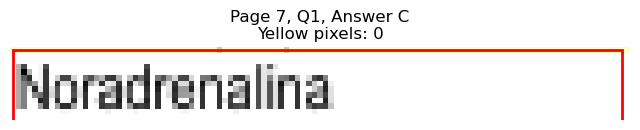

Page 7, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=394.9, y1=135.6
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 310
Page 7, Q1, D: Yellow percentage: 0.0%


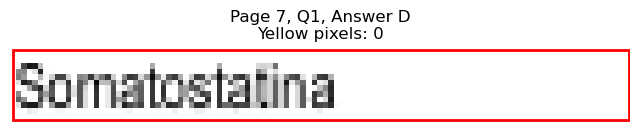

Page 7, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=367.7, y1=148.2
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 168
Page 7, Q1, E: Yellow percentage: 0.0%


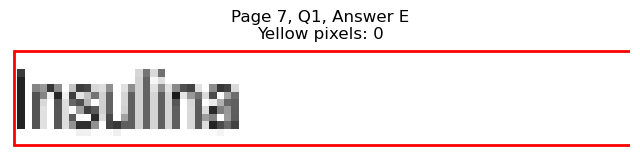


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=191.8, y1=224.0
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 694
Page 7, Q2, A: Yellow percentage: 0.0%


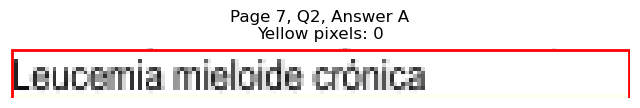

Page 7, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=201.4, y1=236.6
Page 7, Q2, B: Yellow pixels: 1739
Page 7, Q2, B: Total non-white pixels: 2380
Page 7, Q2, B: Yellow percentage: 73.1%


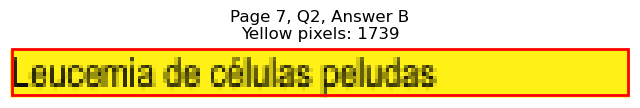

Page 7, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=230.9, y1=249.2
Page 7, Q2, C: Yellow pixels: 192
Page 7, Q2, C: Total non-white pixels: 942
Page 7, Q2, C: Yellow percentage: 20.4%


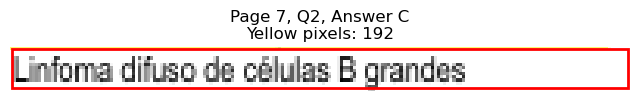

Page 7, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=376.4, y1=224.0
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 408
Page 7, Q2, D: Yellow percentage: 0.0%


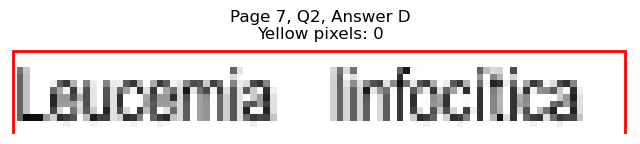

Page 7, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=499.2, y1=249.2
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 781
Page 7, Q2, E: Yellow percentage: 0.0%


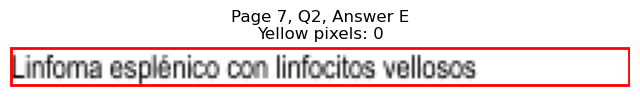


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=229.0, y1=287.1
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 730
Page 7, Q3, A: Yellow percentage: 0.0%


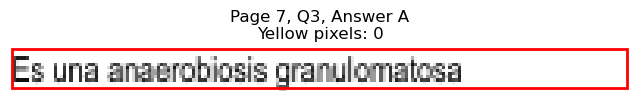

Page 7, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=190.8, y1=299.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 562
Page 7, Q3, B: Yellow percentage: 0.0%


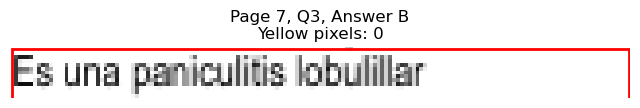

Page 7, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=168.7, y1=312.3
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 427
Page 7, Q3, C: Yellow percentage: 0.0%


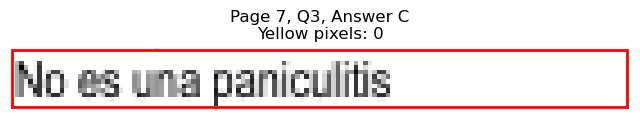

Page 7, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=434.0, y1=287.1
Page 7, Q3, D: Yellow pixels: 1568
Page 7, Q3, D: Total non-white pixels: 2100
Page 7, Q3, D: Yellow percentage: 74.7%


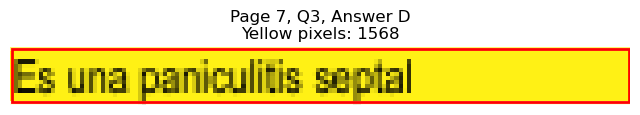

Page 7, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=485.1, y1=299.7
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 890
Page 7, Q3, E: Yellow percentage: 0.0%


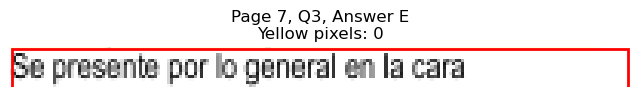


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=169.2, y1=350.1
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 416
Page 7, Q4, A: Yellow percentage: 0.0%


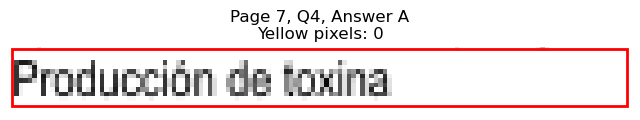

Page 7, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=197.3, y1=362.9
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 748
Page 7, Q4, B: Yellow percentage: 0.0%


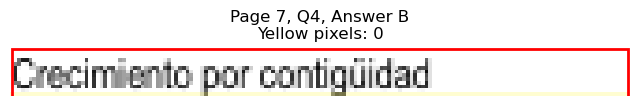

Page 7, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=275.3, y1=375.5
Page 7, Q4, C: Yellow pixels: 1789
Page 7, Q4, C: Total non-white pixels: 2702
Page 7, Q4, C: Yellow percentage: 66.2%


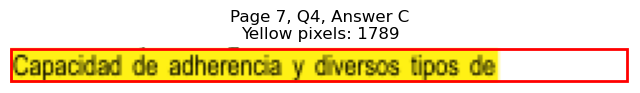

Page 7, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=443.9, y1=350.1
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 552
Page 7, Q4, D: Yellow percentage: 0.0%


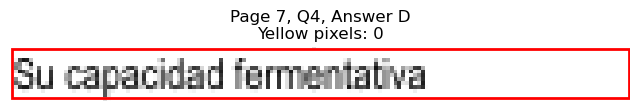

Page 7, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=415.7, y1=362.9
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 389
Page 7, Q4, E: Yellow percentage: 0.0%


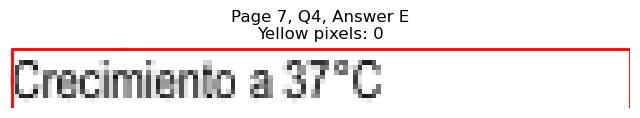


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=224.0, y1=463.8
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 707
Page 7, Q5, A: Yellow percentage: 0.0%


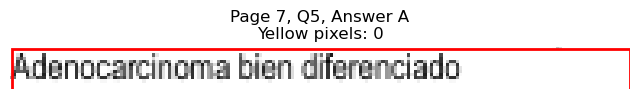

Page 7, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=242.9, y1=476.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 807
Page 7, Q5, B: Yellow percentage: 0.0%


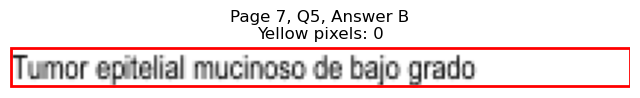

Page 7, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=202.8, y1=489.0
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 613
Page 7, Q5, C: Yellow percentage: 0.0%


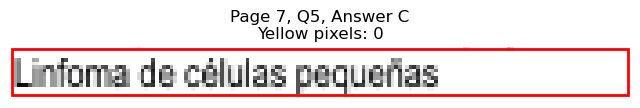

Page 7, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=406.9, y1=463.8
Page 7, Q5, D: Yellow pixels: 1333
Page 7, Q5, D: Total non-white pixels: 1599
Page 7, Q5, D: Yellow percentage: 83.4%


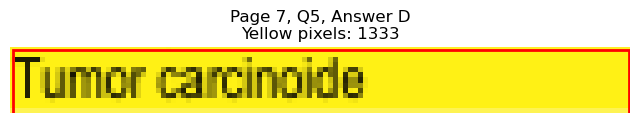

Page 7, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=463.0, y1=476.4
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 640
Page 7, Q5, E: Yellow percentage: 0.0%


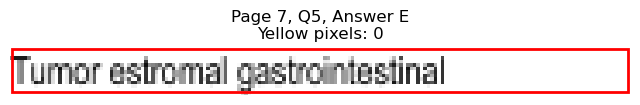


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=130.6, y1=552.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 247
Page 7, Q6, A: Yellow percentage: 0.0%


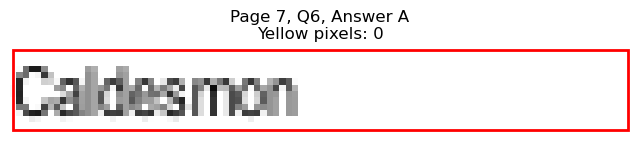

Page 7, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=136.6, y1=564.8
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 276
Page 7, Q6, B: Yellow percentage: 0.0%


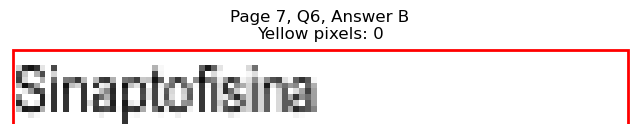

Page 7, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=139.1, y1=577.4
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 288
Page 7, Q6, C: Yellow percentage: 0.0%


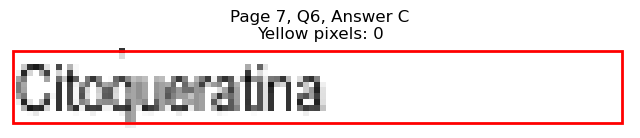

Page 7, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=397.9, y1=552.1
Page 7, Q6, D: Yellow pixels: 1256
Page 7, Q6, D: Total non-white pixels: 1596
Page 7, Q6, D: Yellow percentage: 78.7%


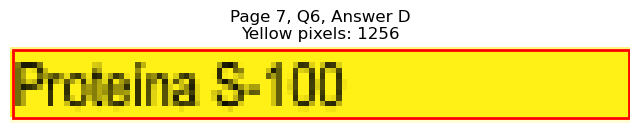

Page 7, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=372.3, y1=564.8
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 287
Page 7, Q6, E: Yellow percentage: 0.0%


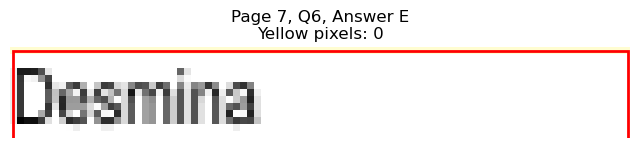


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=203.8, y1=615.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 621
Page 7, Q7, A: Yellow percentage: 0.0%


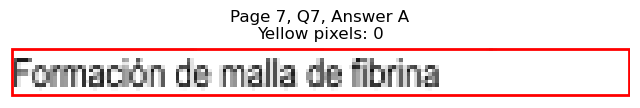

Page 7, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=238.5, y1=627.8
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 796
Page 7, Q7, B: Yellow percentage: 0.0%


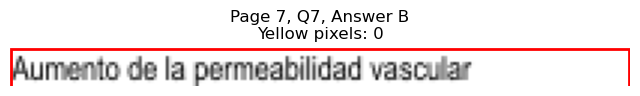

Page 7, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=191.8, y1=640.6
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 577
Page 7, Q7, C: Yellow percentage: 0.0%


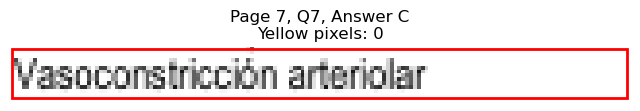

Page 7, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=485.0, y1=615.2
Page 7, Q7, D: Yellow pixels: 192
Page 7, Q7, D: Total non-white pixels: 964
Page 7, Q7, D: Yellow percentage: 19.9%


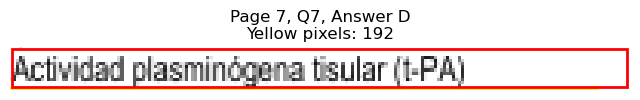

Page 7, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=466.2, y1=627.8
Page 7, Q7, E: Yellow pixels: 1863
Page 7, Q7, E: Total non-white pixels: 2379
Page 7, Q7, E: Yellow percentage: 78.3%


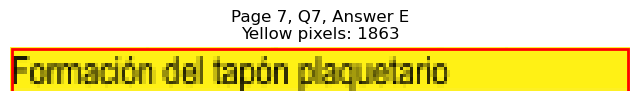


Page 7, Q7 - Selected Answer: E (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=224.0, y1=716.3
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 701
Page 7, Q8, A: Yellow percentage: 0.0%


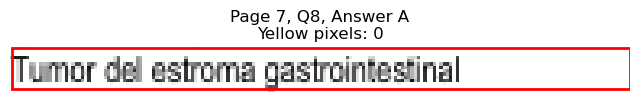

Page 7, Q8 - B: Detected box: x0=82.5, y0=716.3, x1=201.9, y1=728.9
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 781
Page 7, Q8, B: Yellow percentage: 0.0%


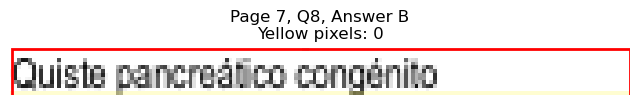

Page 7, Q8 - C: Detected box: x0=82.9, y0=728.9, x1=197.3, y1=741.5
Page 7, Q8, C: Yellow pixels: 1697
Page 7, Q8, C: Total non-white pixels: 2324
Page 7, Q8, C: Yellow percentage: 73.0%


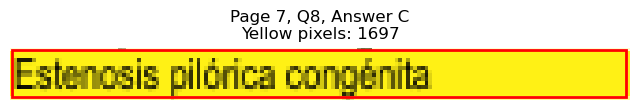

Page 7, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=414.4, y1=716.3
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 402
Page 7, Q8, D: Yellow percentage: 0.0%


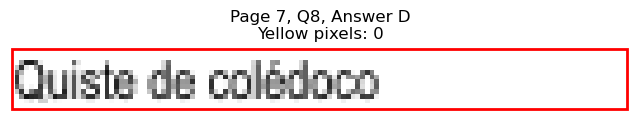

Page 7, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=401.9, y1=728.9
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 361
Page 7, Q8, E: Yellow percentage: 0.0%


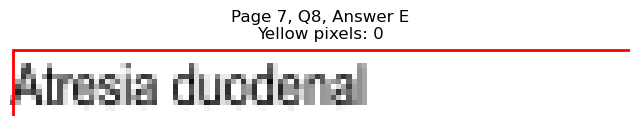


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=124.6, y1=148.2
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 164
Page 8, Q1, A: Yellow percentage: 0.0%


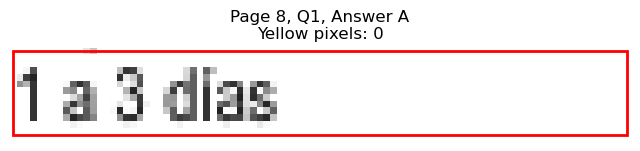

Page 8, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=144.1, y1=160.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 286
Page 8, Q1, B: Yellow percentage: 0.0%


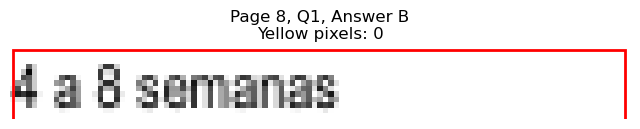

Page 8, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=151.7, y1=173.5
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 309
Page 8, Q1, C: Yellow percentage: 0.0%


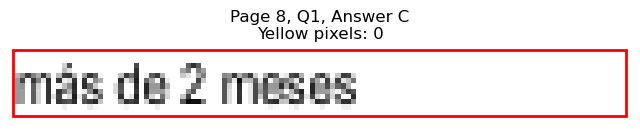

Page 8, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=392.3, y1=148.2
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 239
Page 8, Q1, D: Yellow percentage: 0.0%


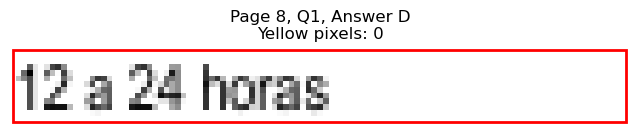

Page 8, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=386.3, y1=160.9
Page 8, Q1, E: Yellow pixels: 1161
Page 8, Q1, E: Total non-white pixels: 1339
Page 8, Q1, E: Yellow percentage: 86.7%


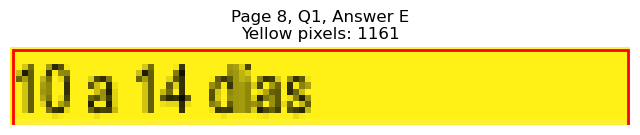


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=70.8, y0=198.6, x1=79.3, y1=211.3
Page 8, Q2, A: Yellow pixels: 674
Page 8, Q2, A: Total non-white pixels: 840
Page 8, Q2, A: Yellow percentage: 80.2%


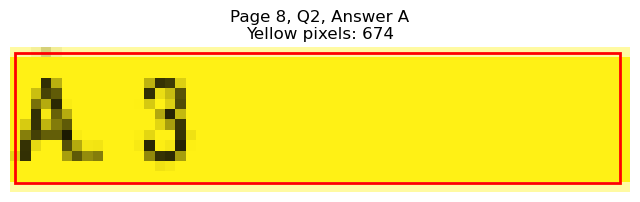

Page 8, Q2 - B: Detected box: x0=70.8, y0=211.3, x1=79.3, y1=224.0
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 115
Page 8, Q2, B: Yellow percentage: 0.0%


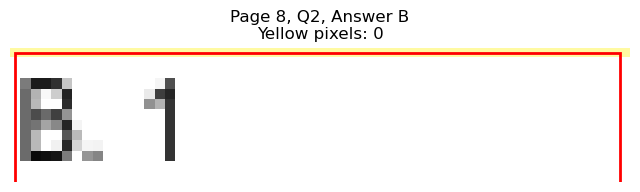

Page 8, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=95.5, y1=236.6
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 38
Page 8, Q2, C: Yellow percentage: 0.0%


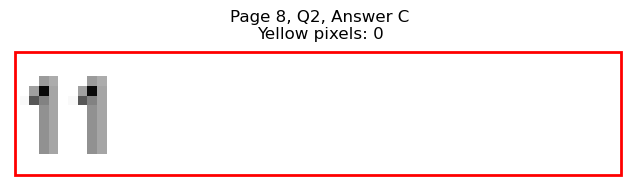

Page 8, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=347.2, y1=211.3
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 40
Page 8, Q2, D: Yellow percentage: 0.0%


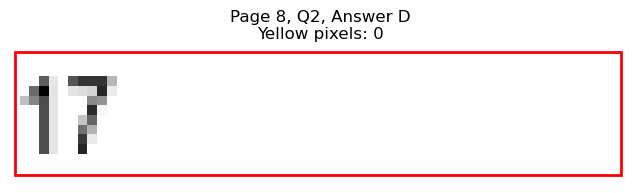

Page 8, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=346.7, y1=224.0
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 54
Page 8, Q2, E: Yellow percentage: 0.0%


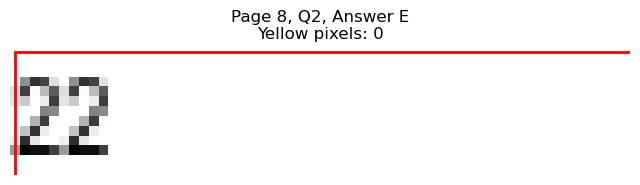


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=140.2, y1=312.3
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 299
Page 8, Q3, A: Yellow percentage: 0.0%


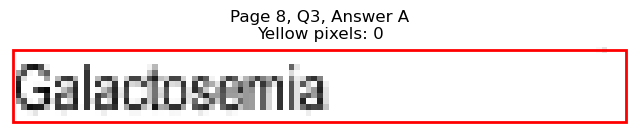

Page 8, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=213.4, y1=324.9
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 859
Page 8, Q3, B: Yellow percentage: 0.0%


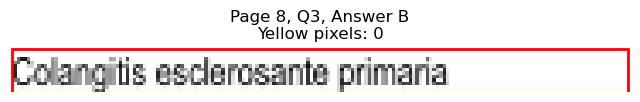

Page 8, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=172.7, y1=337.5
Page 8, Q3, C: Yellow pixels: 1466
Page 8, Q3, C: Total non-white pixels: 1974
Page 8, Q3, C: Yellow percentage: 74.3%


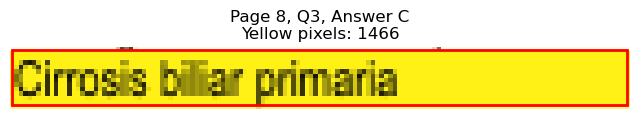

Page 8, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=456.4, y1=312.3
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 601
Page 8, Q3, D: Yellow percentage: 0.0%


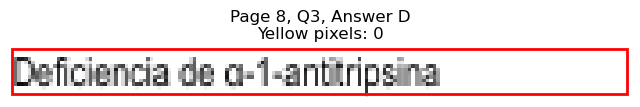

Page 8, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=411.4, y1=324.9
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 404
Page 8, Q3, E: Yellow percentage: 0.0%


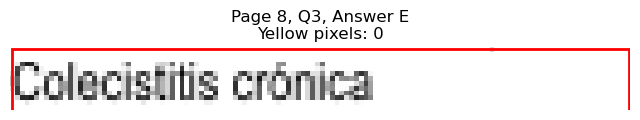


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=219.9, y1=375.5
Page 8, Q4, A: Yellow pixels: 188
Page 8, Q4, A: Total non-white pixels: 838
Page 8, Q4, A: Yellow percentage: 22.4%


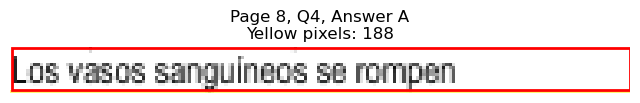

Page 8, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=171.7, y1=388.1
Page 8, Q4, B: Yellow pixels: 1452
Page 8, Q4, B: Total non-white pixels: 1960
Page 8, Q4, B: Yellow percentage: 74.1%


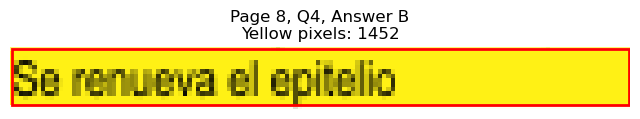

Page 8, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=198.9, y1=400.7
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 781
Page 8, Q4, C: Yellow percentage: 0.0%


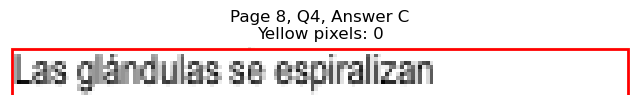

Page 8, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=520.2, y1=375.5
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 875
Page 8, Q4, D: Yellow percentage: 0.0%


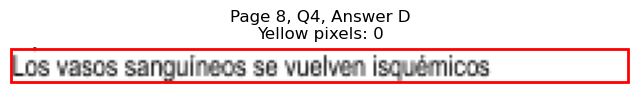

Page 8, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=493.7, y1=388.1
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 756
Page 8, Q4, E: Yellow percentage: 0.0%


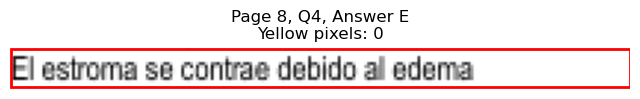


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=237.0, y1=438.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 823
Page 8, Q5, A: Yellow percentage: 0.0%


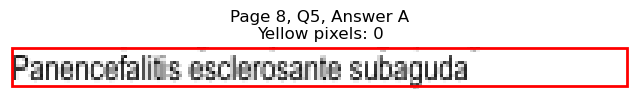

Page 8, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=172.7, y1=451.2
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 478
Page 8, Q5, B: Yellow percentage: 0.0%


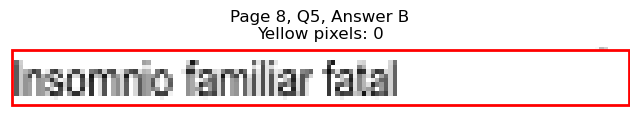

Page 8, Q5 - C: Detected box: x0=82.9, y0=451.1, x1=180.7, y1=463.8
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 509
Page 8, Q5, C: Yellow percentage: 0.0%


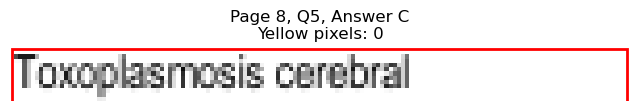

Page 8, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=391.3, y1=438.6
Page 8, Q5, D: Yellow pixels: 108
Page 8, Q5, D: Total non-white pixels: 416
Page 8, Q5, D: Yellow percentage: 26.0%


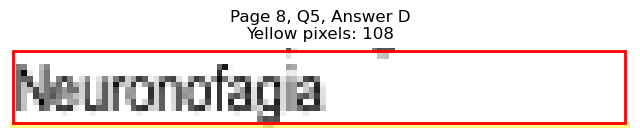

Page 8, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=471.6, y1=451.2
Page 8, Q5, E: Yellow pixels: 1909
Page 8, Q5, E: Total non-white pixels: 2632
Page 8, Q5, E: Yellow percentage: 72.5%


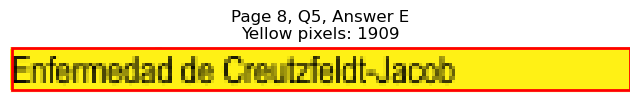


Page 8, Q5 - Selected Answer: E (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=183.7, y1=539.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 506
Page 8, Q6, A: Yellow percentage: 0.0%


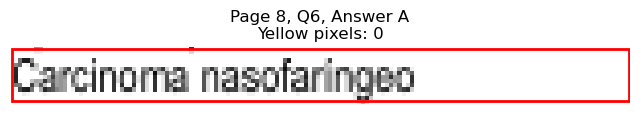

Page 8, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=172.7, y1=552.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 454
Page 8, Q6, B: Yellow percentage: 0.0%


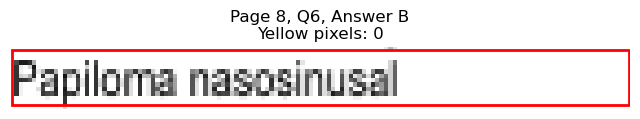

Page 8, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=125.5, y1=564.8
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 193
Page 8, Q6, C: Yellow percentage: 0.0%


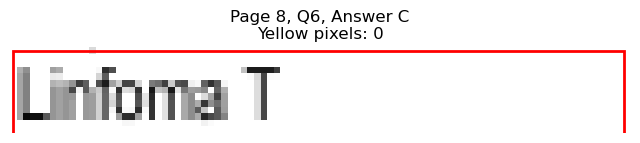

Page 8, Q6 - D: Detected box: x0=334.6, y0=526.9, x1=375.8, y1=539.5
Page 8, Q6, D: Yellow pixels: 92
Page 8, Q6, D: Total non-white pixels: 305
Page 8, Q6, D: Yellow percentage: 30.2%


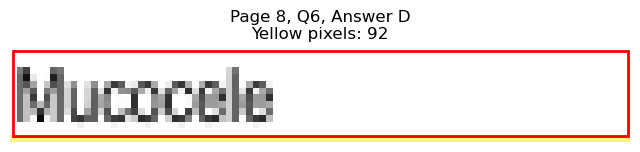

Page 8, Q6 - E: Detected box: x0=334.1, y0=539.5, x1=388.3, y1=552.1
Page 8, Q6, E: Yellow pixels: 1138
Page 8, Q6, E: Total non-white pixels: 1470
Page 8, Q6, E: Yellow percentage: 77.4%


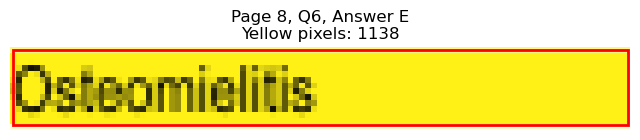


Page 8, Q6 - Selected Answer: E (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=615.2, x1=149.7, y1=627.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 358
Page 8, Q7, A: Yellow percentage: 0.0%


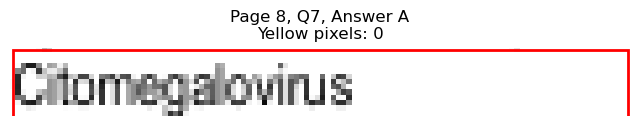

Page 8, Q7 - B: Detected box: x0=82.5, y0=627.9, x1=130.1, y1=640.6
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 240
Page 8, Q7, B: Yellow percentage: 0.0%


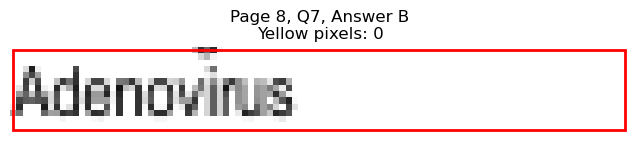

Page 8, Q7 - C: Detected box: x0=82.9, y0=640.5, x1=123.6, y1=653.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 192
Page 8, Q7, C: Yellow percentage: 0.0%


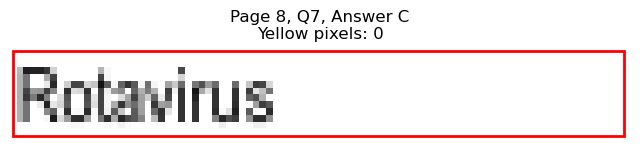

Page 8, Q7 - D: Detected box: x0=334.6, y0=615.2, x1=385.7, y1=627.8
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 256
Page 8, Q7, D: Yellow percentage: 0.0%


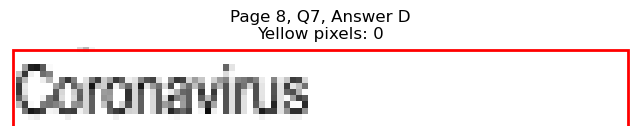

Page 8, Q7 - E: Detected box: x0=334.1, y0=627.9, x1=415.9, y1=640.6
Page 8, Q7, E: Yellow pixels: 1407
Page 8, Q7, E: Total non-white pixels: 1848
Page 8, Q7, E: Yellow percentage: 76.1%


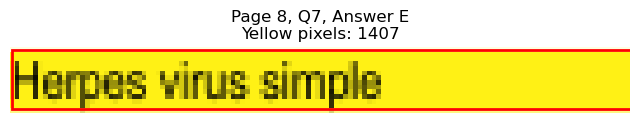


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=678.3, x1=189.3, y1=691.0
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 515
Page 8, Q8, A: Yellow percentage: 0.0%


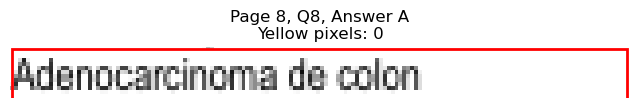

Page 8, Q8 - B: Detected box: x0=82.5, y0=691.1, x1=205.4, y1=703.7
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 615
Page 8, Q8, B: Yellow percentage: 0.0%


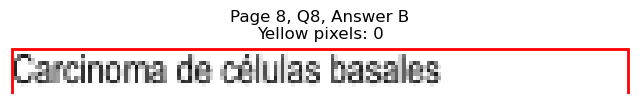

Page 8, Q8 - C: Detected box: x0=82.9, y0=703.7, x1=138.1, y1=716.3
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 308
Page 8, Q8, C: Yellow percentage: 0.0%


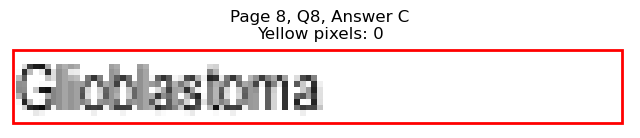

Page 8, Q8 - D: Detected box: x0=334.6, y0=678.3, x1=455.9, y1=691.0
Page 8, Q8, D: Yellow pixels: 1754
Page 8, Q8, D: Total non-white pixels: 2236
Page 8, Q8, D: Yellow percentage: 78.4%


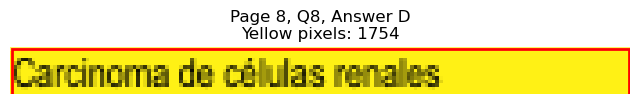

Page 8, Q8 - E: Detected box: x0=334.1, y0=691.1, x1=449.0, y1=703.7
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 736
Page 8, Q8, E: Yellow percentage: 0.0%


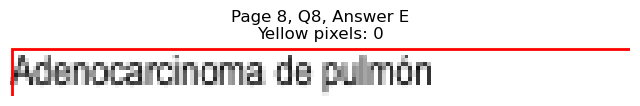


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=70.8, y0=741.4, x1=79.3, y1=754.1
Page 8, Q9, A: Yellow pixels: 60
Page 8, Q9, A: Total non-white pixels: 130
Page 8, Q9, A: Yellow percentage: 46.2%


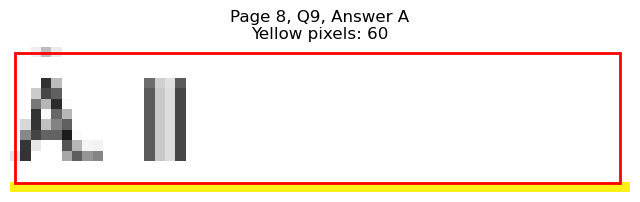

Page 8, Q9 - B: Detected box: x0=70.8, y0=754.0, x1=79.3, y1=766.7
Page 8, Q9, B: Yellow pixels: 727
Page 8, Q9, B: Total non-white pixels: 780
Page 8, Q9, B: Yellow percentage: 93.2%


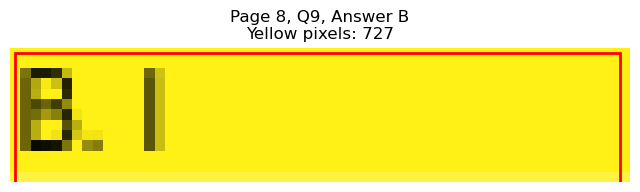

Page 8, Q9 - C: Detected box: x0=82.9, y0=766.8, x1=93.0, y1=779.4
Page 8, Q9, C: Yellow pixels: 62
Page 8, Q9, C: Total non-white pixels: 110
Page 8, Q9, C: Yellow percentage: 56.4%


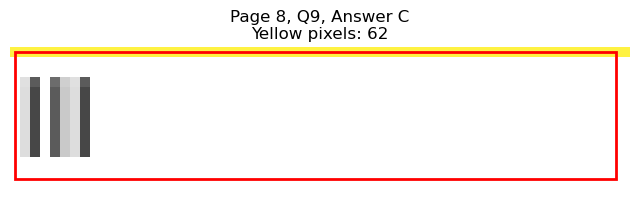

Page 8, Q9 - D: Detected box: x0=334.6, y0=741.4, x1=345.7, y1=754.1
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 44
Page 8, Q9, D: Yellow percentage: 0.0%


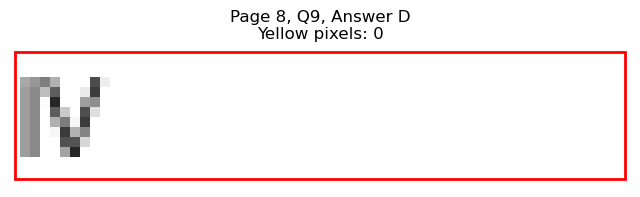

Page 8, Q9 - E: Detected box: x0=322.5, y0=754.0, x1=331.0, y1=766.7
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 64
Page 8, Q9, E: Yellow percentage: 0.0%


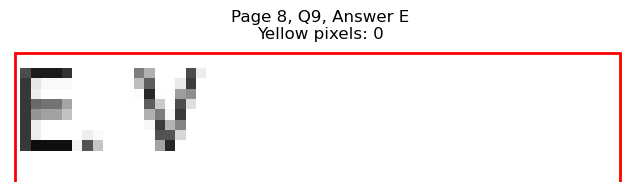


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=124.6, y1=135.6
Page 9, Q1, A: Yellow pixels: 93
Page 9, Q1, A: Total non-white pixels: 318
Page 9, Q1, A: Yellow percentage: 29.2%


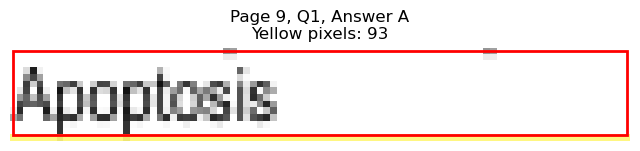

Page 9, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=185.3, y1=148.2
Page 9, Q1, B: Yellow pixels: 1608
Page 9, Q1, B: Total non-white pixels: 2156
Page 9, Q1, B: Yellow percentage: 74.6%


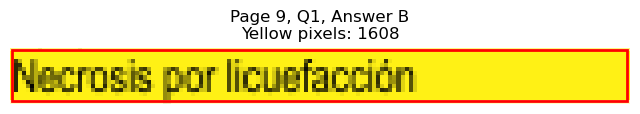

Page 9, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=163.8, y1=160.9
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 551
Page 9, Q1, C: Yellow percentage: 0.0%


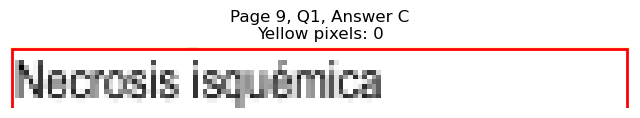

Page 9, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=373.7, y1=135.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 225
Page 9, Q1, D: Yellow percentage: 0.0%


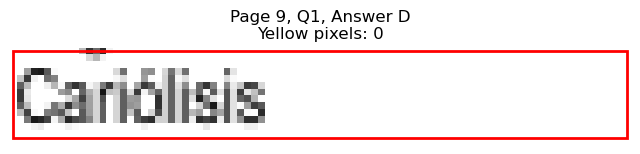

Page 9, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=419.9, y1=148.2
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 443
Page 9, Q1, E: Yellow percentage: 0.0%


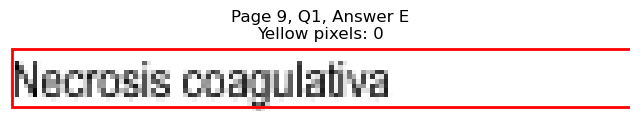


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=154.7, y1=236.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 384
Page 9, Q2, A: Yellow percentage: 0.0%


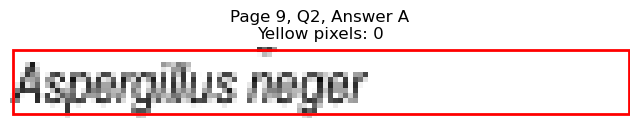

Page 9, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=158.7, y1=249.2
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 402
Page 9, Q2, B: Yellow percentage: 0.0%


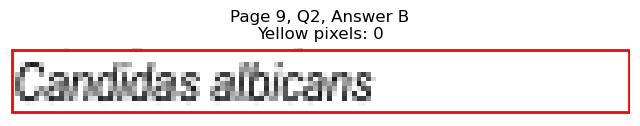

Page 9, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=175.7, y1=261.8
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 486
Page 9, Q2, C: Yellow percentage: 0.0%


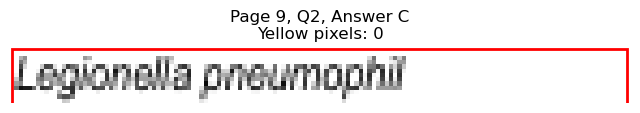

Page 9, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=465.5, y1=236.6
Page 9, Q2, D: Yellow pixels: 1844
Page 9, Q2, D: Total non-white pixels: 2548
Page 9, Q2, D: Yellow percentage: 72.4%


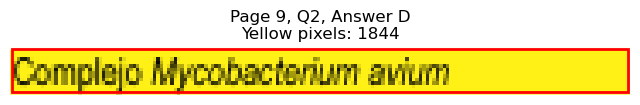

Page 9, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=416.9, y1=249.2
Page 9, Q2, E: Yellow pixels: 131
Page 9, Q2, E: Total non-white pixels: 567
Page 9, Q2, E: Yellow percentage: 23.1%


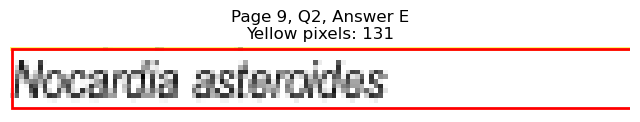


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.5, y0=324.9, x1=229.0, y1=337.5
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 773
Page 9, Q3, A: Yellow percentage: 0.0%


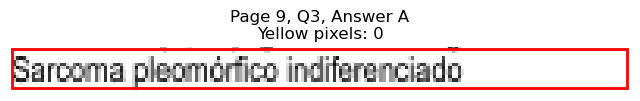

Page 9, Q3 - B: Detected box: x0=82.5, y0=337.5, x1=136.6, y1=350.1
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 253
Page 9, Q3, B: Yellow percentage: 0.0%


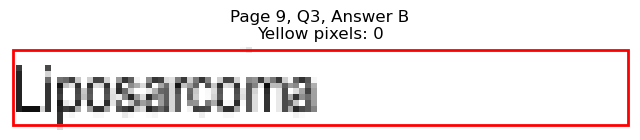

Page 9, Q3 - C: Detected box: x0=82.9, y0=350.2, x1=161.2, y1=362.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 397
Page 9, Q3, C: Yellow percentage: 0.0%


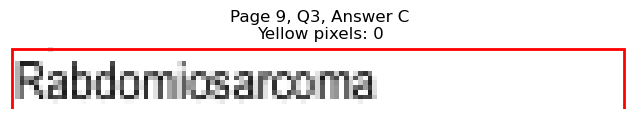

Page 9, Q3 - D: Detected box: x0=334.6, y0=324.9, x1=415.9, y1=337.5
Page 9, Q3, D: Yellow pixels: 132
Page 9, Q3, D: Total non-white pixels: 567
Page 9, Q3, D: Yellow percentage: 23.3%


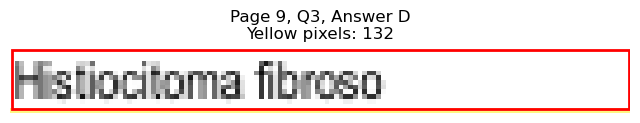

Page 9, Q3 - E: Detected box: x0=334.1, y0=337.5, x1=405.3, y1=350.1
Page 9, Q3, E: Yellow pixels: 1314
Page 9, Q3, E: Total non-white pixels: 1708
Page 9, Q3, E: Yellow percentage: 76.9%


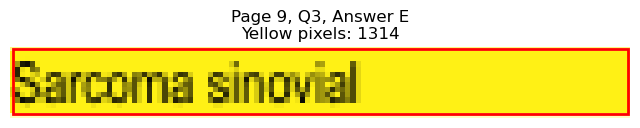


Page 9, Q3 - Selected Answer: E (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=413.3, x1=141.8, y1=426.0
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 299
Page 9, Q4, A: Yellow percentage: 0.0%


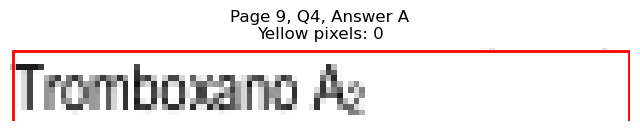

Page 9, Q4 - B: Detected box: x0=82.5, y0=425.9, x1=129.6, y1=438.6
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 241
Page 9, Q4, B: Yellow percentage: 0.0%


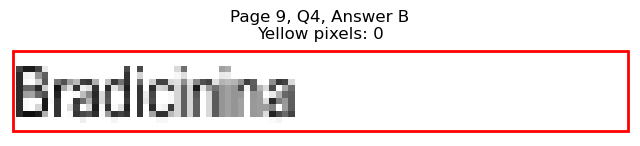

Page 9, Q4 - C: Detected box: x0=82.9, y0=438.5, x1=138.7, y1=451.2
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 293
Page 9, Q4, C: Yellow percentage: 0.0%


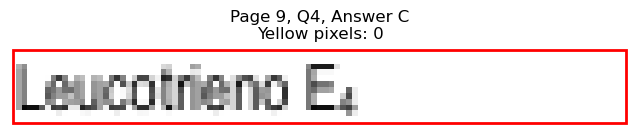

Page 9, Q4 - D: Detected box: x0=334.6, y0=413.3, x1=387.8, y1=426.0
Page 9, Q4, D: Yellow pixels: 1153
Page 9, Q4, D: Total non-white pixels: 1352
Page 9, Q4, D: Yellow percentage: 85.3%


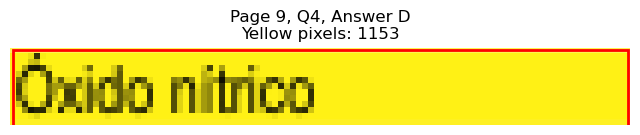

Page 9, Q4 - E: Detected box: x0=334.1, y0=425.9, x1=455.6, y1=438.6
Page 9, Q4, E: Yellow pixels: 172
Page 9, Q4, E: Total non-white pixels: 781
Page 9, Q4, E: Yellow percentage: 22.0%


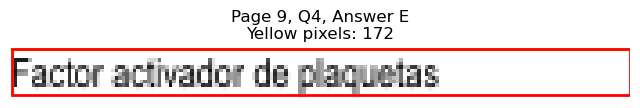


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=182.3, y1=489.0
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 509
Page 9, Q5, A: Yellow percentage: 0.0%


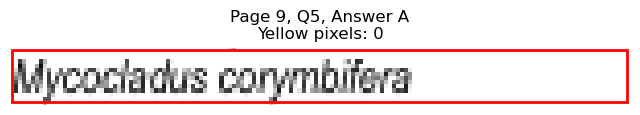

Page 9, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=170.8, y1=501.7
Page 9, Q5, B: Yellow pixels: 1434
Page 9, Q5, B: Total non-white pixels: 1807
Page 9, Q5, B: Yellow percentage: 79.4%


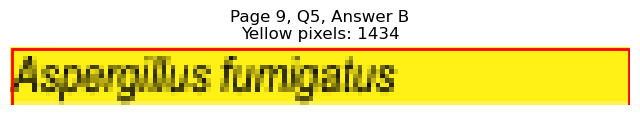

Page 9, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=190.7, y1=514.3
Page 9, Q5, C: Yellow pixels: 155
Page 9, Q5, C: Total non-white pixels: 699
Page 9, Q5, C: Yellow percentage: 22.2%


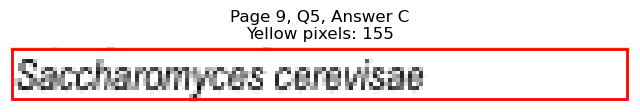

Page 9, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=422.8, y1=489.0
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 461
Page 9, Q5, D: Yellow percentage: 0.0%


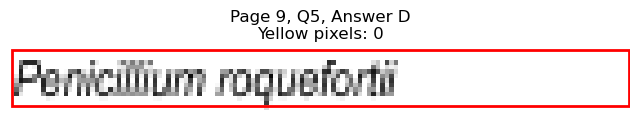

Page 9, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=403.9, y1=501.7
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 337
Page 9, Q5, E: Yellow percentage: 0.0%


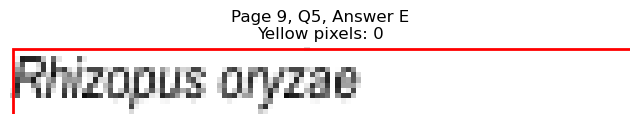


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=552.2, x1=116.1, y1=564.8
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 120
Page 9, Q6, A: Yellow percentage: 0.0%


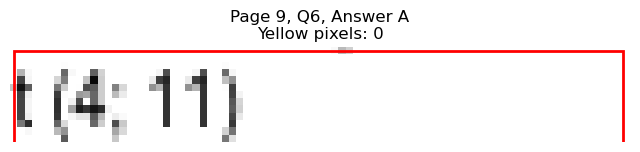

Page 9, Q6 - B: Detected box: x0=82.5, y0=564.8, x1=121.1, y1=577.4
Page 9, Q6, B: Yellow pixels: 90
Page 9, Q6, B: Total non-white pixels: 243
Page 9, Q6, B: Yellow percentage: 37.0%


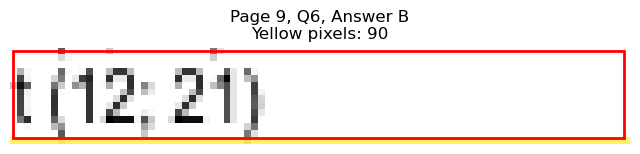

Page 9, Q6 - C: Detected box: x0=82.9, y0=577.4, x1=116.5, y1=590.0
Page 9, Q6, C: Yellow pixels: 978
Page 9, Q6, C: Total non-white pixels: 1108
Page 9, Q6, C: Yellow percentage: 88.3%


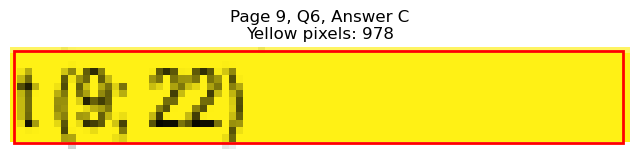

Page 9, Q6 - D: Detected box: x0=334.6, y0=552.2, x1=392.3, y1=564.8
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 325
Page 9, Q6, D: Yellow percentage: 0.0%


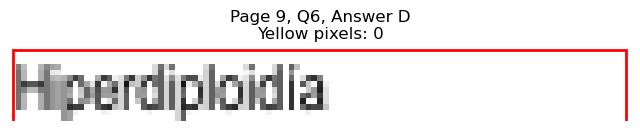

Page 9, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=388.9, y1=577.4
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 322
Page 9, Q6, E: Yellow percentage: 0.0%


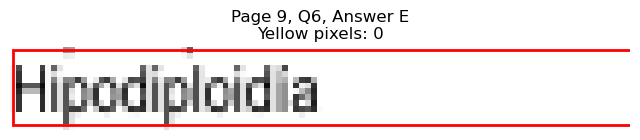


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=615.2, x1=153.6, y1=627.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 389
Page 9, Q7, A: Yellow percentage: 0.0%


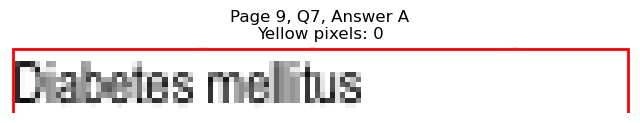

Page 9, Q7 - B: Detected box: x0=82.5, y0=627.9, x1=190.8, y1=640.6
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 525
Page 9, Q7, B: Yellow percentage: 0.0%


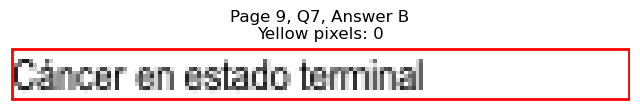

Page 9, Q7 - C: Detected box: x0=82.9, y0=640.5, x1=201.9, y1=653.2
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 576
Page 9, Q7, C: Yellow percentage: 0.0%


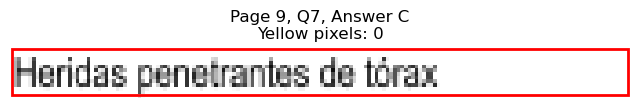

Page 9, Q7 - D: Detected box: x0=334.6, y0=615.2, x1=457.0, y1=627.8
Page 9, Q7, D: Yellow pixels: 1806
Page 9, Q7, D: Total non-white pixels: 2262
Page 9, Q7, D: Yellow percentage: 79.8%


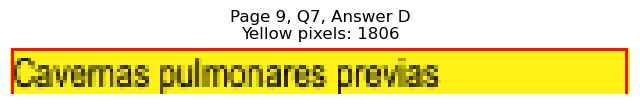

Page 9, Q7 - E: Detected box: x0=334.1, y0=627.9, x1=472.5, y1=640.6
Page 9, Q7, E: Yellow pixels: 187
Page 9, Q7, E: Total non-white pixels: 883
Page 9, Q7, E: Yellow percentage: 21.2%


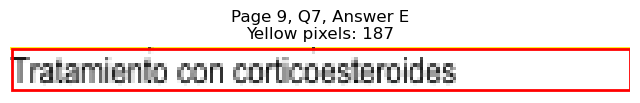


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=193.8, y1=728.9
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 550
Page 9, Q8, A: Yellow percentage: 0.0%


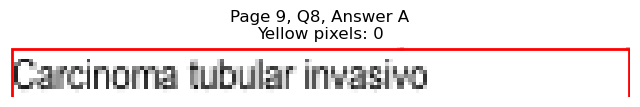

Page 9, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=175.7, y1=741.5
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 483
Page 9, Q8, B: Yellow percentage: 0.0%


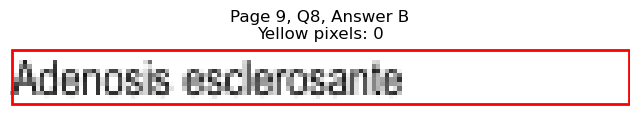

Page 9, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=186.3, y1=754.1
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 524
Page 9, Q8, C: Yellow percentage: 0.0%


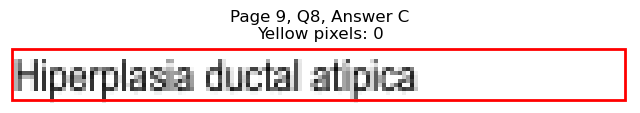

Page 9, Q8 - D: Detected box: x0=334.6, y0=716.3, x1=435.9, y1=728.9
Page 9, Q8, D: Yellow pixels: 1591
Page 9, Q8, D: Total non-white pixels: 1976
Page 9, Q8, D: Yellow percentage: 80.5%


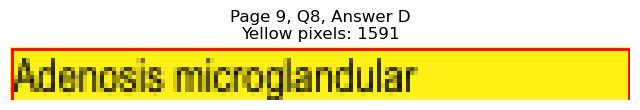

Page 9, Q8 - E: Detected box: x0=334.1, y0=728.9, x1=440.1, y1=741.5
Page 9, Q8, E: Yellow pixels: 153
Page 9, Q8, E: Total non-white pixels: 743
Page 9, Q8, E: Yellow percentage: 20.6%


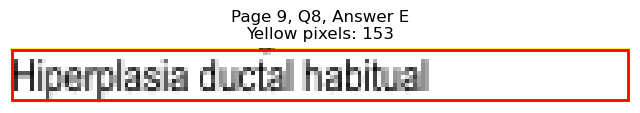


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=164.7, y1=110.4
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 413
Page 10, Q1, A: Yellow percentage: 0.0%


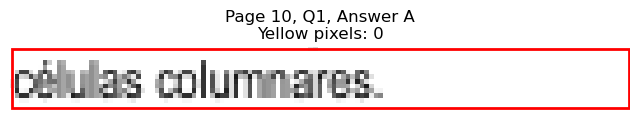

Page 10, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=136.6, y1=123.0
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 265
Page 10, Q1, B: Yellow percentage: 0.0%


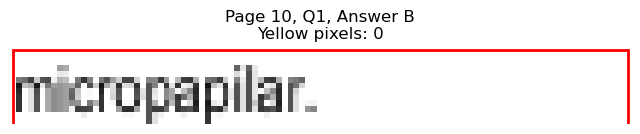

Page 10, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=151.7, y1=135.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 348
Page 10, Q1, C: Yellow percentage: 0.0%


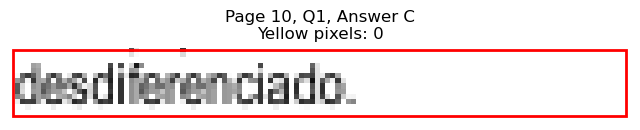

Page 10, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=363.2, y1=110.4
Page 10, Q1, D: Yellow pixels: 80
Page 10, Q1, D: Total non-white pixels: 219
Page 10, Q1, D: Yellow percentage: 36.5%


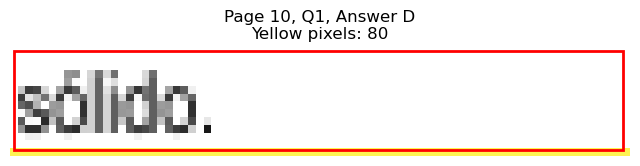

Page 10, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=370.3, y1=123.0
Page 10, Q1, E: Yellow pixels: 998
Page 10, Q1, E: Total non-white pixels: 1131
Page 10, Q1, E: Yellow percentage: 88.2%


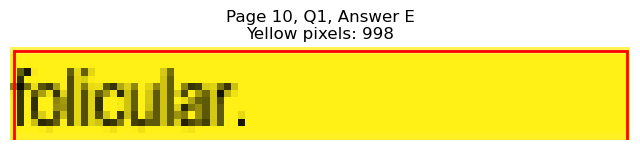


Page 10, Q1 - Selected Answer: E (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=144.6, y1=173.5
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 310
Page 10, Q2, A: Yellow percentage: 0.0%


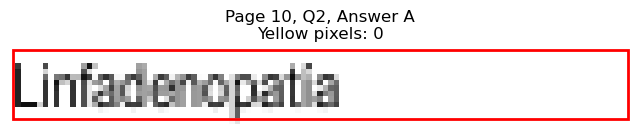

Page 10, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=146.7, y1=186.1
Page 10, Q2, B: Yellow pixels: 115
Page 10, Q2, B: Total non-white pixels: 440
Page 10, Q2, B: Yellow percentage: 26.1%


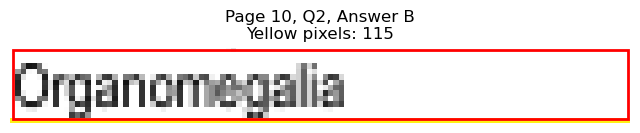

Page 10, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=269.6, y1=198.7
Page 10, Q2, C: Yellow pixels: 1766
Page 10, Q2, C: Total non-white pixels: 2509
Page 10, Q2, C: Yellow percentage: 70.4%


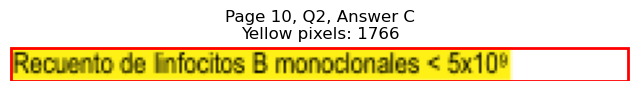

Page 10, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=438.4, y1=173.5
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 487
Page 10, Q2, D: Yellow percentage: 0.0%


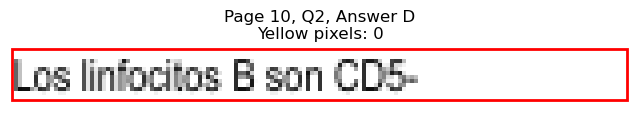

Page 10, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=521.4, y1=186.1
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 915
Page 10, Q2, E: Yellow percentage: 0.0%


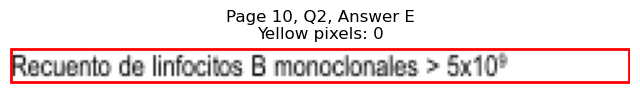


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=163.7, y1=249.2
Page 10, Q3, A: Yellow pixels: 132
Page 10, Q3, A: Total non-white pixels: 541
Page 10, Q3, A: Yellow percentage: 24.4%


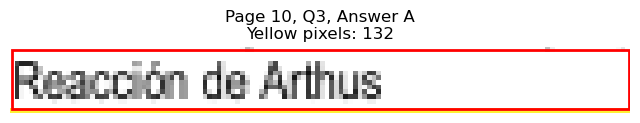

Page 10, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=208.8, y1=261.8
Page 10, Q3, B: Yellow pixels: 1821
Page 10, Q3, B: Total non-white pixels: 2301
Page 10, Q3, B: Yellow percentage: 79.1%


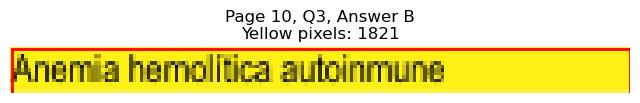

Page 10, Q3 - C: Detected box: x0=82.9, y0=261.7, x1=162.1, y1=274.4
Page 10, Q3, C: Yellow pixels: 131
Page 10, Q3, C: Total non-white pixels: 561
Page 10, Q3, C: Yellow percentage: 23.4%


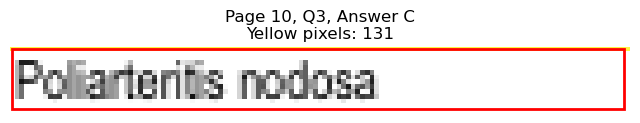

Page 10, Q3 - D: Detected box: x0=334.6, y0=236.5, x1=425.9, y1=249.2
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 452
Page 10, Q3, D: Yellow percentage: 0.0%


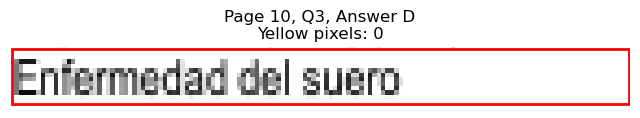

Page 10, Q3 - E: Detected box: x0=334.1, y0=249.1, x1=451.0, y1=261.8
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 583
Page 10, Q3, E: Yellow percentage: 0.0%


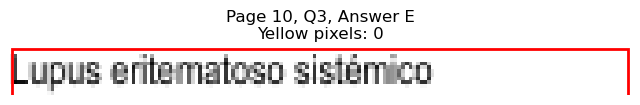


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=193.3, y1=337.5
Page 10, Q4, A: Yellow pixels: 1646
Page 10, Q4, A: Total non-white pixels: 2268
Page 10, Q4, A: Yellow percentage: 72.6%


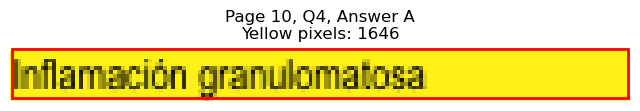

Page 10, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=216.3, y1=350.1
Page 10, Q4, B: Yellow pixels: 184
Page 10, Q4, B: Total non-white pixels: 892
Page 10, Q4, B: Yellow percentage: 20.6%


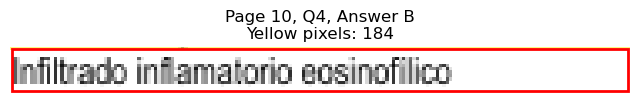

Page 10, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=115.6, y1=362.9
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 162
Page 10, Q4, C: Yellow percentage: 0.0%


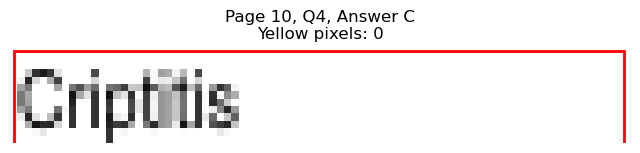

Page 10, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=413.3, y1=337.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 442
Page 10, Q4, D: Yellow percentage: 0.0%


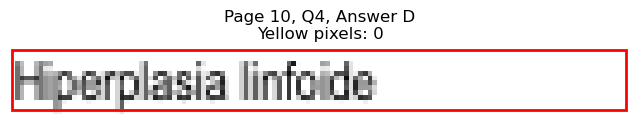

Page 10, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=395.3, y1=350.1
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 354
Page 10, Q4, E: Yellow percentage: 0.0%


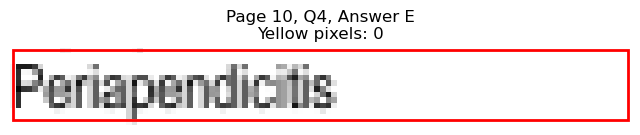


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=174.7, y1=426.0
Page 10, Q5, A: Yellow pixels: 1496
Page 10, Q5, A: Total non-white pixels: 1859
Page 10, Q5, A: Yellow percentage: 80.5%


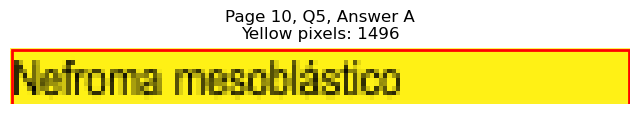

Page 10, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=148.7, y1=438.6
Page 10, Q5, B: Yellow pixels: 117
Page 10, Q5, B: Total non-white pixels: 441
Page 10, Q5, B: Yellow percentage: 26.5%


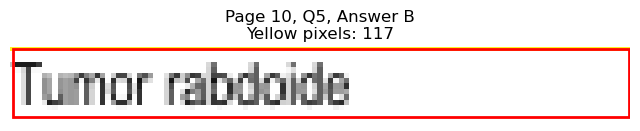

Page 10, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=191.3, y1=451.2
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 544
Page 10, Q5, C: Yellow percentage: 0.0%


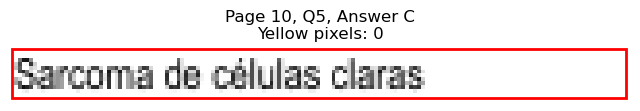

Page 10, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=402.8, y1=426.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 316
Page 10, Q5, D: Yellow percentage: 0.0%


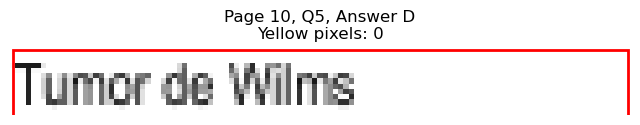

Page 10, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=397.9, y1=438.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 336
Page 10, Q5, E: Yellow percentage: 0.0%


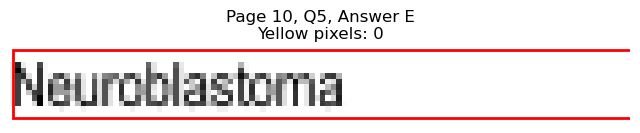


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=156.6, y1=514.3
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 394
Page 10, Q6, A: Yellow percentage: 0.0%


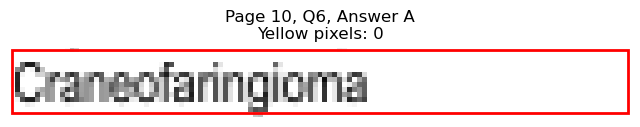

Page 10, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=162.7, y1=526.9
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 402
Page 10, Q6, B: Yellow percentage: 0.0%


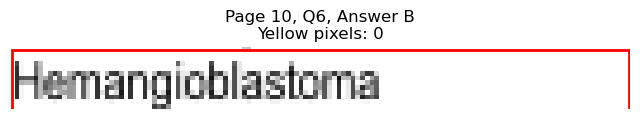

Page 10, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=182.8, y1=539.5
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 543
Page 10, Q6, C: Yellow percentage: 0.0%


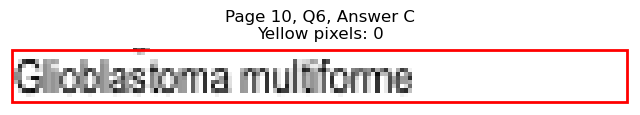

Page 10, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=412.9, y1=514.3
Page 10, Q6, D: Yellow pixels: 129
Page 10, Q6, D: Total non-white pixels: 562
Page 10, Q6, D: Yellow percentage: 23.0%


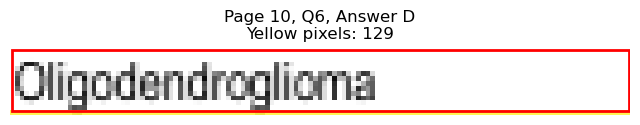

Page 10, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=402.9, y1=526.9
Page 10, Q6, E: Yellow pixels: 1288
Page 10, Q6, E: Total non-white pixels: 1547
Page 10, Q6, E: Yellow percentage: 83.3%


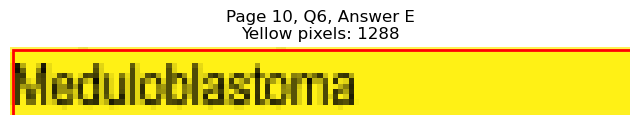


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=103.0, y1=590.0
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 83
Page 10, Q7, A: Yellow percentage: 0.0%


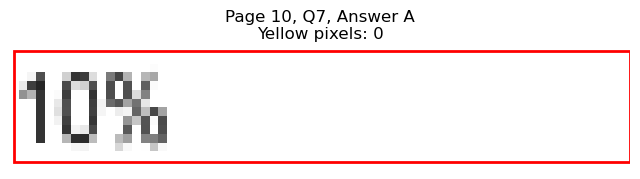

Page 10, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=103.0, y1=602.6
Page 10, Q7, B: Yellow pixels: 71
Page 10, Q7, B: Total non-white pixels: 170
Page 10, Q7, B: Yellow percentage: 41.8%


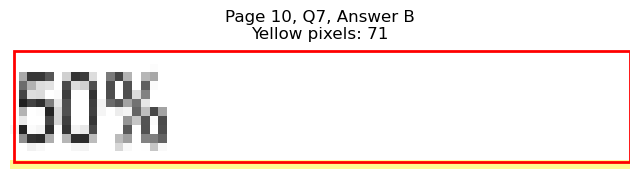

Page 10, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=103.5, y1=615.2
Page 10, Q7, C: Yellow pixels: 854
Page 10, Q7, C: Total non-white pixels: 1008
Page 10, Q7, C: Yellow percentage: 84.7%


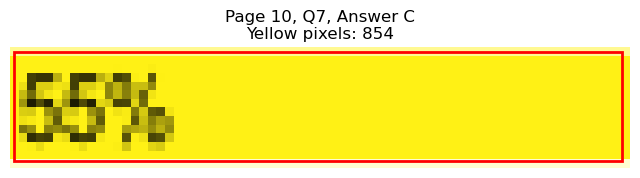

Page 10, Q7 - D: Detected box: x0=334.6, y0=577.4, x1=350.2, y1=590.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 78
Page 10, Q7, D: Yellow percentage: 0.0%


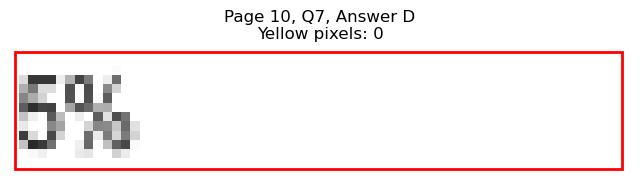

Page 10, Q7 - E: Detected box: x0=334.1, y0=590.0, x1=354.7, y1=602.6
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 112
Page 10, Q7, E: Yellow percentage: 0.0%


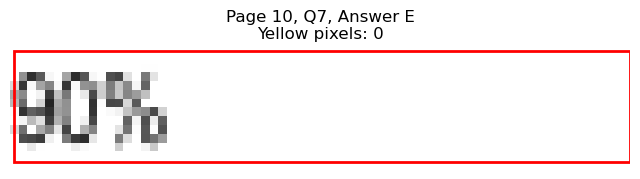


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.5, y0=665.7, x1=180.7, y1=678.4
Page 10, Q8, A: Yellow pixels: 149
Page 10, Q8, A: Total non-white pixels: 642
Page 10, Q8, A: Yellow percentage: 23.2%


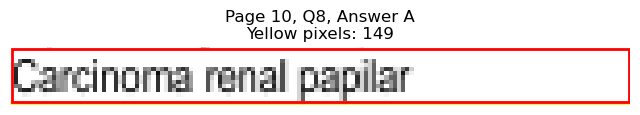

Page 10, Q8 - B: Detected box: x0=82.5, y0=678.3, x1=216.4, y1=691.0
Page 10, Q8, B: Yellow pixels: 1932
Page 10, Q8, B: Total non-white pixels: 2405
Page 10, Q8, B: Yellow percentage: 80.3%


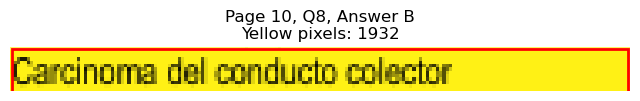

Page 10, Q8 - C: Detected box: x0=82.9, y0=691.1, x1=129.1, y1=703.7
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 504
Page 10, Q8, C: Yellow percentage: 0.0%


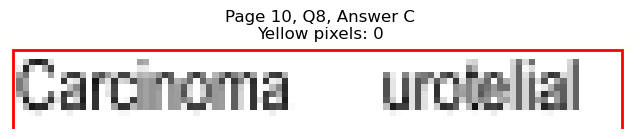

Page 10, Q8 - D: Detected box: x0=334.6, y0=665.7, x1=431.3, y1=678.4
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 493
Page 10, Q8, D: Yellow percentage: 0.0%


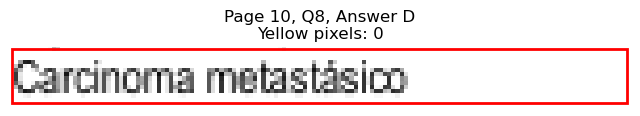

Page 10, Q8 - E: Detected box: x0=334.1, y0=678.3, x1=504.7, y1=691.0
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 842
Page 10, Q8, E: Yellow percentage: 0.0%


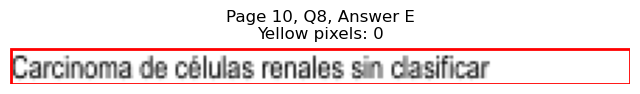


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=174.7, y1=135.6
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 476
Page 11, Q1, A: Yellow percentage: 0.0%


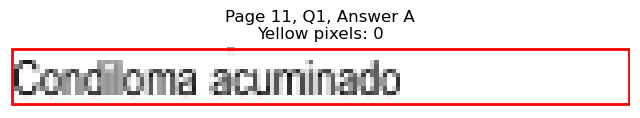

Page 11, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=164.8, y1=148.2
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 428
Page 11, Q1, B: Yellow percentage: 0.0%


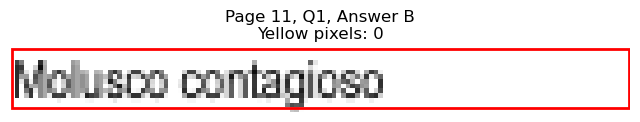

Page 11, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=159.1, y1=160.9
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 381
Page 11, Q1, C: Yellow percentage: 0.0%


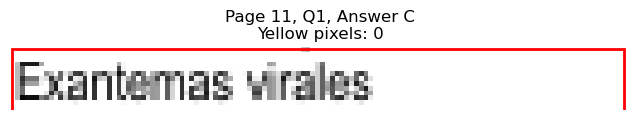

Page 11, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=409.4, y1=135.6
Page 11, Q1, D: Yellow pixels: 126
Page 11, Q1, D: Total non-white pixels: 500
Page 11, Q1, D: Yellow percentage: 25.2%


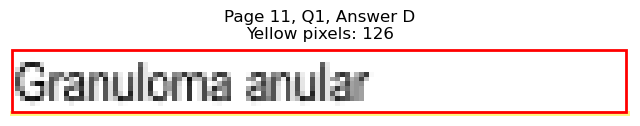

Page 11, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=463.0, y1=148.2
Page 11, Q1, E: Yellow pixels: 1810
Page 11, Q1, E: Total non-white pixels: 2520
Page 11, Q1, E: Yellow percentage: 71.8%


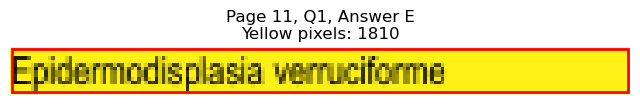


Page 11, Q1 - Selected Answer: E (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=210.9, y1=236.6
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 668
Page 11, Q2, A: Yellow percentage: 0.0%


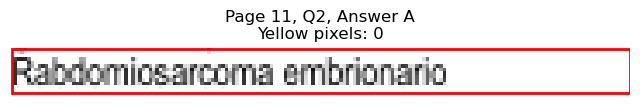

Page 11, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=129.1, y1=249.2
Page 11, Q2, B: Yellow pixels: 98
Page 11, Q2, B: Total non-white pixels: 314
Page 11, Q2, B: Yellow percentage: 31.2%


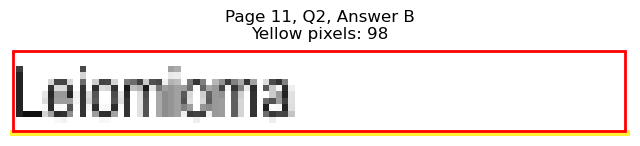

Page 11, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=181.2, y1=261.8
Page 11, Q2, C: Yellow pixels: 1554
Page 11, Q2, C: Total non-white pixels: 1950
Page 11, Q2, C: Yellow percentage: 79.7%


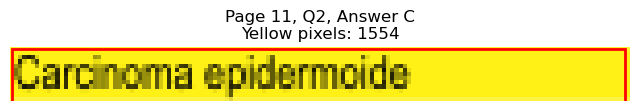

Page 11, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=409.4, y1=236.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 389
Page 11, Q2, D: Yellow percentage: 0.0%


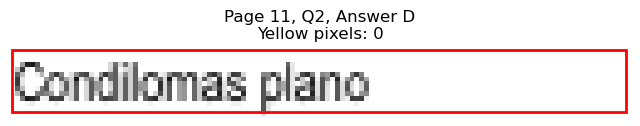

Page 11, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=449.9, y1=249.2
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 569
Page 11, Q2, E: Yellow percentage: 0.0%


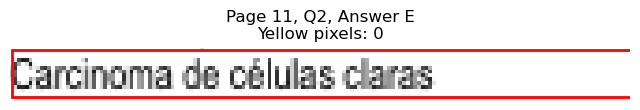


Page 11, Q2 - Selected Answer: C (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=122.1, y1=312.3
Page 11, Q3, A: Yellow pixels: 91
Page 11, Q3, A: Total non-white pixels: 307
Page 11, Q3, A: Yellow percentage: 29.6%


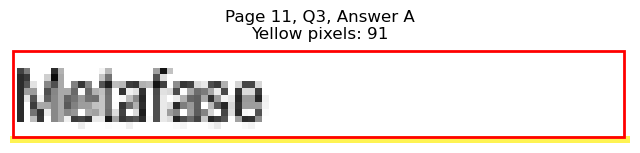

Page 11, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=118.1, y1=324.9
Page 11, Q3, B: Yellow pixels: 993
Page 11, Q3, B: Total non-white pixels: 1131
Page 11, Q3, B: Yellow percentage: 87.8%


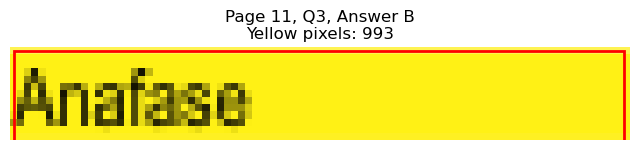

Page 11, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=116.5, y1=337.5
Page 11, Q3, C: Yellow pixels: 85
Page 11, Q3, C: Total non-white pixels: 256
Page 11, Q3, C: Yellow percentage: 33.2%


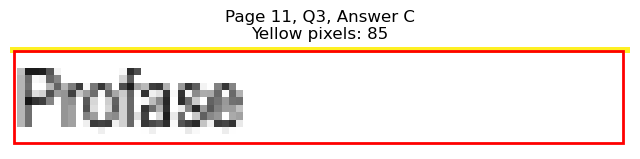

Page 11, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=388.3, y1=312.3
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 270
Page 11, Q3, D: Yellow percentage: 0.0%


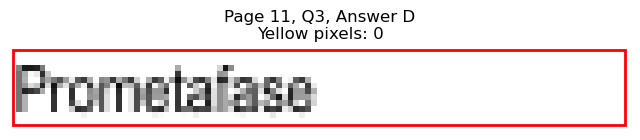

Page 11, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=371.2, y1=324.9
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 191
Page 11, Q3, E: Yellow percentage: 0.0%


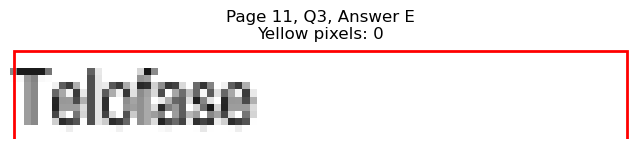


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=151.2, y1=400.7
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 502
Page 11, Q4, A: Yellow percentage: 0.0%


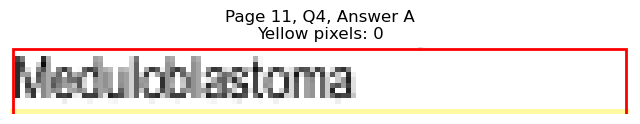

Page 11, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=156.6, y1=413.3
Page 11, Q4, B: Yellow pixels: 1207
Page 11, Q4, B: Total non-white pixels: 1750
Page 11, Q4, B: Yellow percentage: 69.0%


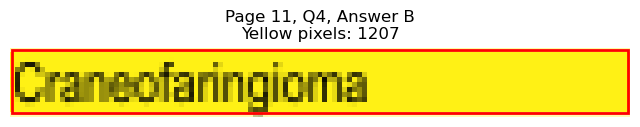

Page 11, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=138.6, y1=426.0
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 398
Page 11, Q4, C: Yellow percentage: 0.0%


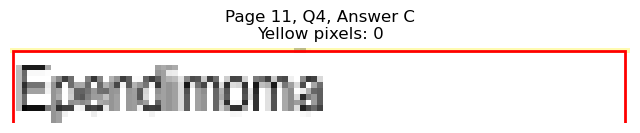

Page 11, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=412.9, y1=400.7
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 441
Page 11, Q4, D: Yellow percentage: 0.0%


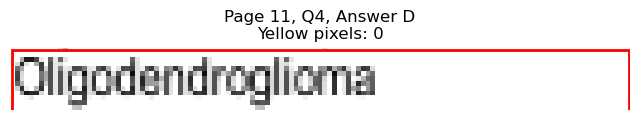

Page 11, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=421.9, y1=413.3
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 457
Page 11, Q4, E: Yellow percentage: 0.0%


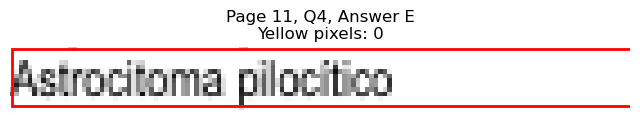


Page 11, Q4 - Selected Answer: B (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.5, y0=463.7, x1=206.3, y1=476.4
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 630
Page 11, Q5, A: Yellow percentage: 0.0%


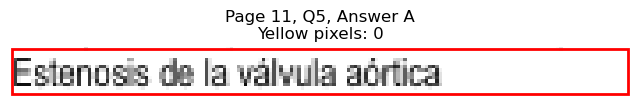

Page 11, Q5 - B: Detected box: x0=82.5, y0=476.3, x1=201.3, y1=489.0
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 592
Page 11, Q5, B: Yellow percentage: 0.0%


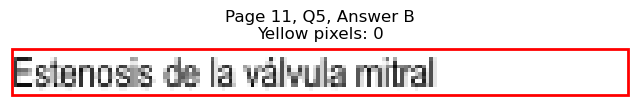

Page 11, Q5 - C: Detected box: x0=82.9, y0=489.1, x1=227.9, y1=501.7
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 715
Page 11, Q5, C: Yellow percentage: 0.0%


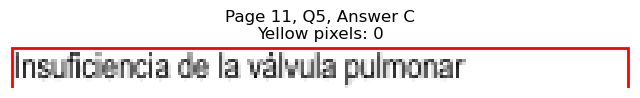

Page 11, Q5 - D: Detected box: x0=334.6, y0=463.7, x1=469.1, y1=476.4
Page 11, Q5, D: Yellow pixels: 186
Page 11, Q5, D: Total non-white pixels: 865
Page 11, Q5, D: Yellow percentage: 21.5%


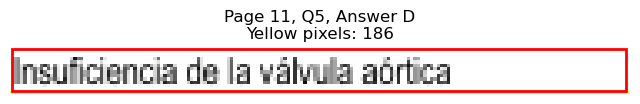

Page 11, Q5 - E: Detected box: x0=334.1, y0=476.3, x1=480.2, y1=489.0
Page 11, Q5, E: Yellow pixels: 1942
Page 11, Q5, E: Total non-white pixels: 2688
Page 11, Q5, E: Yellow percentage: 72.2%


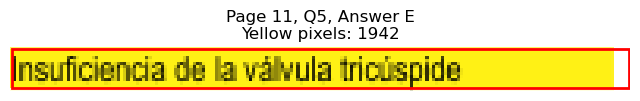


Page 11, Q5 - Selected Answer: E (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=148.7, y1=552.1
Page 11, Q6, A: Yellow pixels: 1283
Page 11, Q6, A: Total non-white pixels: 1638
Page 11, Q6, A: Yellow percentage: 78.3%


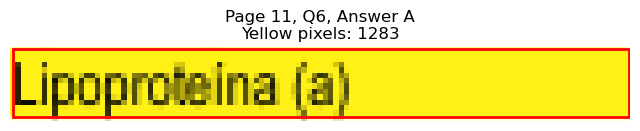

Page 11, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=135.6, y1=564.8
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 352
Page 11, Q6, B: Yellow percentage: 0.0%


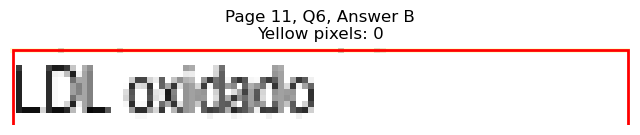

Page 11, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=159.1, y1=577.4
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 424
Page 11, Q6, C: Yellow percentage: 0.0%


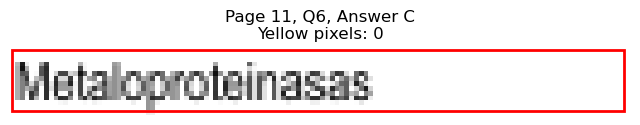

Page 11, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=414.4, y1=552.1
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 383
Page 11, Q6, D: Yellow percentage: 0.0%


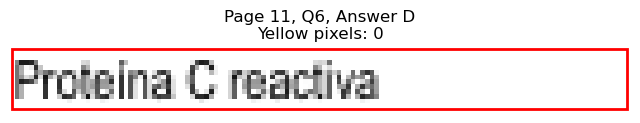

Page 11, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=391.9, y1=564.8
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 290
Page 11, Q6, E: Yellow percentage: 0.0%


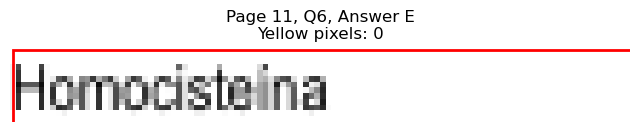


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=178.2, y1=665.8
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 481
Page 11, Q7, A: Yellow percentage: 0.0%


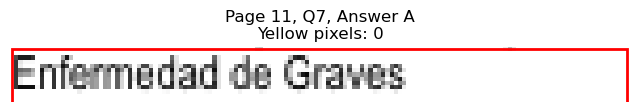

Page 11, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=180.7, y1=678.4
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 506
Page 11, Q7, B: Yellow percentage: 0.0%


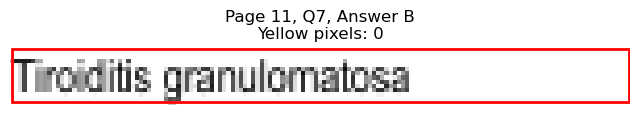

Page 11, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=146.7, y1=691.0
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 321
Page 11, Q7, C: Yellow percentage: 0.0%


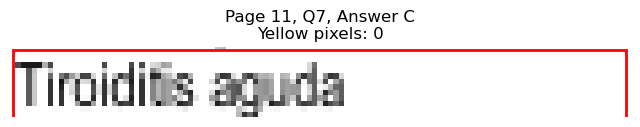

Page 11, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=428.9, y1=665.8
Page 11, Q7, D: Yellow pixels: 1528
Page 11, Q7, D: Total non-white pixels: 1885
Page 11, Q7, D: Yellow percentage: 81.1%


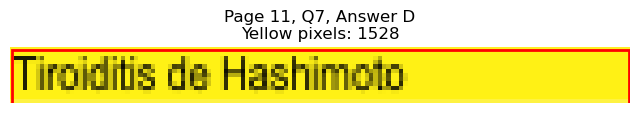

Page 11, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=410.8, y1=678.4
Page 11, Q7, E: Yellow pixels: 127
Page 11, Q7, E: Total non-white pixels: 534
Page 11, Q7, E: Yellow percentage: 23.8%


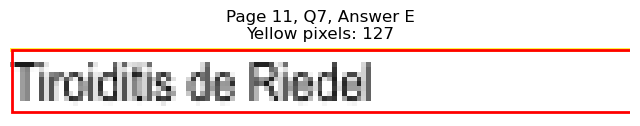


Page 11, Q7 - Selected Answer: D (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=145.1, y1=754.1
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 326
Page 11, Q8, A: Yellow percentage: 0.0%


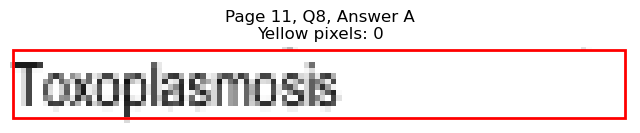

Page 11, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=187.8, y1=766.7
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 547
Page 11, Q8, B: Yellow percentage: 0.0%


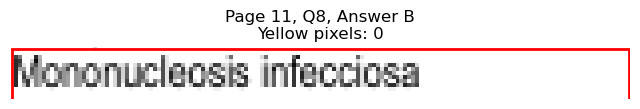

Page 11, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=208.4, y1=779.4
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 643
Page 11, Q8, C: Yellow percentage: 0.0%


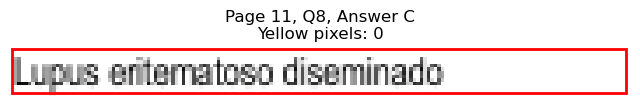

Page 11, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=429.4, y1=754.1
Page 11, Q8, D: Yellow pixels: 146
Page 11, Q8, D: Total non-white pixels: 638
Page 11, Q8, D: Yellow percentage: 22.9%


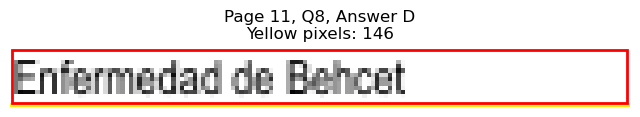

Page 11, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=437.1, y1=766.7
Page 11, Q8, E: Yellow pixels: 1593
Page 11, Q8, E: Total non-white pixels: 2002
Page 11, Q8, E: Yellow percentage: 79.6%


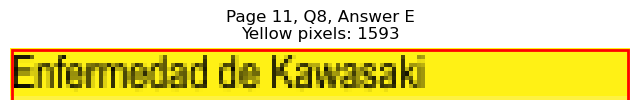


Page 11, Q8 - Selected Answer: E (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=148.7, y1=110.4
Page 12, Q1, A: Yellow pixels: 117
Page 12, Q1, A: Total non-white pixels: 477
Page 12, Q1, A: Yellow percentage: 24.5%


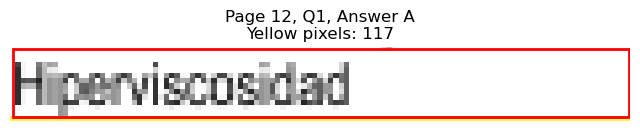

Page 12, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=281.3, y1=123.0
Page 12, Q1, B: Yellow pixels: 2486
Page 12, Q1, B: Total non-white pixels: 3250
Page 12, Q1, B: Yellow percentage: 76.5%


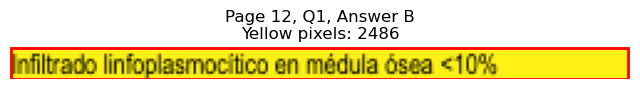

Page 12, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=177.7, y1=135.6
Page 12, Q1, C: Yellow pixels: 144
Page 12, Q1, C: Total non-white pixels: 667
Page 12, Q1, C: Yellow percentage: 21.6%


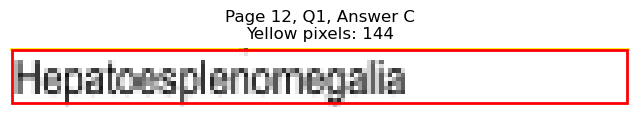

Page 12, Q1 - D: Detected box: x0=82.9, y0=135.5, x1=317.4, y1=148.2
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 1148
Page 12, Q1, D: Yellow percentage: 0.0%


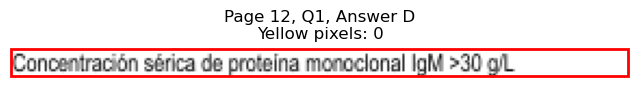

Page 12, Q1 - E: Detected box: x0=82.5, y0=148.2, x1=115.6, y1=160.9
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 155
Page 12, Q1, E: Yellow percentage: 0.0%


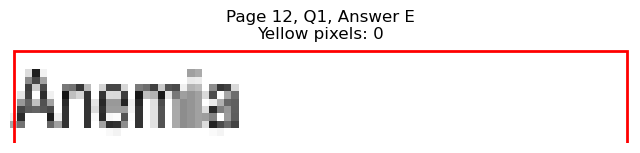


Page 12, Q1 - Selected Answer: B (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=163.7, y1=211.3
Page 12, Q2, A: Yellow pixels: 1268
Page 12, Q2, A: Total non-white pixels: 1848
Page 12, Q2, A: Yellow percentage: 68.6%


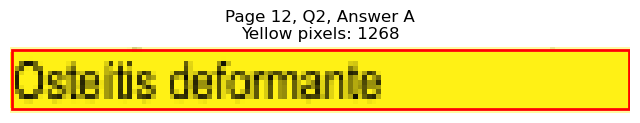

Page 12, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=142.1, y1=224.0
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 431
Page 12, Q2, B: Yellow percentage: 0.0%


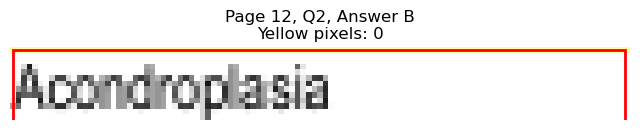

Page 12, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=141.1, y1=236.6
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 316
Page 12, Q2, C: Yellow percentage: 0.0%


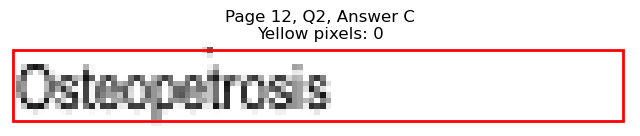

Page 12, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=423.4, y1=211.3
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 480
Page 12, Q2, D: Yellow percentage: 0.0%


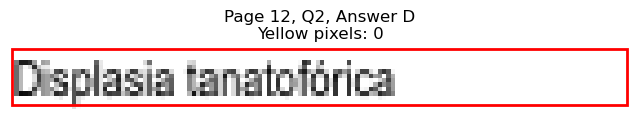

Page 12, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=409.9, y1=224.0
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 400
Page 12, Q2, E: Yellow percentage: 0.0%


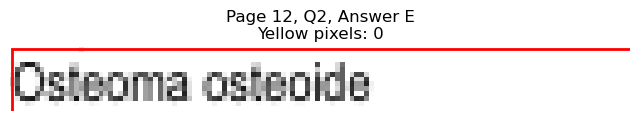


Page 12, Q2 - Selected Answer: A (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=211.8, y1=287.1
Page 12, Q3, A: Yellow pixels: 1787
Page 12, Q3, A: Total non-white pixels: 2520
Page 12, Q3, A: Yellow percentage: 70.9%


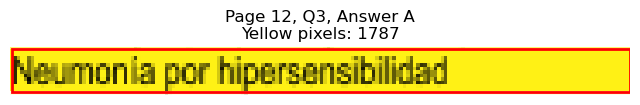

Page 12, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=167.2, y1=299.7
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 563
Page 12, Q3, B: Yellow percentage: 0.0%


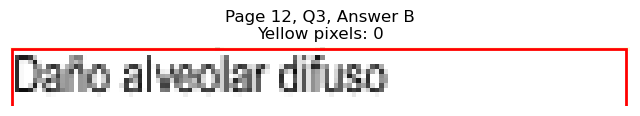

Page 12, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=200.8, y1=312.3
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 618
Page 12, Q3, C: Yellow percentage: 0.0%


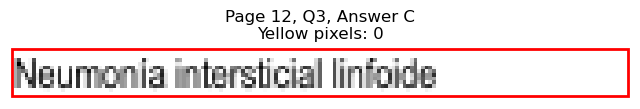

Page 12, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=383.8, y1=287.1
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 256
Page 12, Q3, D: Yellow percentage: 0.0%


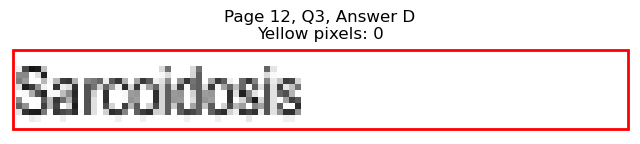

Page 12, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=455.0, y1=299.7
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 613
Page 12, Q3, E: Yellow percentage: 0.0%


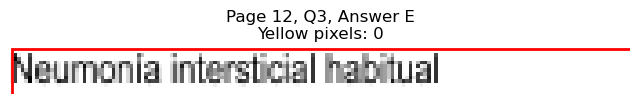


Page 12, Q3 - Selected Answer: A (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=231.9, y1=400.7
Page 12, Q4, A: Yellow pixels: 6
Page 12, Q4, A: Total non-white pixels: 961
Page 12, Q4, A: Yellow percentage: 0.6%


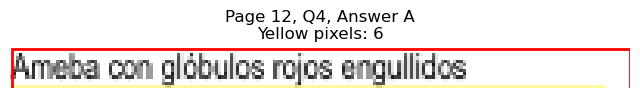

Page 12, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=201.4, y1=413.3
Page 12, Q4, B: Yellow pixels: 1603
Page 12, Q4, B: Total non-white pixels: 2380
Page 12, Q4, B: Yellow percentage: 67.4%


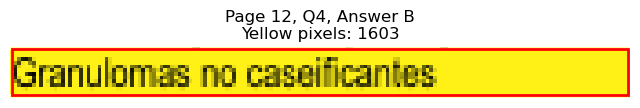

Page 12, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=218.8, y1=426.0
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 852
Page 12, Q4, C: Yellow percentage: 0.0%


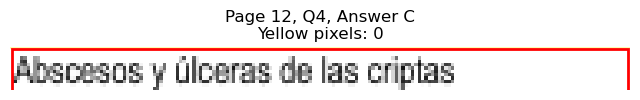

Page 12, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=469.1, y1=400.7
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 722
Page 12, Q4, D: Yellow percentage: 0.0%


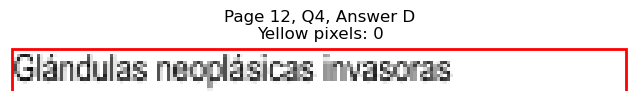

Page 12, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=516.2, y1=413.3
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 917
Page 12, Q4, E: Yellow percentage: 0.0%


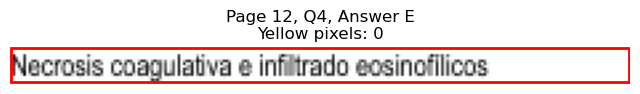


Page 12, Q4 - Selected Answer: B (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=239.6, y1=463.8
Page 12, Q5, A: Yellow pixels: 0
Page 12, Q5, A: Total non-white pixels: 810
Page 12, Q5, A: Yellow percentage: 0.0%


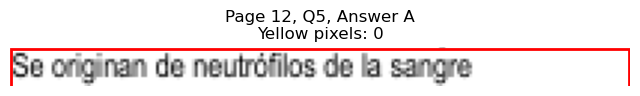

Page 12, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=189.7, y1=476.4
Page 12, Q5, B: Yellow pixels: 158
Page 12, Q5, B: Total non-white pixels: 707
Page 12, Q5, B: Yellow percentage: 22.3%


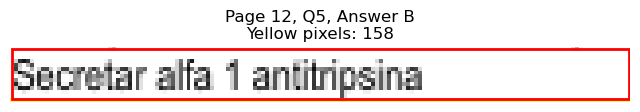

Page 12, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=155.7, y1=489.0
Page 12, Q5, C: Yellow pixels: 1324
Page 12, Q5, C: Total non-white pixels: 1736
Page 12, Q5, C: Yellow percentage: 76.3%


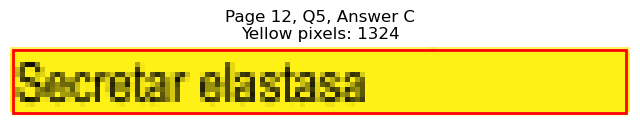

Page 12, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=519.2, y1=463.8
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 940
Page 12, Q5, D: Yellow percentage: 0.0%


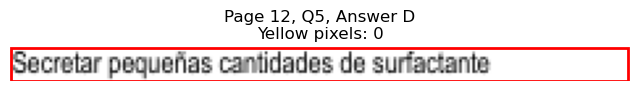

Page 12, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=526.9, y1=476.4
Page 12, Q5, E: Yellow pixels: 0
Page 12, Q5, E: Total non-white pixels: 924
Page 12, Q5, E: Yellow percentage: 0.0%


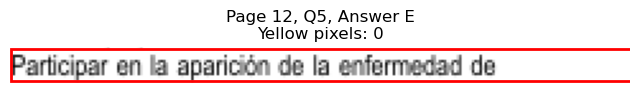


Page 12, Q5 - Selected Answer: C (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=190.3, y1=552.1
Page 12, Q6, A: Yellow pixels: 0
Page 12, Q6, A: Total non-white pixels: 567
Page 12, Q6, A: Yellow percentage: 0.0%


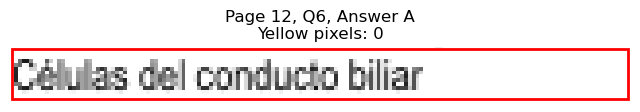

Page 12, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=132.6, y1=564.8
Page 12, Q6, B: Yellow pixels: 0
Page 12, Q6, B: Total non-white pixels: 369
Page 12, Q6, B: Yellow percentage: 0.0%


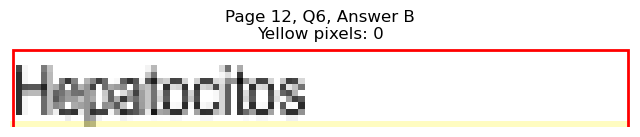

Page 12, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=161.7, y1=577.4
Page 12, Q6, C: Yellow pixels: 1269
Page 12, Q6, C: Total non-white pixels: 1820
Page 12, Q6, C: Yellow percentage: 69.7%


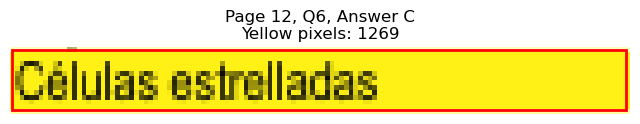

Page 12, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=384.3, y1=552.1
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 277
Page 12, Q6, D: Yellow percentage: 0.0%


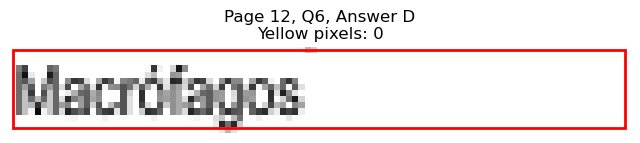

Page 12, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=403.4, y1=564.8
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 379
Page 12, Q6, E: Yellow percentage: 0.0%


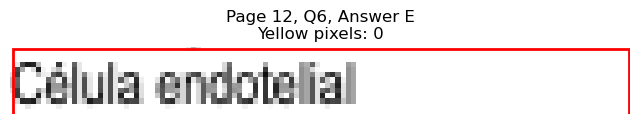


Page 12, Q6 - Selected Answer: C (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=82.5, y0=640.5, x1=173.3, y1=653.2
Page 12, Q7, A: Yellow pixels: 1472
Page 12, Q7, A: Total non-white pixels: 1988
Page 12, Q7, A: Yellow percentage: 74.0%


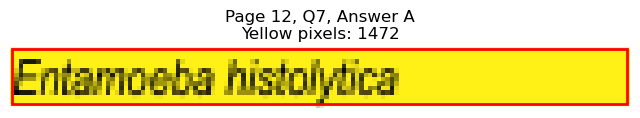

Page 12, Q7 - B: Detected box: x0=82.5, y0=653.1, x1=145.1, y1=665.8
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 316
Page 12, Q7, B: Yellow percentage: 0.0%


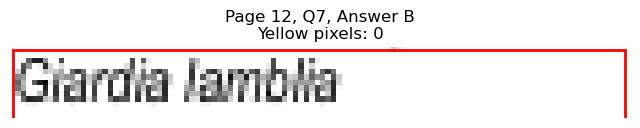

Page 12, Q7 - C: Detected box: x0=82.9, y0=665.7, x1=131.5, y1=678.4
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 237
Page 12, Q7, C: Yellow percentage: 0.0%


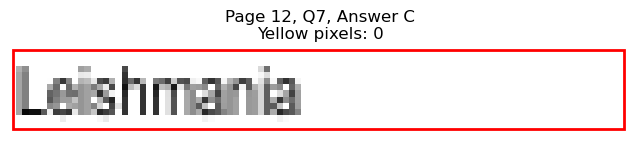

Page 12, Q7 - D: Detected box: x0=334.6, y0=640.5, x1=400.3, y1=653.2
Page 12, Q7, D: Yellow pixels: 0
Page 12, Q7, D: Total non-white pixels: 345
Page 12, Q7, D: Yellow percentage: 0.0%


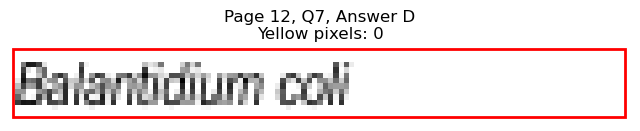

Page 12, Q7 - E: Detected box: x0=334.1, y0=653.1, x1=435.9, y1=665.8
Page 12, Q7, E: Yellow pixels: 0
Page 12, Q7, E: Total non-white pixels: 501
Page 12, Q7, E: Yellow percentage: 0.0%


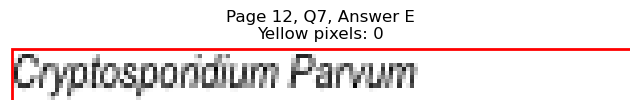


Page 12, Q7 - Selected Answer: A (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=194.8, y1=728.9
Page 12, Q8, A: Yellow pixels: 0
Page 12, Q8, A: Total non-white pixels: 553
Page 12, Q8, A: Yellow percentage: 0.0%


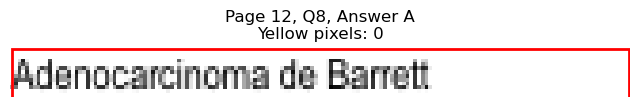

Page 12, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=267.0, y1=741.5
Page 12, Q8, B: Yellow pixels: 0
Page 12, Q8, B: Total non-white pixels: 920
Page 12, Q8, B: Yellow percentage: 0.0%


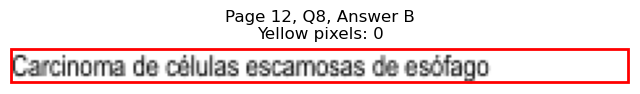

Page 12, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=153.2, y1=754.1
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 581
Page 12, Q8, C: Yellow percentage: 0.0%


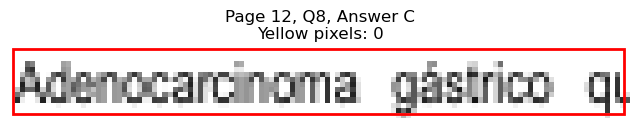

Page 12, Q8 - D: Detected box: x0=334.6, y0=716.3, x1=491.6, y1=728.9
Page 12, Q8, D: Yellow pixels: 0
Page 12, Q8, D: Total non-white pixels: 985
Page 12, Q8, D: Yellow percentage: 0.0%


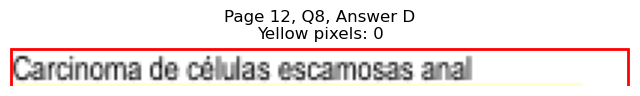

Page 12, Q8 - E: Detected box: x0=334.1, y0=728.9, x1=452.0, y1=741.5
Page 12, Q8, E: Yellow pixels: 1704
Page 12, Q8, E: Total non-white pixels: 2366
Page 12, Q8, E: Yellow percentage: 72.0%


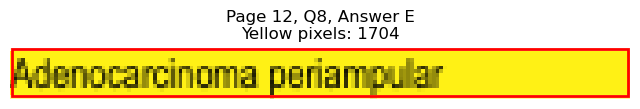


Page 12, Q8 - Selected Answer: E (based on yellow pixel count)





Page 13: Found 4 questions
Page 13, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=251.6, y1=148.2
Page 13, Q1, A: Yellow pixels: 1842
Page 13, Q1, A: Total non-white pixels: 2702
Page 13, Q1, A: Yellow percentage: 68.2%


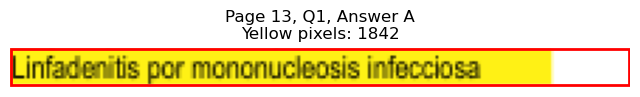

Page 13, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=211.4, y1=160.9
Page 13, Q1, B: Yellow pixels: 0
Page 13, Q1, B: Total non-white pixels: 833
Page 13, Q1, B: Yellow percentage: 0.0%


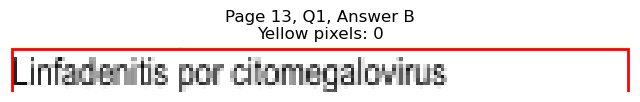

Page 13, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=230.9, y1=173.5
Page 13, Q1, C: Yellow pixels: 0
Page 13, Q1, C: Total non-white pixels: 758
Page 13, Q1, C: Yellow percentage: 0.0%


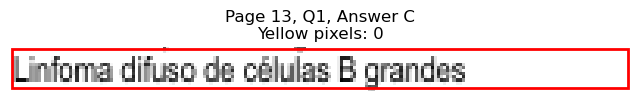

Page 13, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=447.4, y1=148.2
Page 13, Q1, D: Yellow pixels: 0
Page 13, Q1, D: Total non-white pixels: 565
Page 13, Q1, D: Yellow percentage: 0.0%


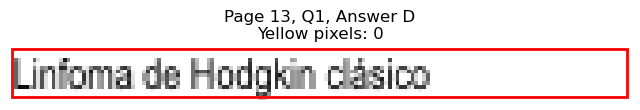

Page 13, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=449.5, y1=160.9
Page 13, Q1, E: Yellow pixels: 0
Page 13, Q1, E: Total non-white pixels: 588
Page 13, Q1, E: Yellow percentage: 0.0%


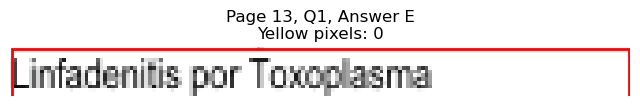


Page 13, Q1 - Selected Answer: A (based on yellow pixel count)




Page 13, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=118.6, y1=224.0
Page 13, Q2, A: Yellow pixels: 0
Page 13, Q2, A: Total non-white pixels: 181
Page 13, Q2, A: Yellow percentage: 0.0%


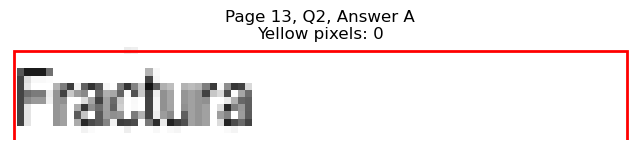

Page 13, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=126.6, y1=236.6
Page 13, Q2, B: Yellow pixels: 0
Page 13, Q2, B: Total non-white pixels: 204
Page 13, Q2, B: Yellow percentage: 0.0%


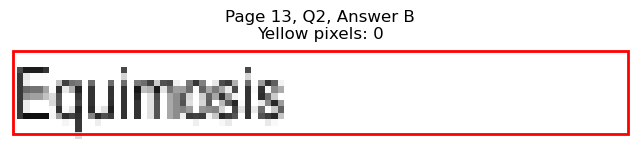

Page 13, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=146.2, y1=249.2
Page 13, Q2, C: Yellow pixels: 0
Page 13, Q2, C: Total non-white pixels: 304
Page 13, Q2, C: Yellow percentage: 0.0%


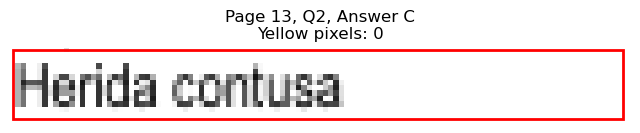

Page 13, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=383.8, y1=224.0
Page 13, Q2, D: Yellow pixels: 1112
Page 13, Q2, D: Total non-white pixels: 1300
Page 13, Q2, D: Yellow percentage: 85.5%


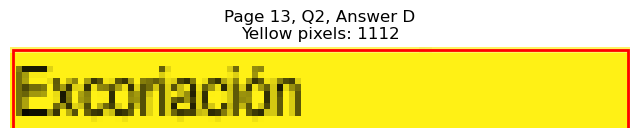

Page 13, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=380.9, y1=236.6
Page 13, Q2, E: Yellow pixels: 97
Page 13, Q2, E: Total non-white pixels: 323
Page 13, Q2, E: Yellow percentage: 30.0%


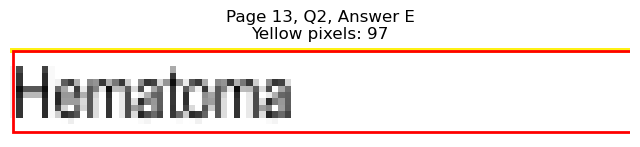


Page 13, Q2 - Selected Answer: D (based on yellow pixel count)




Page 13, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=183.7, y1=287.1
Page 13, Q3, A: Yellow pixels: 0
Page 13, Q3, A: Total non-white pixels: 513
Page 13, Q3, A: Yellow percentage: 0.0%


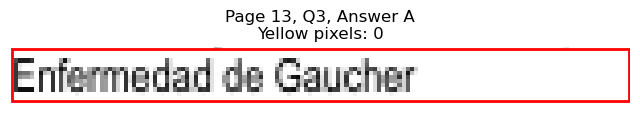

Page 13, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=158.2, y1=299.7
Page 13, Q3, B: Yellow pixels: 0
Page 13, Q3, B: Total non-white pixels: 380
Page 13, Q3, B: Yellow percentage: 0.0%


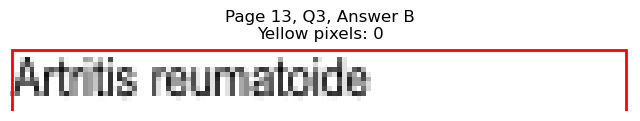

Page 13, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=131.1, y1=312.3
Page 13, Q3, C: Yellow pixels: 0
Page 13, Q3, C: Total non-white pixels: 236
Page 13, Q3, C: Yellow percentage: 0.0%


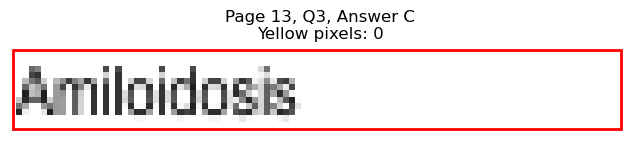

Page 13, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=451.5, y1=287.1
Page 13, Q3, D: Yellow pixels: 168
Page 13, Q3, D: Total non-white pixels: 768
Page 13, Q3, D: Yellow percentage: 21.9%


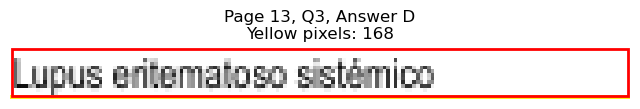

Page 13, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=456.5, y1=299.7
Page 13, Q3, E: Yellow pixels: 1765
Page 13, Q3, E: Total non-white pixels: 2249
Page 13, Q3, E: Yellow percentage: 78.5%


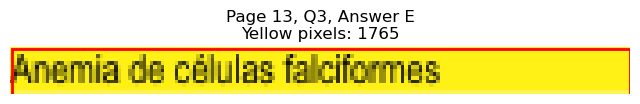


Page 13, Q3 - Selected Answer: E (based on yellow pixel count)




Page 13, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=110.1, y1=350.1
Page 13, Q4, A: Yellow pixels: 0
Page 13, Q4, A: Total non-white pixels: 143
Page 13, Q4, A: Yellow percentage: 0.0%


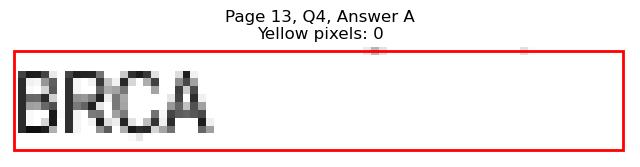

Page 13, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=97.5, y1=362.9
Page 13, Q4, B: Yellow pixels: 0
Page 13, Q4, B: Total non-white pixels: 78
Page 13, Q4, B: Yellow percentage: 0.0%


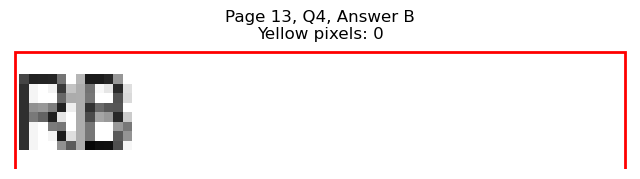

Page 13, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=112.6, y1=375.5
Page 13, Q4, C: Yellow pixels: 0
Page 13, Q4, C: Total non-white pixels: 131
Page 13, Q4, C: Yellow percentage: 0.0%


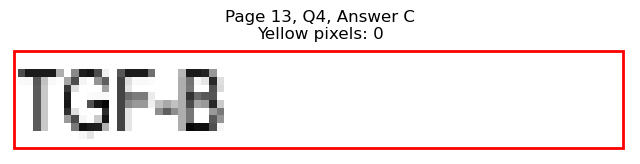

Page 13, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=354.7, y1=350.1
Page 13, Q4, D: Yellow pixels: 0
Page 13, Q4, D: Total non-white pixels: 93
Page 13, Q4, D: Yellow percentage: 0.0%


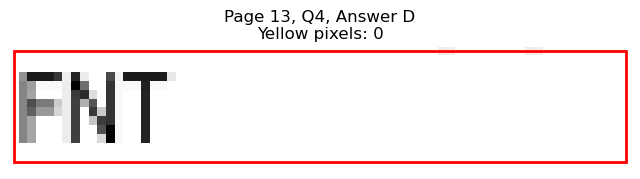

Page 13, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=362.2, y1=362.9
Page 13, Q4, E: Yellow pixels: 931
Page 13, Q4, E: Total non-white pixels: 1027
Page 13, Q4, E: Yellow percentage: 90.7%


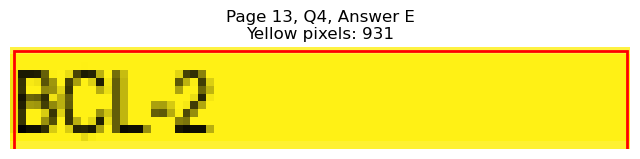


Page 13, Q4 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Qué mutación se observa en las formas heredit...
1   Varón de 28 años acudió a su médico por diarre...
2   Niño de 6 años se le diagnostica síndrome de D...
3   ¿Cuál de las siguientes lesiones, si está pres...
4   Lactante de 6 meses, presenta sinusitis bacter...
..                                                ...
95  ¿Cuál es la neoplasia maligna extracolónica má...
96  Niña de 15 años, presenta fiebre, faringitis y...
97  En una lesión resultante de un traumatismo dir...
98  ¿Cuál de las siguientes condiciones produce un...
99  ¿Cuál es el gen que estando mutado protege a l...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                        BRAF   
1                                    Estómago   
2                              Tumor de Wilms   
3                        Ectasia del conducto   
4            Inmunodeficiencia variable común   
..                                        ...   
95                  Adenocarcinoma de Barrett   
96  Linfadenitis por mononucleosis infecciosa   
97                                   Fractura   
98                      Enfermedad de Gaucher   
99                                       BRCA   

                                     option_B  \
0                                  p-Catenina   
1                            Colon ascendente   
2                               Neuroblastoma   
3                                Fibroadenoma   
4                        Síndrome de DiGeorge   
..                                        ...   
95  Carcinoma de células escamosas de esófago   
96           Linfadenitis por citomegalovirus   
97                                  Equimosis   
98                        Artritis reumatoide   
99                                         RB   

                                   option_C  \
0                                      TP53   
1                                   Duodeno   
2                            Feocromocitoma   
3     Cambio fibroquístico no proliferativo   
4              Agammaglobulinemia de Bruton   
..                                      ...   
95  Adenocarcinoma gástrico que surge en un   
96      Linfoma difuso de células B grandes   
97                           Herida contusa   
98                              Amiloidosis   
99                                    TGF-B   

                               option_D                           option_E  
0                                   RET                                RAS  
1                               Esófago                              Recto  
2                        Retinoblastoma                   Sarcoma de Ewing  
3                   Metaplasia apocrina              Adenosis esclerosante  
4                 Síndrome de hiper-IgM  Inmunodeficiencia combinada grave  
..                                  ...                                ...  
95  Carcinoma de células escamosas anal         Adenocarcinoma periampular  
96           Linfoma de Hodgkin clásico        Linfadenitis por Toxoplasma  
97                          Excoriación                           Hematoma  
98          Lupus eritematoso sistémico      Anemia de células falciformes  
99                                  FNT                              BCL-2  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Qué mutación se observa en las formas heredit...   
1   Varón de 28 años acudió a su médico por diarre...   
2   Niño de 6 años se le diagnostica síndrome de D...   
3   ¿Cuál de las siguientes lesiones, si está pres...   
4   Lactante de 6 meses, presenta sinusitis bacter...   
..                                                ...   
95  ¿Cuál es la neoplasia maligna extracolónica má...   
96  Niña de 15 años, presenta fiebre, faringitis y...   
97  En una lesión resultante de un traumatismo dir...   
98  ¿Cuál de las siguientes condiciones produce un...   
99  ¿Cuál es el gen que estando mutado protege a l...   

                                     option_A  \
0                                        BRAF   
1                                    Estómago   
2                              Tumor de Wilms   
3                        Ectasia del conducto   
4            Inmunodeficiencia variable común   
..                                        ...   
95                  Adenocarcinoma de Barrett   
96  Linfadenitis por mononucleosis infecciosa   
97                                   Fractura   
98                      Enfermedad de Gaucher   
99                                       BRCA   

                                     option_B  \
0                                  p-Catenina   
1                            Colon ascendente   
2                               Neuroblastoma   
3                                Fibroadenoma   
4                        Síndrome de DiGeorge   
..                                        ...   
95  Carcinoma de células escamosas de esófago   
96           Linfadenitis por citomegalovirus   
97                                  Equimosis   
98                        Artritis reumatoide   
99                                         RB   

                                   option_C  \
0                                      TP53   
1                                   Duodeno   
2                            Feocromocitoma   
3     Cambio fibroquístico no proliferativo   
4              Agammaglobulinemia de Bruton   
..                                      ...   
95  Adenocarcinoma gástrico que surge en un   
96      Linfoma difuso de células B grandes   
97                           Herida contusa   
98                              Amiloidosis   
99                                    TGF-B   

                               option_D                           option_E  \
0                                   RET                                RAS   
1                               Esófago                              Recto   
2                        Retinoblastoma                   Sarcoma de Ewing   
3                   Metaplasia apocrina              Adenosis esclerosante   
4                 Síndrome de hiper-IgM  Inmunodeficiencia combinada grave   
..                                  ...                                ...   
95  Carcinoma de células escamosas anal         Adenocarcinoma periampular   
96           Linfoma de Hodgkin clásico        Linfadenitis por Toxoplasma   
97                          Excoriación                           Hematoma   
98          Lupus eritematoso sistémico      Anemia de células falciformes   
99                                  FNT                              BCL-2   

   correct_answer  
0               D  
1               B  
2               A  
3               E  
4               C  
..            ...  
95              E  
96              A  
97              D  
98              E  
99              E  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/ANATOMIA PATOLOGICA.csv
